# CA2 "Transport in Ireland" - Simone Finelli

In [154]:
# Data Manipulation and Exploration
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Data Visualization (Matplotlib, Seaborn, Plotly)
import matplotlib.pyplot as plt
import seaborn as sns
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

#Statistical Analysis (Statsmodels and Scipy)
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import wilcoxon, kruskal, ttest_ind, levene, shapiro

# Text Processing (NLTK)
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Machine Learning (Scikit-Learn)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, classification_report
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Deep Learning (Keras)
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.wrappers.scikit_learn import KerasRegressor

# Miscellaneous
from itertools import product
import re
import time
import warnings

warnings.filterwarnings('ignore') # We can suppress the warnings

#DWH https://worldroadstatistics.org/wrs-data/data/

# Introduction

The original idea of the assesment was to understand how Irealnd would compare to other countries when looking at his transportation data.

Specifically, my interest was in undestanding if Ireland is a country heavely dependent on public transportation and what heavely would mean when compared to other countries.

Thanks to the dataset provided by the International Road Federation (IRF) I was able to collect traffic metrics for four-wheeled vechicles, including those used for public transportation.

In the following sections we will see how this data was used, what countries were compared to Ireland and what valuable data could be extracted.

# Programming for DA Tasks 

As requirede from the assesment, through this Jupyter notebook below tasks were addressed.

##### Programming:
The entire analysis has been implemented programmatically using Python, leveraging relevant libraries and code snippets. The code follows established Python coding standards (PEP 8) to ensure readability and maintainability.

- Indentations use 4 spaces per indentation level.
- Whitespaces are used in Expressions and Statements.
- All imports are on separate lines.
- Comments are used as complete sentences and do not state obvious.
- Descriptive names are used for variables and functions.
- Code is written using UTF-8.

##### Data Structures:
Data for this project has been sourced from two distinct formats.
- Data regarding traffic metric has been exported as a CSV file.
- Data regarding user reviews (for sentiment analysis purposes) has been scraped from web using Selenium and then stored in a CSV file. 

For the web scraping a Python script has been written and executed from command line. This is provided under web_scraper.py script commented below:

    import argparse
    from selenium import webdriver
    from selenium.webdriver.common.by import By
    from selenium.webdriver.common.keys import Keys
    from datetime import datetime
    import re
    import pandas as pd

    def scrape_reviews(url, csv_path):

        # Set up the Selenium webdriver
        driver = webdriver.Chrome()

        # Navigate to the provided URL
        driver.get(url)

        # Wait for the page to load (you may need to adjust the wait time based on your website)
        driver.implicitly_wait(10)

        reviews_data = []

        while True:
            # Find all review elements
            review_elements = driver.find_elements(By.CSS_SELECTOR, 'div[data-automation="reviewCard"]')

            for review_element in review_elements:
                try:
                    # Extract reviewer information
                    reviewer_name = review_element.find_element(By.CSS_SELECTOR, 'span.biGQs._P.fiohW.fOtGX a').text
                    reviewer_contributions = review_element.find_element(By.CSS_SELECTOR, 'div.zpDvc.Zb span').text

                    # Extract review details
                    review_score_element = review_element.find_element(By.CSS_SELECTOR, 'svg.UctUV.d.H0')
                    review_score = float(review_score_element.get_attribute('aria-label').split()[0])

                    review_text = review_element.find_element(By.CSS_SELECTOR, 'div.biGQs._P.fiohW.qWPrE.ncFvv.fOtGX a span.yCeTE').text

                    review_date_string = review_element.find_element(By.CSS_SELECTOR, 'div.RpeCd').text

                    # Use regular expression to extract month and year
                    match = re.search(r'(\w+ \d{4})', review_date_string)
                    if match:
                        review_date = datetime.strptime(match.group(1), '%b %Y').date()
                    else:
                        # Handle other date formats if necessary
                        review_date = None

                    # Append the extracted information to the data list
                    reviews_data.append({
                        "Reviewer": reviewer_name,
                        "Contributions": reviewer_contributions,
                        "Score": review_score,
                        "Review Text": review_text,
                        "Date": review_date
                    })

                except Exception as e:
                    print(f"Unable to parse a comment: {str(e)}")

            try:
                next_button = driver.find_element(By.CSS_SELECTOR, 'a[data-smoke-attr="pagination-next-arrow"]')
                next_page_url = next_button.get_attribute('href')
                driver.get(next_page_url)
                driver.implicitly_wait(10)
            except Exception as e:
                print(f"Unable to locate next page button: {str(e)}")
                break

        # Close the webdriver
        driver.quit()

        # Create a DataFrame from the reviews data
        df = pd.DataFrame(reviews_data)

        # Save the DataFrame to a CSV file
        df.to_csv(csv_path, index=False)

    if __name__ == "__main__":
        parser = argparse.ArgumentParser(description="Scrape TripAdvisor reviews.")
        parser.add_argument("url", type=str, help="URL of the TripAdvisor page")
        parser.add_argument("csv_path", type=str, help="Path to the CSV file for storing scraped data")
        args = parser.parse_args()

        scrape_reviews(args.url, args.csv_path)
        
##### Documentation:
The project documentation is designed to provide clarity on code choices and methodologies. Sound justifications are provided for each decision, and code quality adheres to established standards. In-line comments, function documentation, and an overview of the notebook structure were used to contribute to a well-documented project.

##### Testing & Optimization:
A robust testing strategy is outlined to ensure the correctness of the code, and optimization strategies have been employed to enhance resource efficiency. The notebook details how testing was conducted and optimizations were implemented, along with any trade-offs made during the process.

##### Data Manipulation:
For each data source, relevant libraries and techniques were used. The selected libraries and techniques for data processing and aggregation are justified based on the analysis need.

# Data Preparation & Visualisation Tasks 1-3

#### ●	Discuss in detail the process of acquiring your raw data, detailing the positive and/or negative aspects of your research and acquisition. This should include the relevance and implications of any and all licensing/permissions associated with the data. [0-15]

For this assesment two different sources have been used:
- Traffic transportation data for Ireland and other countries
- Public transportation reviews for Ireland and other countries

##### Traffic transportation data for Ireland and other countries
When looking at transportation data I found it quite easy to obtain some kind of information for a specific country. 
The aim of my assesment was to compare as many countries as possible to Ireland and I found it quite difficult to find a sdandardized source that would have this data. Hopefully, after an exthensive research, I came across data provided by IRF:
- https://worldroadstatistics.org/wrs-data/data/

Traffic data for multiple categories and countries were made available in the IRF datawarehouse. For the objective of this assesment I decided to focus on traffic data of four wheeled vehicles and EU area countries.

Reason why four wheeled vehicles traffic was used is because:
- It is the most interesting road network metric available from the datawarehouse and that aligns to our objective
- I made an assumption that data from vehicles such as buses and vans, especially when compared to other four wheeled vehicles, would quite well reflect the usage of public transportation overall in the observed country. 

A positive aspect of using this data is that it is coming from a reliable datasource: The International Federation Road. This organization is a global, independent, not-for-profit organisation with headquarters in Geneva, Switzerland. Active since 1948, its mission is to promote the development of roads and road networks that enable access and sustainable mobility for all.

A negative aspect is that assumptions were needed as only road traffic is available while railway usage, for example, is completely missing. Because of this, another assumption has been made: users reviews on public trasnportation such as trains has been considered equivalent to public four wheeled vehicles. 

The acquisition of this data required a registration process that then led to the access of the datawarehouse. Looking at the Terms and Conditions we can read:
- 1.2 By registering an IRF WRS Data Warehouse Account, you agree that (1.) you will not do anything which would assist anyone who is not a registered user to gain access to the IRF World Road Statistics data, (2.) you will not create accounts for the purpose of abusing the functionality of the site, or other users, (3.) to notify IRF immediately if you become aware of any unauthorised use of your password by others. 

More information: https://worldroadstatistics.org/general-terms-conditions/

To comply to this I therfore require anyone looking into this assesment to register, for free, to the datasource: https://datawarehouse.worldroadstatistics.org/register

An exchange of emails with the IRF Statistis Team has taken place to notify them regarding the usage of this data for academic purposes only.

##### Public transportation reviews for Ireland and other countries
As part of the assesment, a sentiment analysis model needs to be built. For this purpose I decided to retrieve users reviews regarding public trasportation and relate their sentiment to the traffic metric for forecasting purposes.

A positive aspect of using this data is that I was able to enhance traffic data only with end user sentiment and feedback, meaning that provided results are not only generated by a single source of truth but also unstructured data avilable in the web.

A negative aspect of using this data is the complexity of its nature. Givan that reviews are considered are unstructured text, it was quite complex to find a single and certified source of truth.

#### ●	Exploratory Data Analysis helps to identify patterns, inconsistencies, anomalies, missing data, and other attributes and issues in data sets so problems can be addressed. Evaluate your raw data and detail, in depth, the various attributes and issues that you find. Your evaluation should reference evidence to support your  chosen methodology and use visualizations to illustrate your findings.[0-25]

Let's start by loading our data.

The datawerahouse only allowed to dowload data for single years, the first thing to do is to merge this data in a single dataframe:

In [2]:
df_2021 = pd.read_csv("../Data/total-four-wheeled-traffic-(by-vehicle-type)---2021.csv")
df_2020 = pd.read_csv("../Data/total-four-wheeled-traffic-(by-vehicle-type)---2020.csv")
df_2019 = pd.read_csv("../Data/total-four-wheeled-traffic-(by-vehicle-type)---2019.csv")
df_2018 = pd.read_csv("../Data/total-four-wheeled-traffic-(by-vehicle-type)---2018.csv")
df_2017 = pd.read_csv("../Data/total-four-wheeled-traffic-(by-vehicle-type)---2017.csv")
df_2016 = pd.read_csv("../Data/total-four-wheeled-traffic-(by-vehicle-type)---2016.csv")

df_2021["Year"] = 2021 
df_2020["Year"] = 2020
df_2019["Year"] = 2019
df_2018["Year"] = 2018
df_2017["Year"] = 2017
df_2016["Year"] = 2016

df = pd.concat([df_2021,df_2020,df_2019,df_2018,df_2017,df_2016])

# Quickly show the dataset
df.head()

Category  Passenger Car Traffic  Bus and Motor Coach Traffic  \
0   Austria                60721.0                        390.0   
1   Belarus                  244.0                        324.0   
2  Bulgaria                    NaN                        353.0   
3   Croatia                19780.0                        240.0   
4   Denmark                40313.0                        624.0   

   Total Van, Pickup, Lorry and Road Tractor Traffic  \
0                                            13810.0   
1                                              935.0   
2                                             2757.0   
3                                             3170.0   
4                                             9257.0   

   Total four wheeled Traffic  Year  
0                     74921.0  2021  
1                      1503.0  2021  
2                      3110.0  2021  
3                     23190.0  2021  
4                     50194.0  2021

Loaded data is representing the traffic volume, either for specific vehicle categories or for all vehicles.
Traffic volume is defined by IRS as:
- Weighted average daily flow of each vehicle type on each category of the road network, as determined from regular national stratified, classified traffic counts.

If no data is availble, then an estimation is calculated:
- If counts are not available, traffic volume is estimated by dividing the annual consumption of motor vehicle fuel (in litres) used in the country by the number of vehicles in each category. The result is then multiplied by the average number of km/litre for that category.

It's also worth giving a definition of the vehicle types here represented:
- Passenger cars are road motor vehicle, other than a motor cycle, intended for the carriage of passengers and designed to seat no more than nine persons (including the driver). Passenger cars include microcars (needing no permit to be driven), taxis, vans designed for transport of passengers and passenger hire cars, provided that they have fewer than ten seats.
- Buses and motor coaches are road motor vehicles designed to seat more than nine persons (including the driver). Included are mini-buses and mini-coaches designed to seat more than nine persons (including the driver).
- Vans & Pick-ups (Light goods road vehicle) are road vehicles with a gross vehicle weight of not more than 3500 kg, designed, exclusively or primarily, to carry goods, e.g. vans and pick-ups.
- Total four wheeled Traffic is just the sum of the preiovus.

More information: https://worldroadstatistics.org/wp-content/uploads/2020/08/WRS-Definitions.pdf

Let's now get an idea of the column types:

In [3]:
# We aim at understanding the datatypes of available columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188 entries, 0 to 30
Data columns (total 6 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Category                                           188 non-null    object 
 1   Passenger Car Traffic                              152 non-null    float64
 2   Bus and Motor Coach Traffic                        176 non-null    float64
 3   Total Van, Pickup, Lorry and Road Tractor Traffic  175 non-null    float64
 4   Total four wheeled Traffic                         158 non-null    float64
 5   Year                                               188 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 10.3+ KB


A quick statistical description:

In [4]:
# We aim at having a statistical description of our dataset
df.describe()

Passenger Car Traffic  Bus and Motor Coach Traffic  \
count             152.000000                   176.000000   
mean            93395.019737                   879.346591   
std            156635.457716                  1141.624426   
min                29.000000                     3.000000   
25%              9396.000000                   169.500000   
50%             34973.500000                   415.500000   
75%             70646.000000                   844.000000   
max            649600.000000                  4600.000000   

       Total Van, Pickup, Lorry and Road Tractor Traffic  \
count                                         175.000000   
mean                                        19094.211429   
std                                         31317.093342   
min                                             4.000000   
25%                                          2484.500000   
50%                                          7248.000000   
75%                                         16646.000000   
max                                        122489.000000   

       Total four wheeled Traffic         Year  
count                  158.000000   188.000000  
mean                110578.993671  2018.500000  
std                 186865.921966     1.710302  
min                     59.000000  2016.000000  
25%                  11277.500000  2017.000000  
50%                  44376.500000  2018.500000  
75%                  83172.250000  2020.000000  
max                 751400.000000  2021.000000

And the shape of the dataset:

In [5]:
# Let's get the shape of the dataset
df.shape

(188, 6)

As of now we can conclude that our dataset is made of 6 columns and 188 rows.

The six columns are all numerical except for the Category one that represents the name of the country.
Each row shows the traffic metrics of a specific country in a given year.

From the descriptive statistics we can already see what are min, max and other values for traffic metrics. From this data we can immediately see one problem: given that compared countries can be very different between each other, traffic data can vary significantly. 

For this reason we will consider % of traffic metrics with respect to the total four wheeled traffic.

Let's now check if we have missing values:

In [6]:
# And check if there is any null value
df.isnull().sum()

Category                                              0
Passenger Car Traffic                                36
Bus and Motor Coach Traffic                          12
Total Van, Pickup, Lorry and Road Tractor Traffic    13
Total four wheeled Traffic                           30
Year                                                  0
dtype: int64

Previous results show that, for some countries, we have missing values.

This is very important to note as we need to understand if we want to drop rows with missing values or create synthetic data to fill those. That being said, let's see what are the countries we are working on:

In [7]:
# Let's get the countries represented in the dataset
sorted(df["Category"].unique())

['Austria',
 'Belarus',
 'Belgium',
 'Bulgaria',
 'Croatia',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Hungary',
 'Ireland',
 'Latvia',
 'Lithuania',
 'Malta',
 'Moldova',
 'Monaco',
 'Montenegro',
 'Netherlands',
 'North Macedonia',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Russian Federation',
 'Serbia',
 'Slovak Republic',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Ukraine',
 'United Kingdom']

The best way to visualize missing data and check imbalances in the scale of the metrics is thorugh visualization. Let's then build an interactive visualization to show values of each feature over time and by country:

In [8]:
# Initialize Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='feature-selector',
        options=[{'label': col, 'value': col} for col in df.columns[1:-1]],
        value='Total four wheeled Traffic',
        multi=False,
        style={'width': '50%'}
    ),
    dcc.Graph(id='traffic-bar-chart')
])

# Define callback to update the bar chart based on dropdown selection
@app.callback(
    Output('traffic-bar-chart', 'figure'),
    [Input('feature-selector', 'value')]
)
def update_bar_chart(selected_feature):
    df_grouped = df.groupby(["Category", "Year"]).sum().reset_index()
    fig = px.bar(df_grouped, x='Year', y=selected_feature, animation_frame='Category',
                 title=f'{selected_feature} by Year Over Categories')
    fig.update_layout(xaxis_title='Year', yaxis_title=selected_feature)
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

Previous graphs allows us to select the metric we want to inspect using the dropdown menu on the top left. The scrolling bar allows to change country and each bar represent the metric value for a specific year.

From the graph we can say that:
- Looking at the "Total four wheeled traffic" we can see high imbalances with values going from about 50k to 750k
- Some countries, such as Belgium and Montenegro, are either missing data for specific years or for entire metrics

So we realize the need to work on the imbalance and the filling of missing data but what about outliers?

Let's plot, for each feature, a boxplot to see if there are evident outliers:

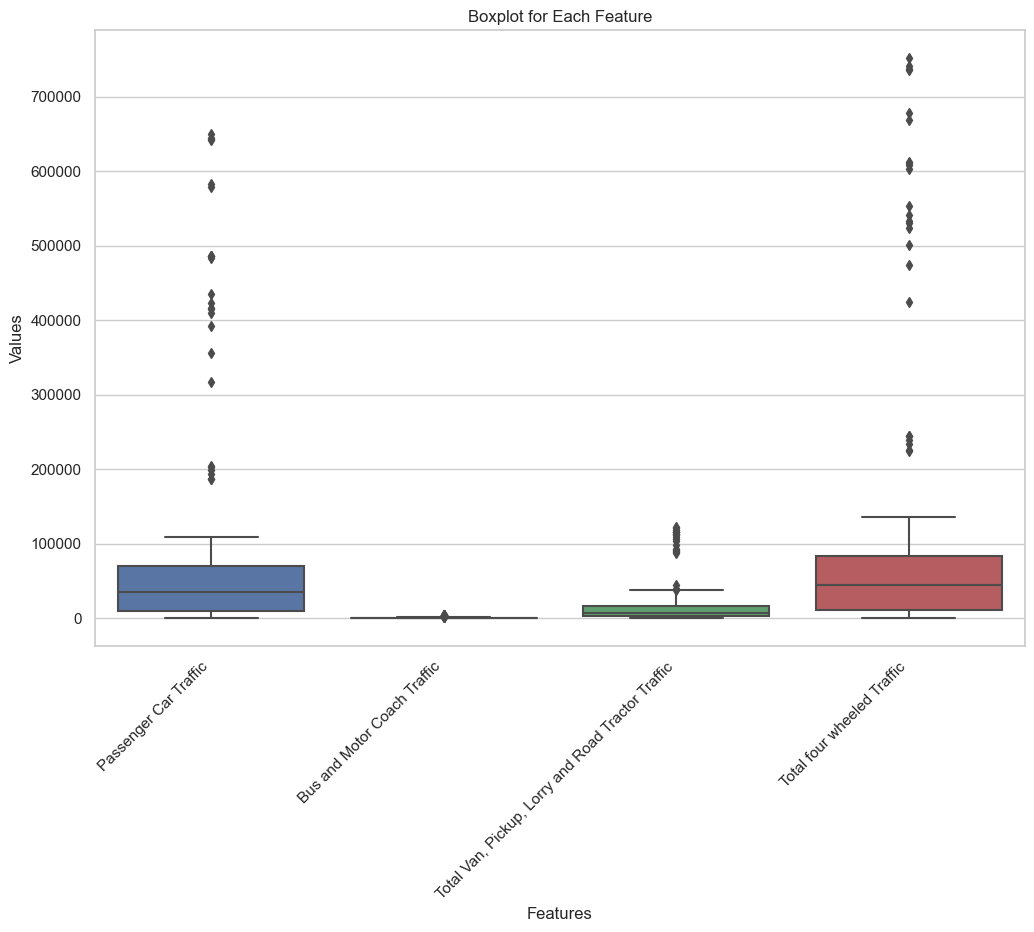

In [9]:
sns.set(style="whitegrid")  # Set the style of the visualization

# Selecting the relevant columns for boxplot
boxplot_data = df.drop(columns=['Category', 'Year'])

# Create a boxplot for each feature
plt.figure(figsize=(12, 8))
sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_data))
plt.title("Boxplot for Each Feature")
plt.xlabel("Features")
plt.ylabel("Values")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

From previous graph we can immediatelly see many outliers. Reasons for this can be:
- The many outliers could simply be only few countries behaving as outliers for multiple years
- The fact that data is not scaled might simply show an high number of outliers

Let's try to do the same but looking at countries one by one:

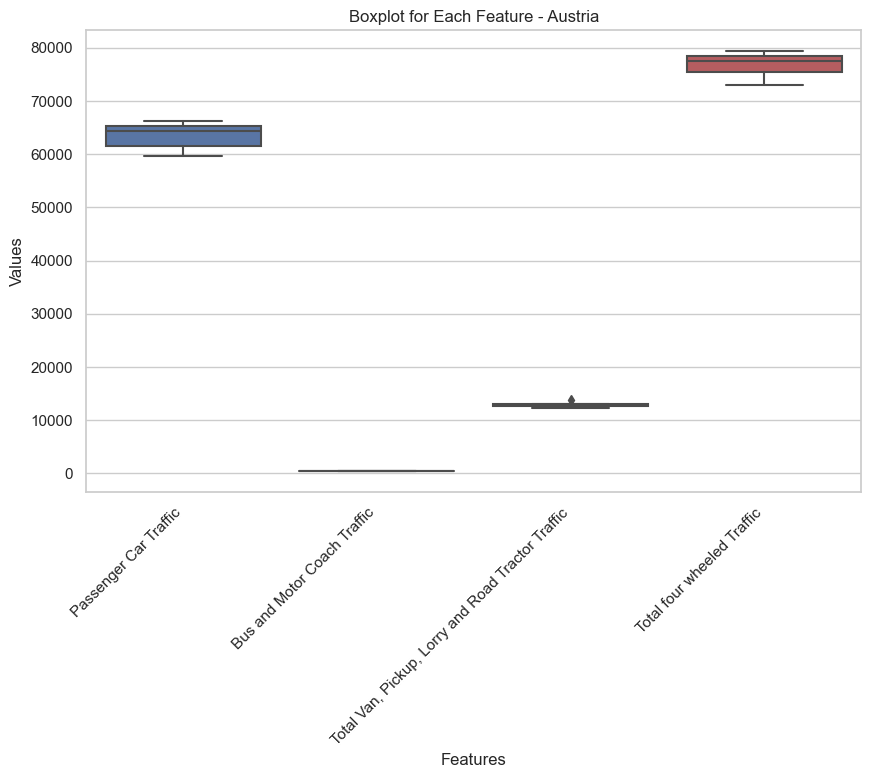

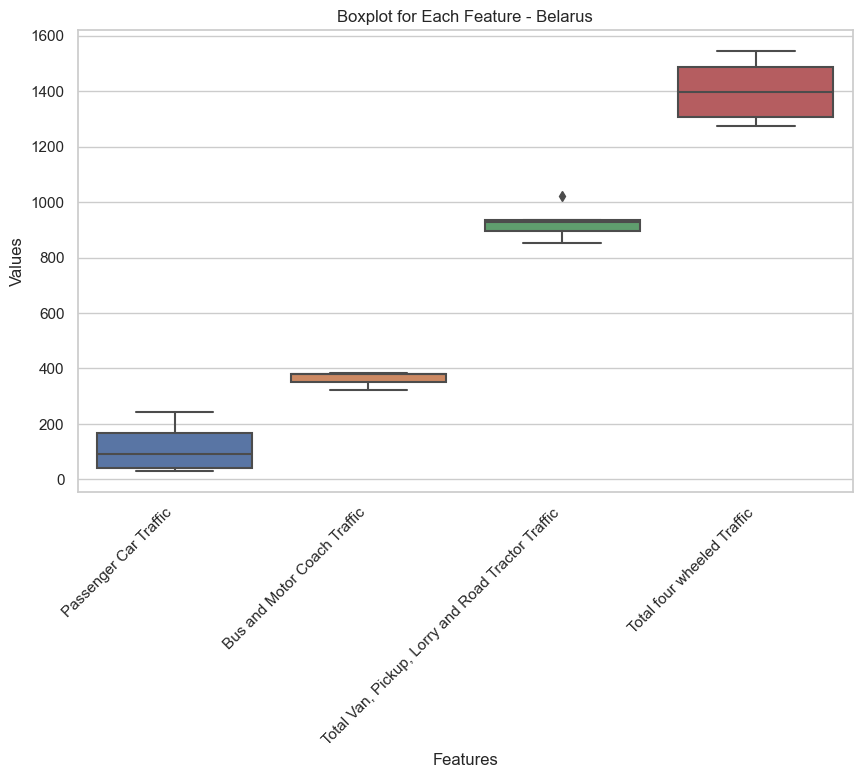

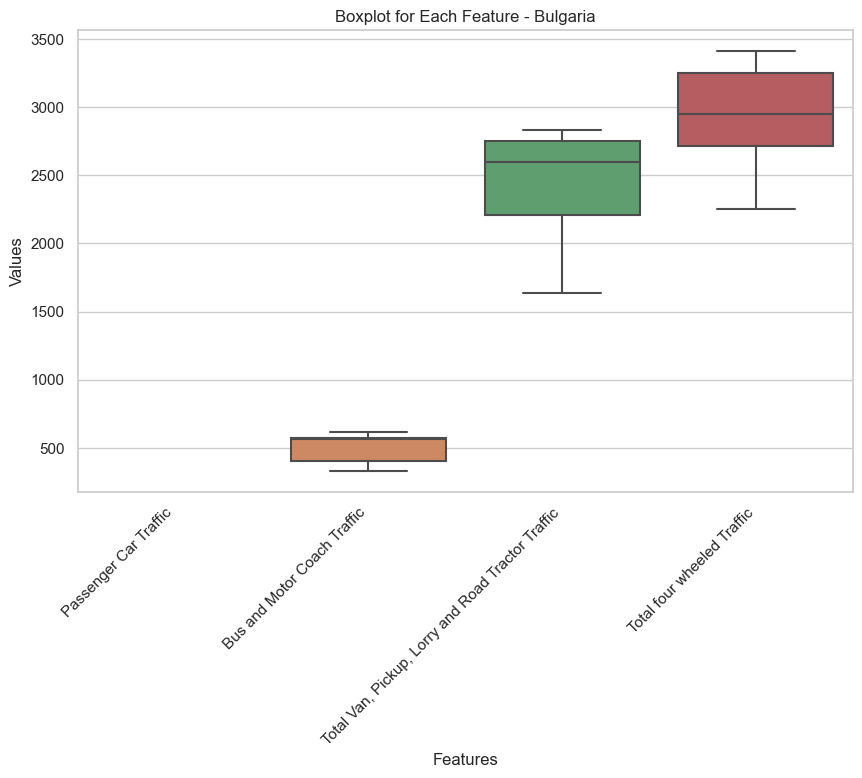

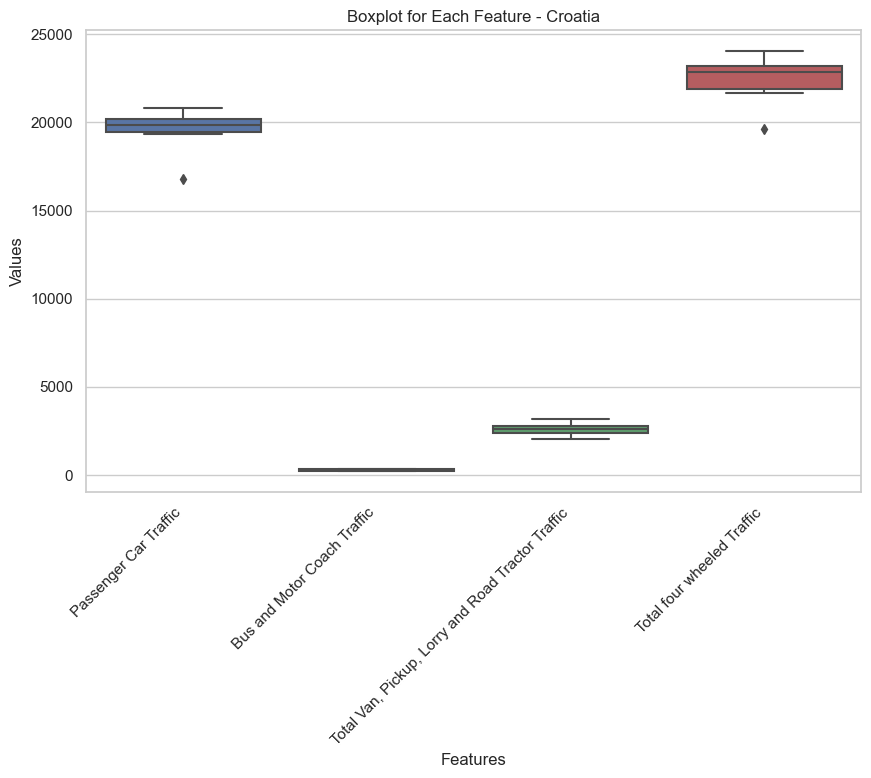

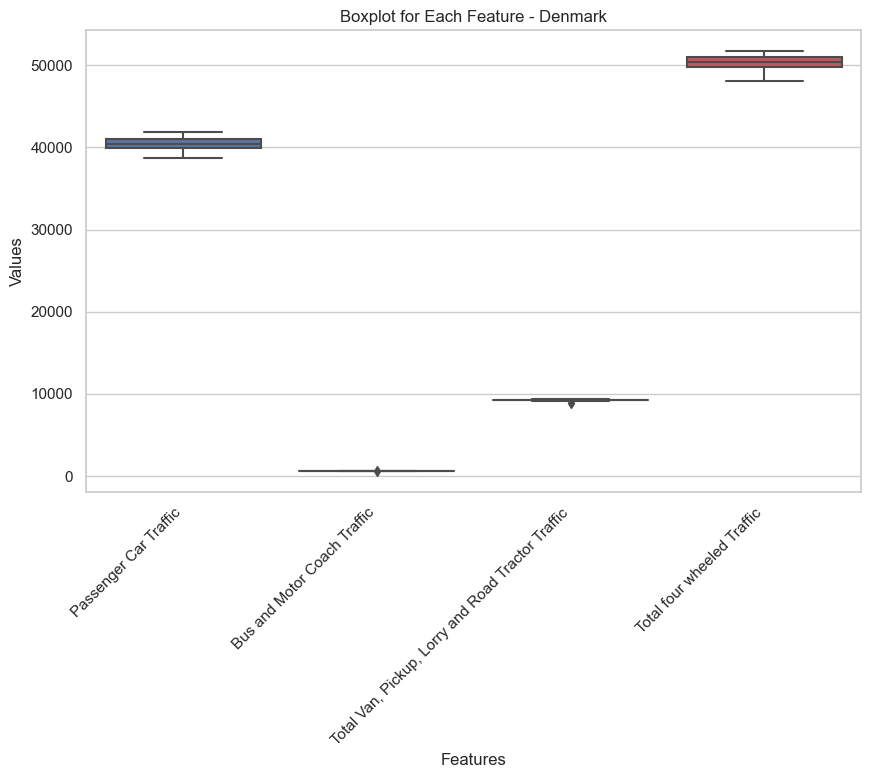

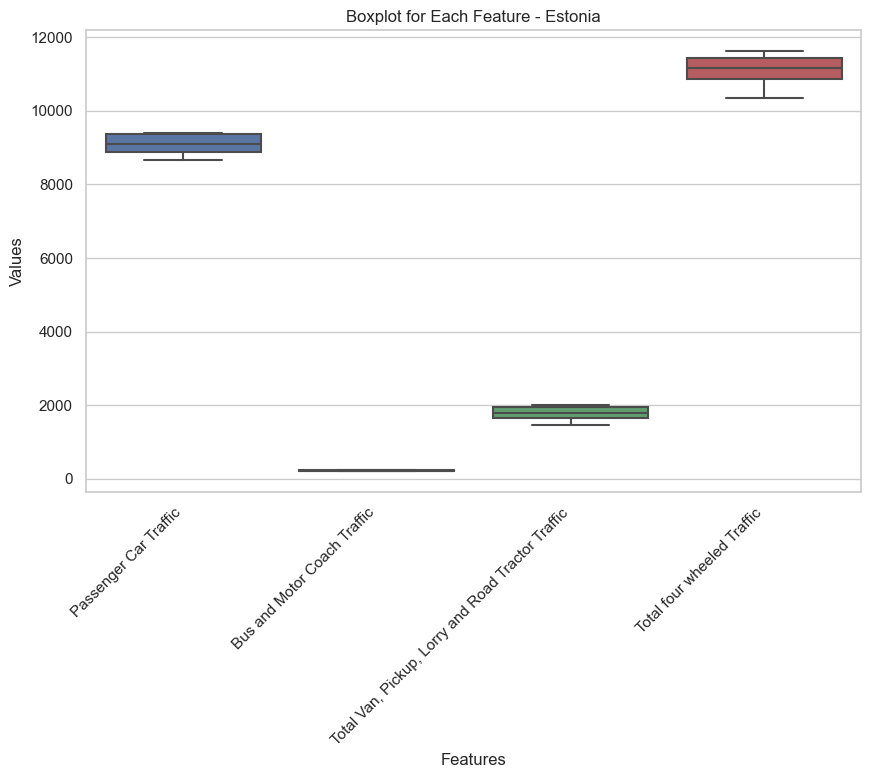

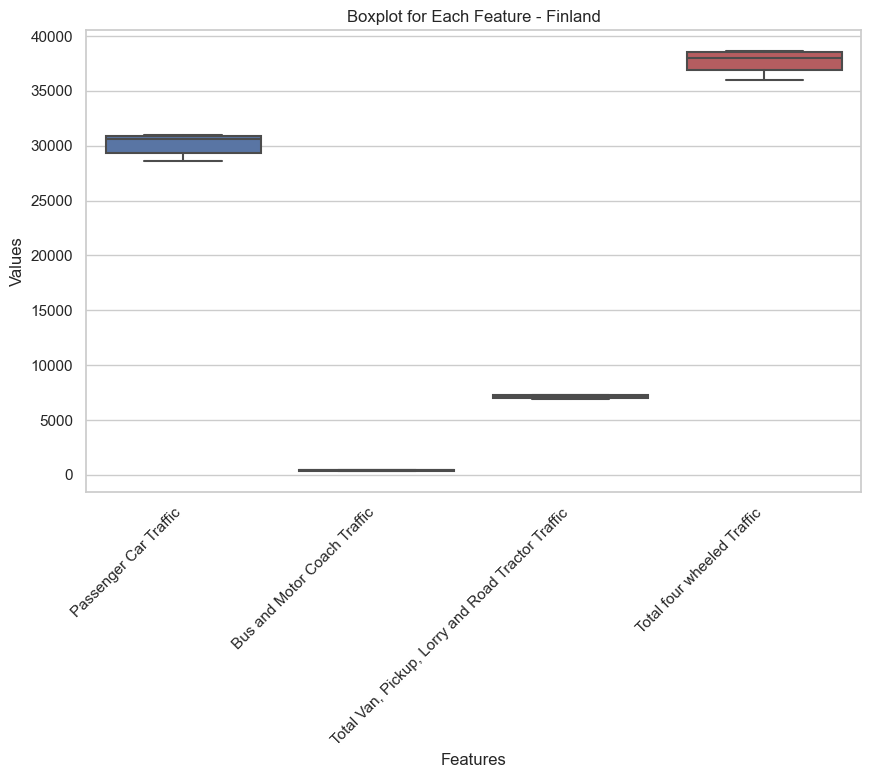

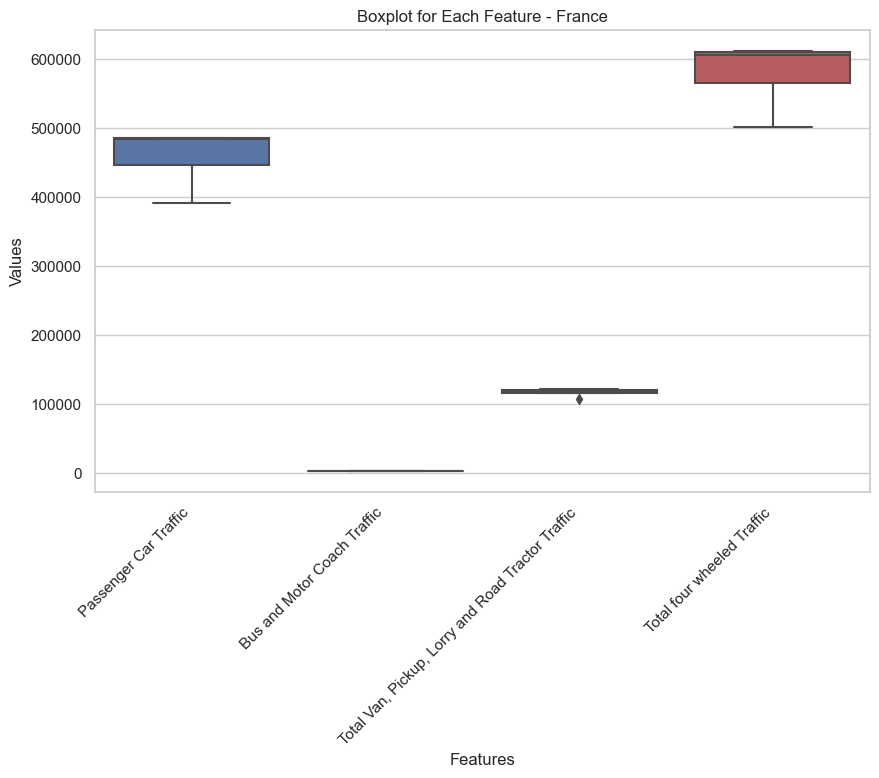

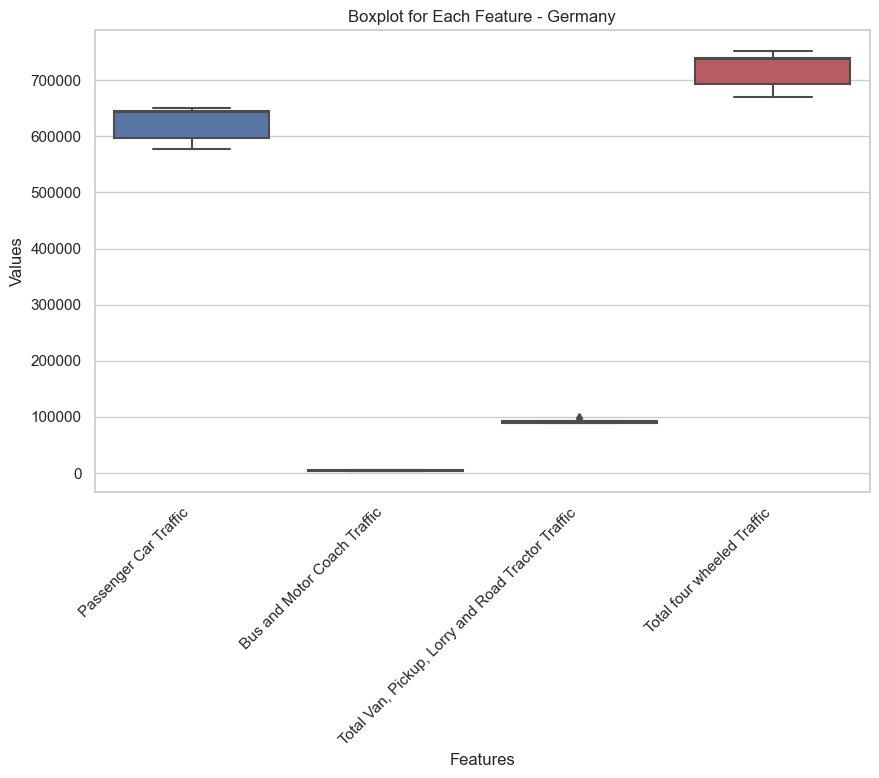

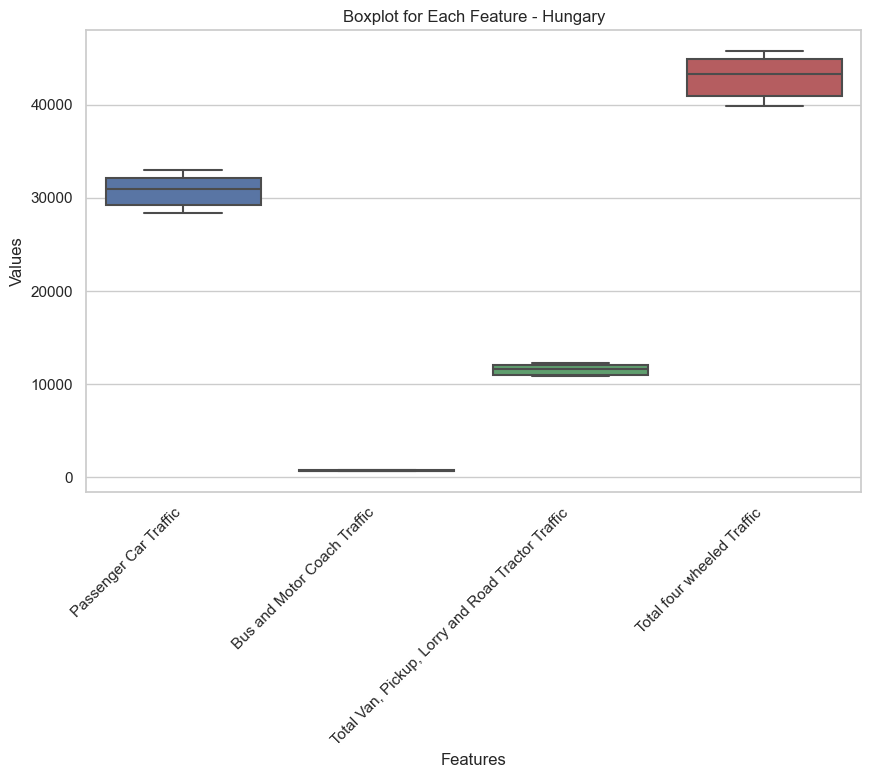

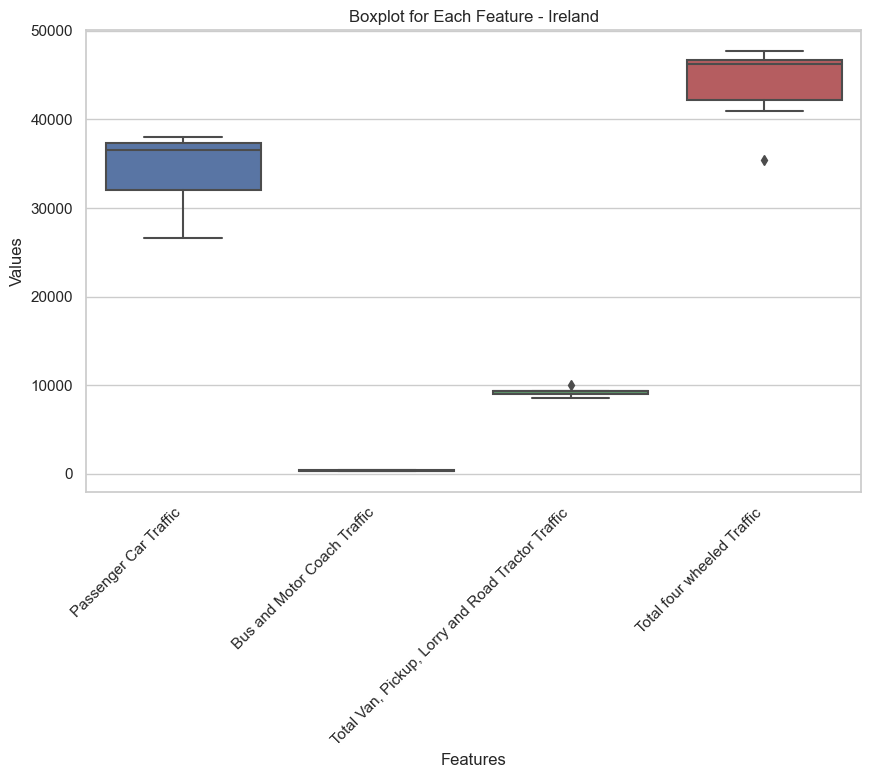

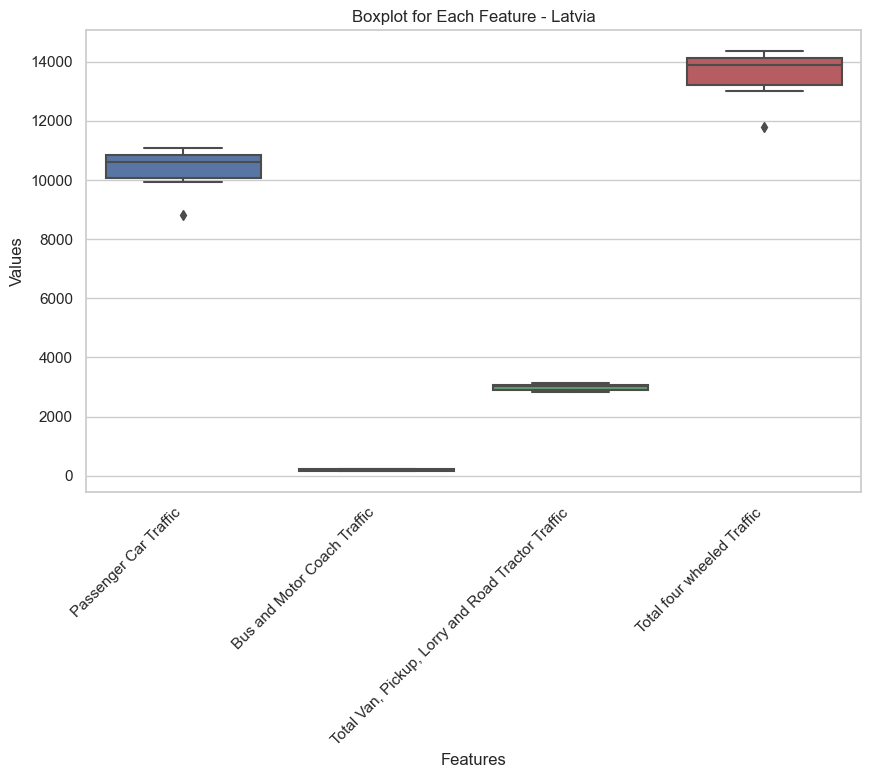

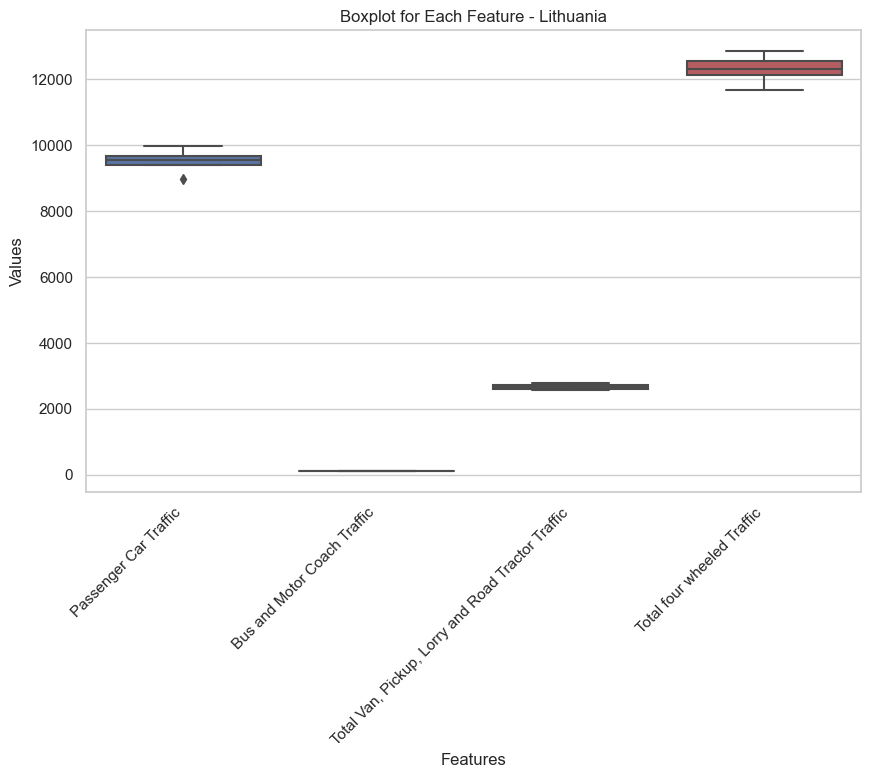

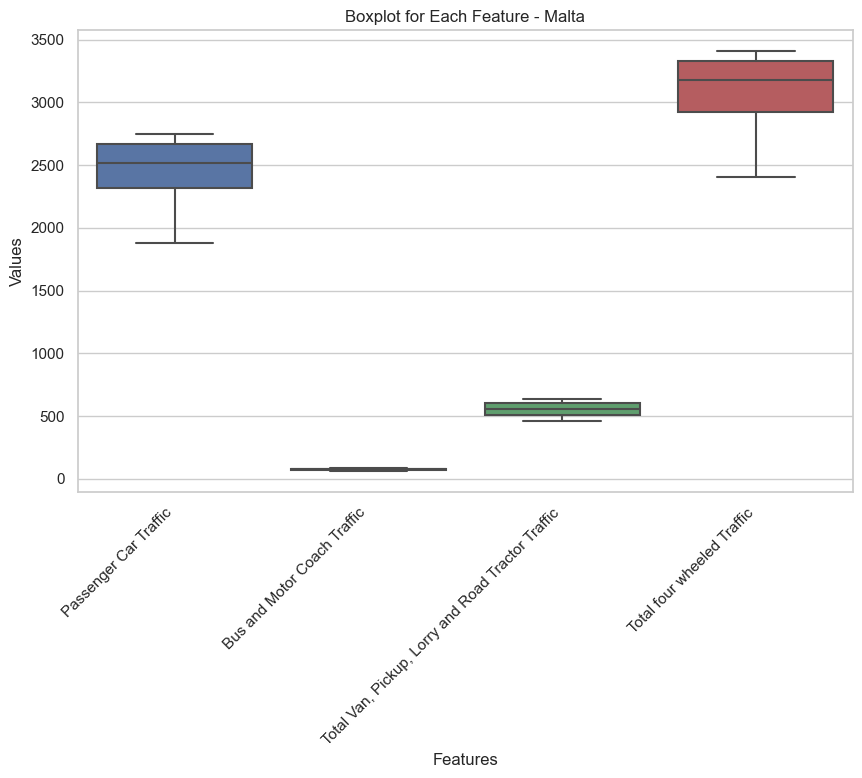

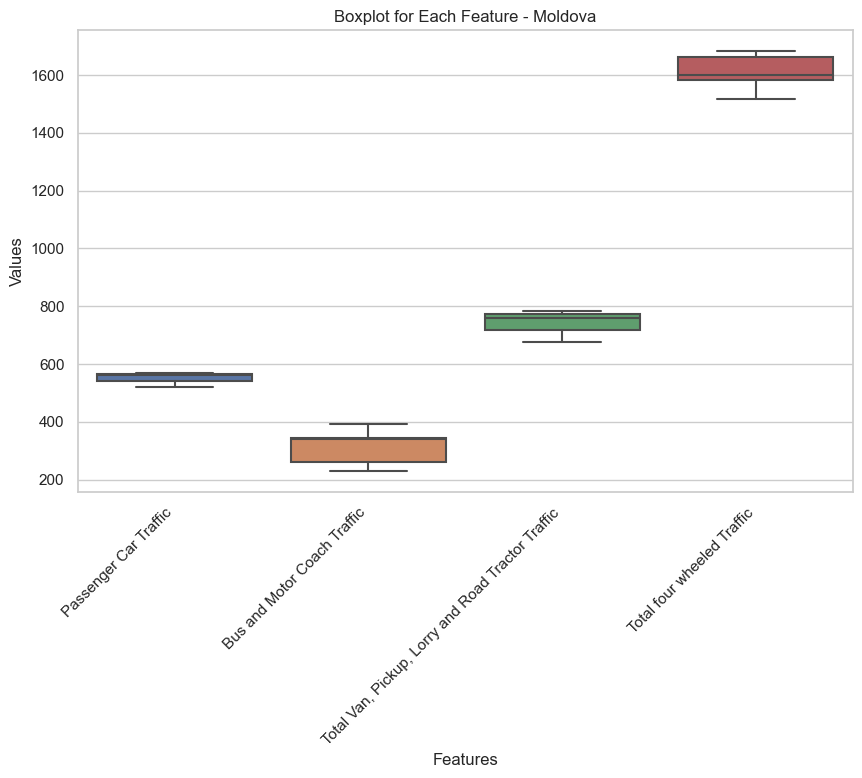

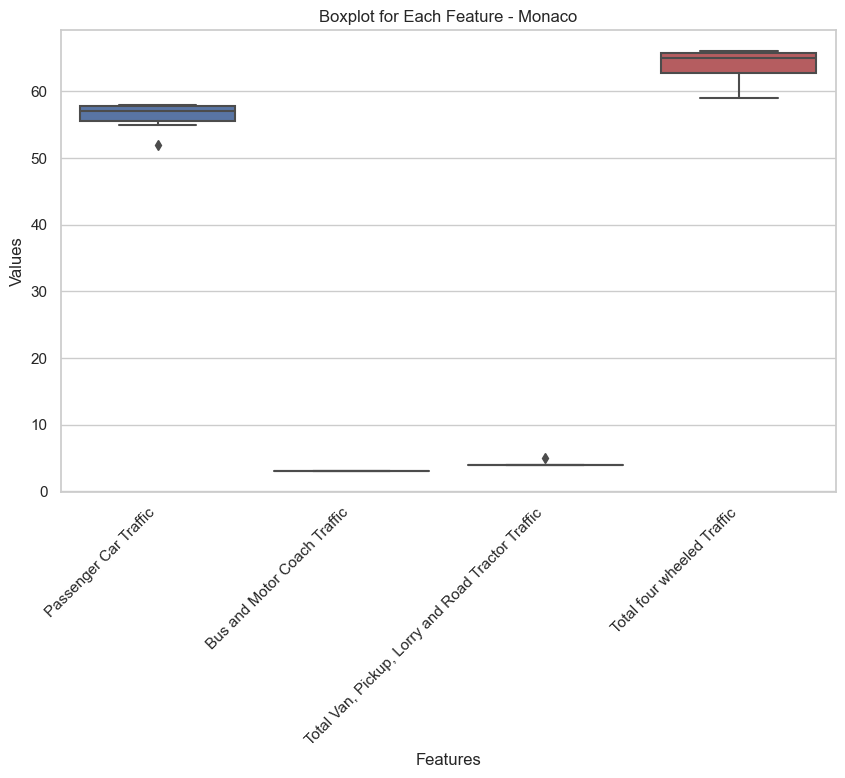

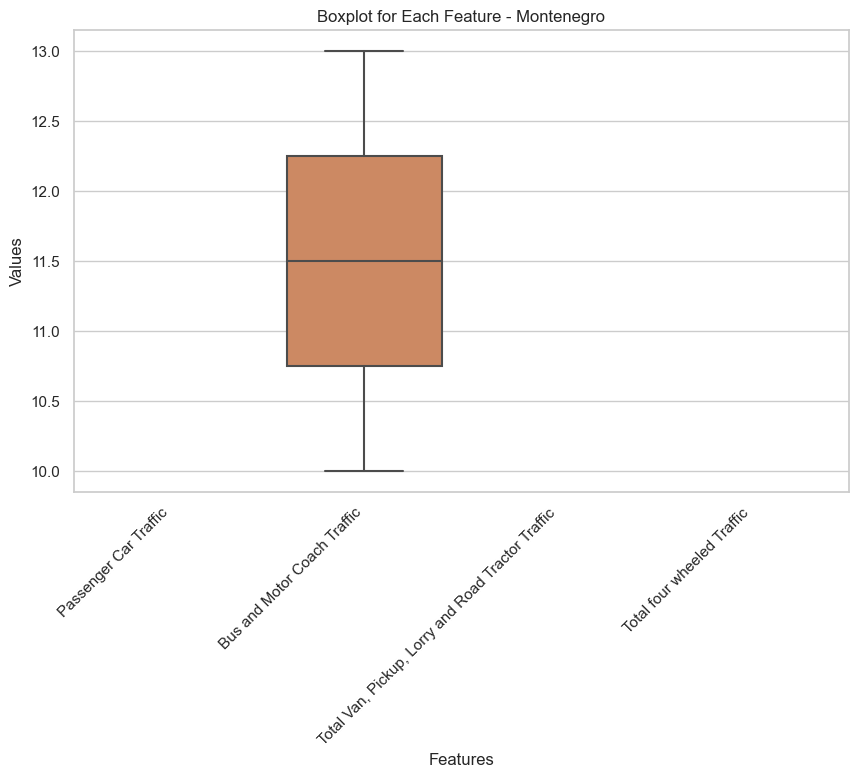

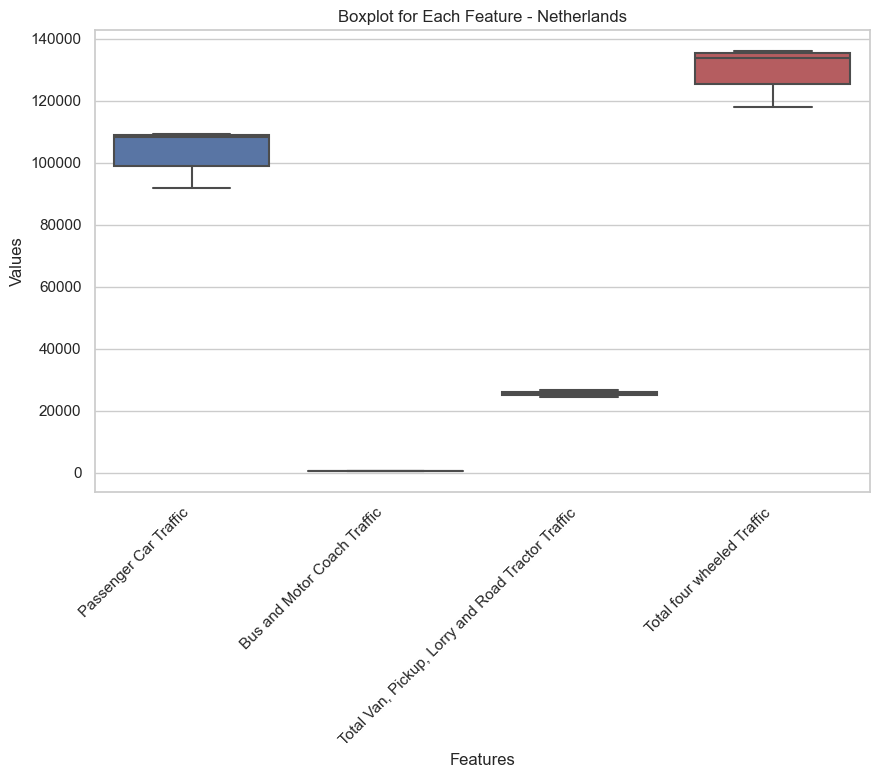

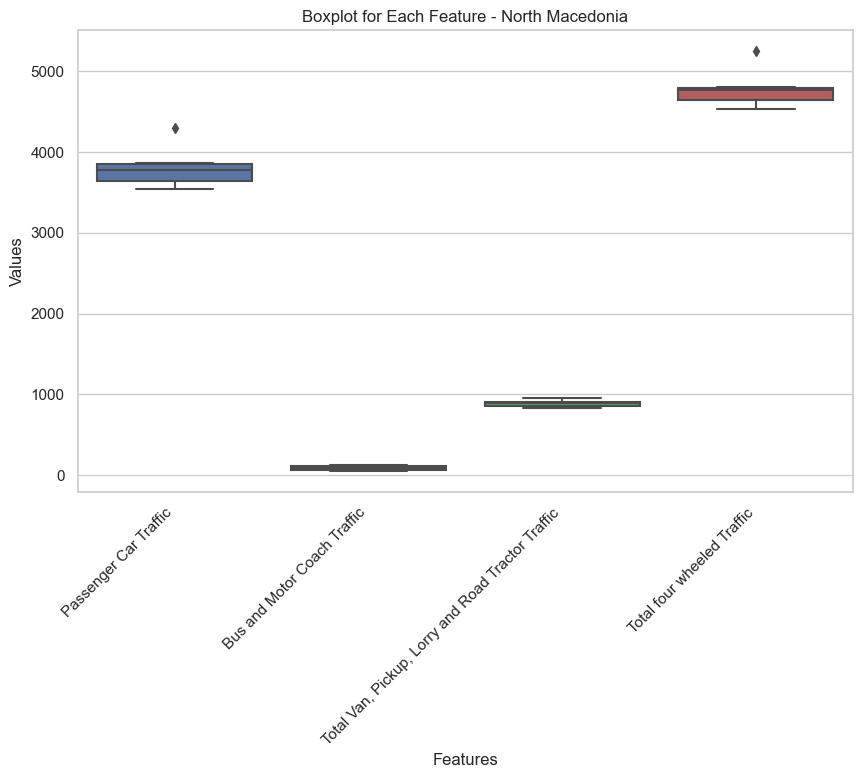

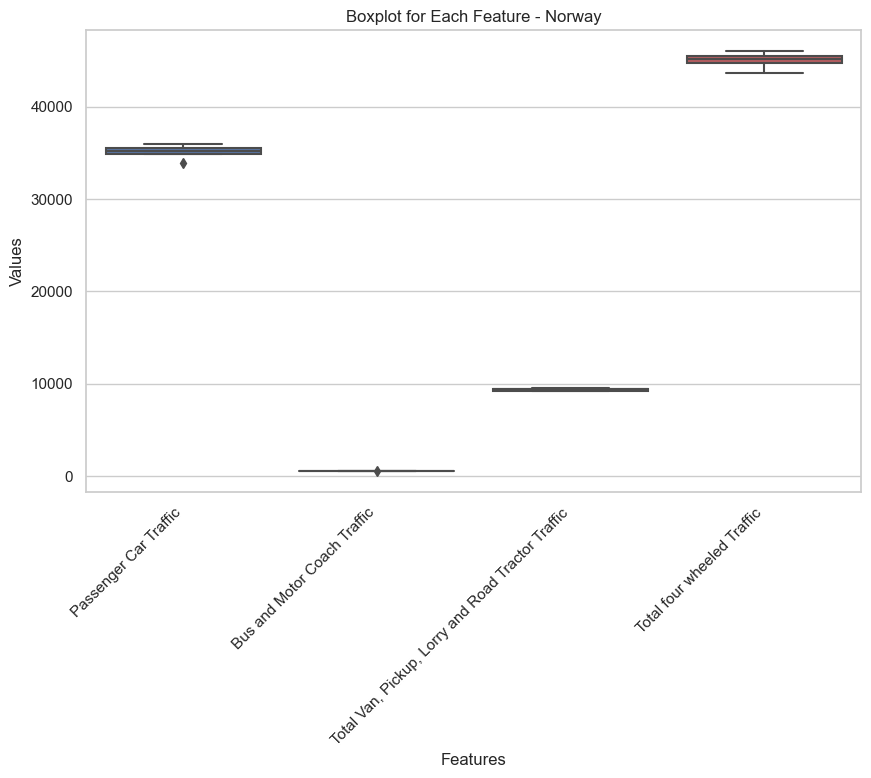

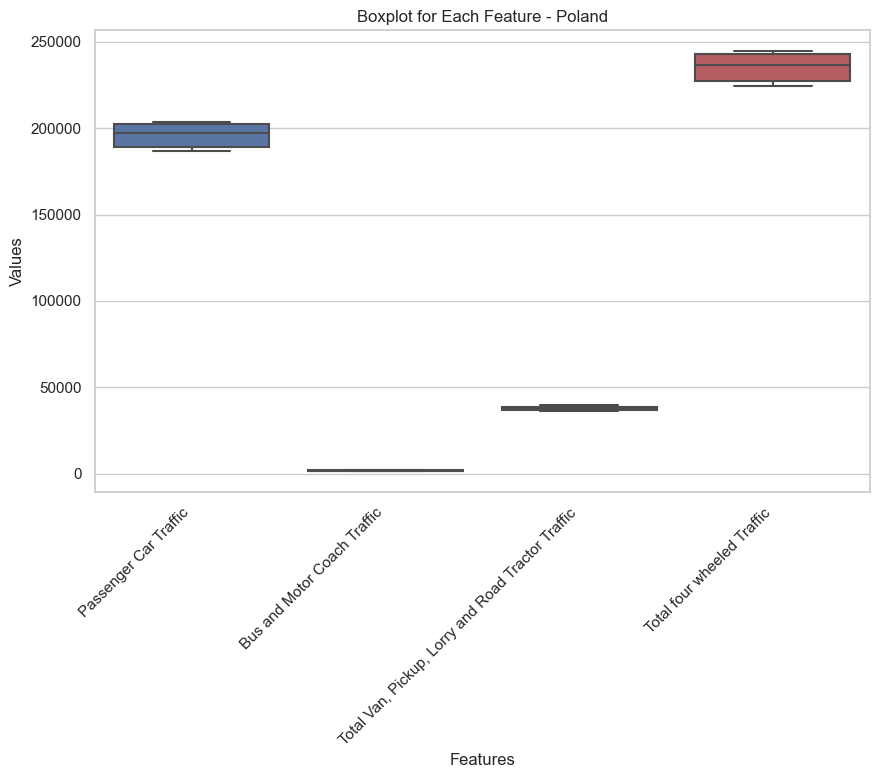

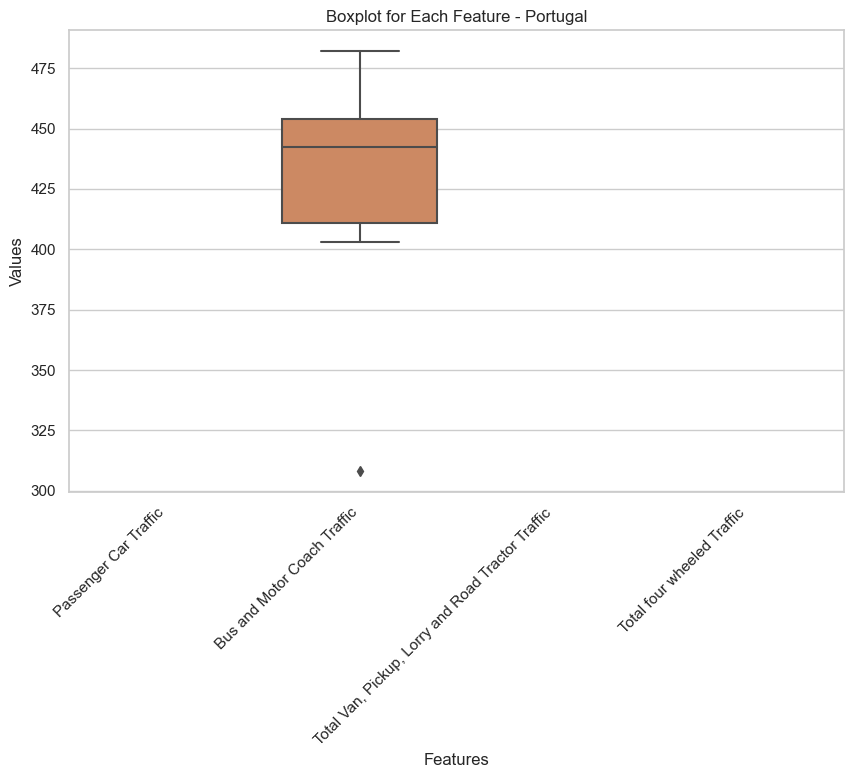

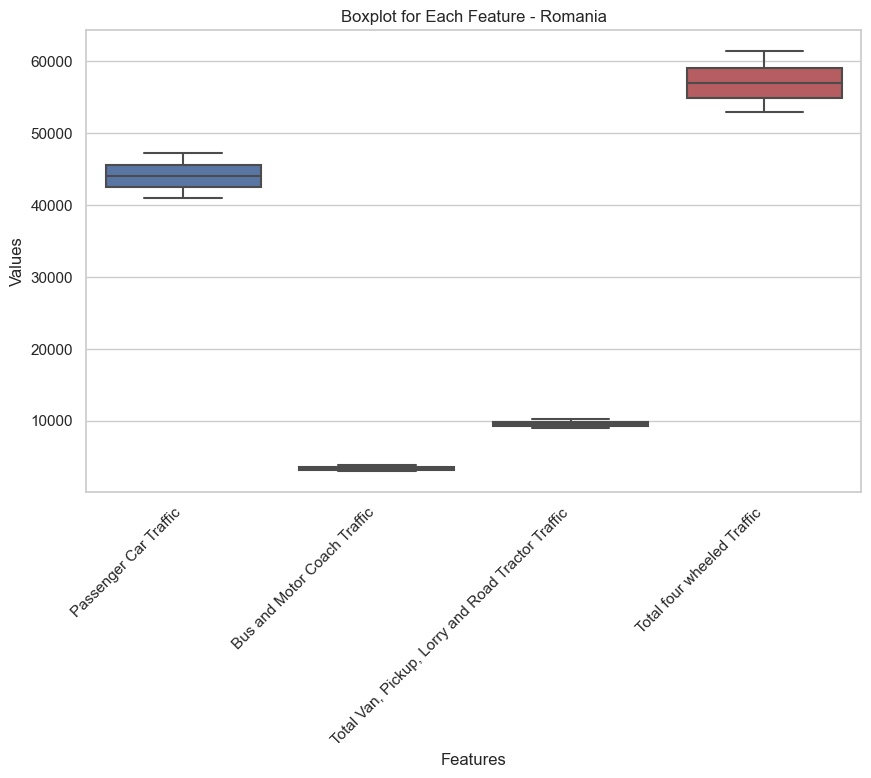

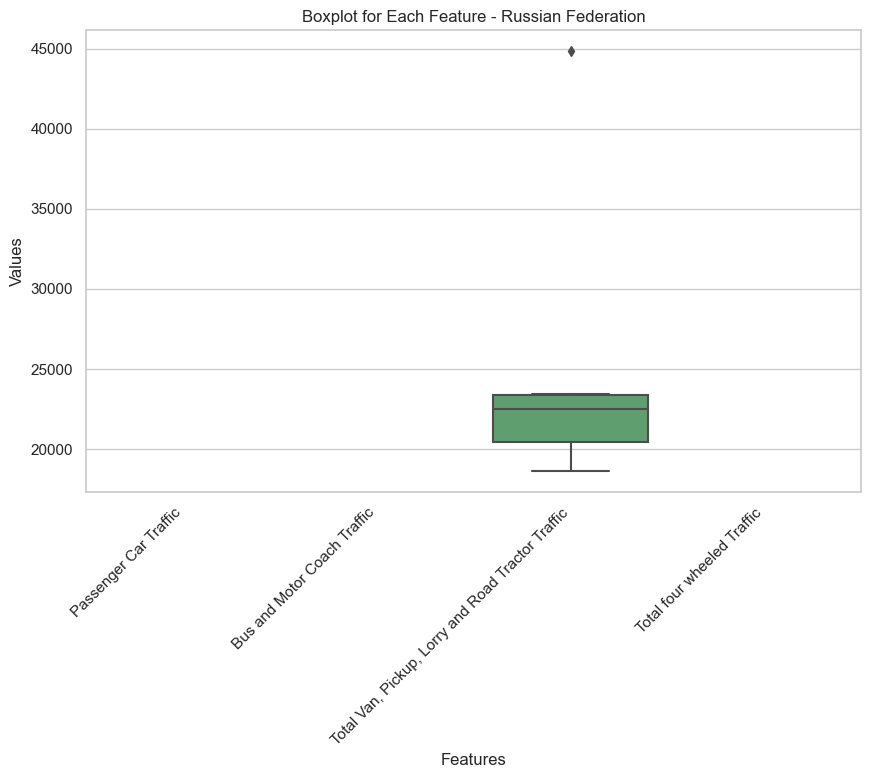

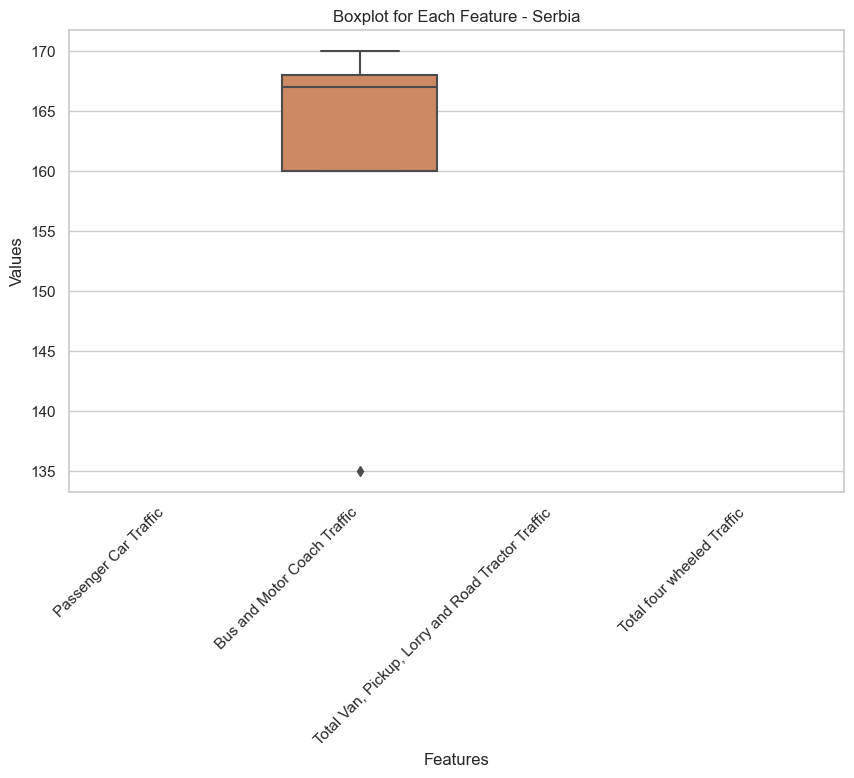

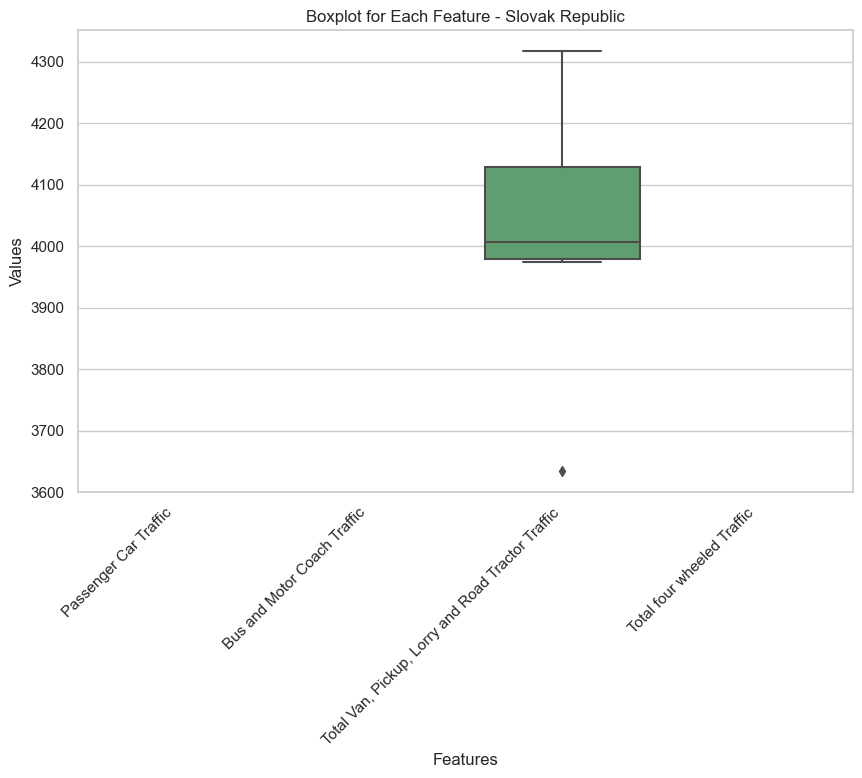

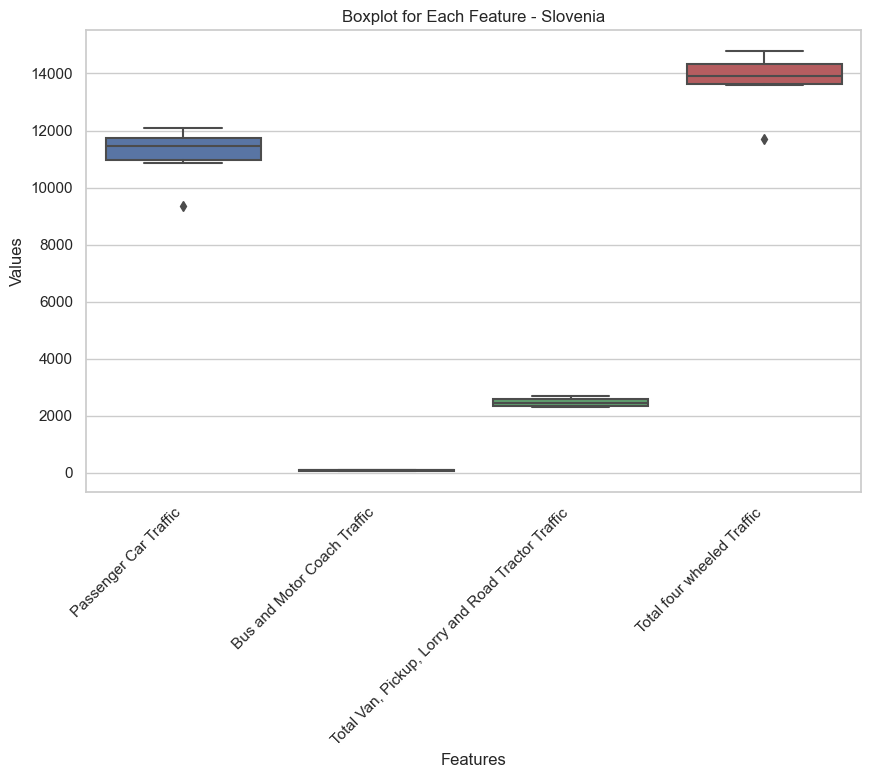

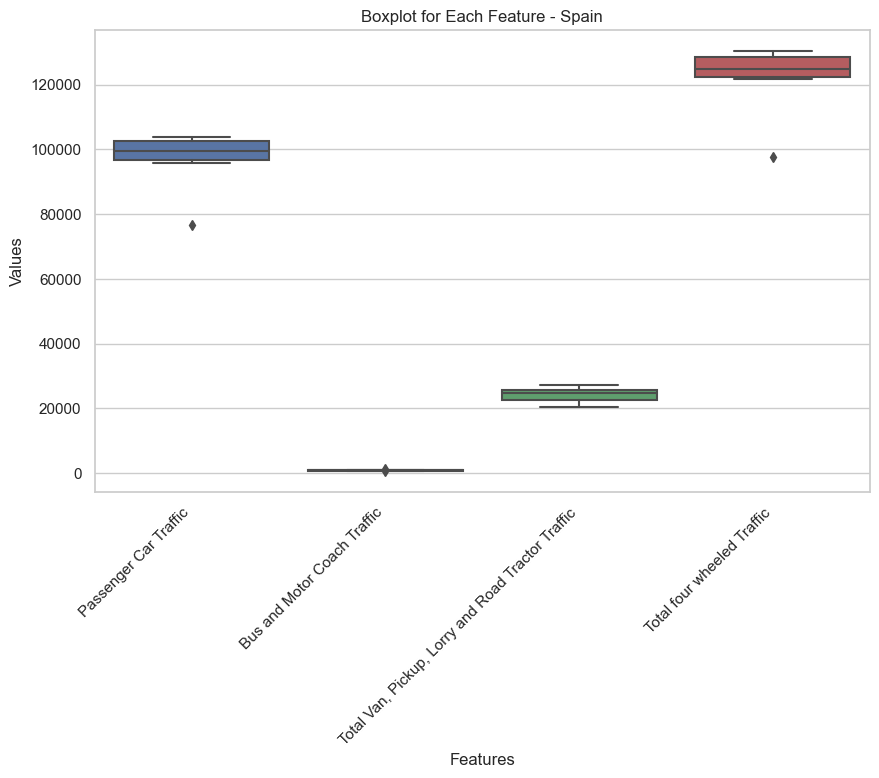

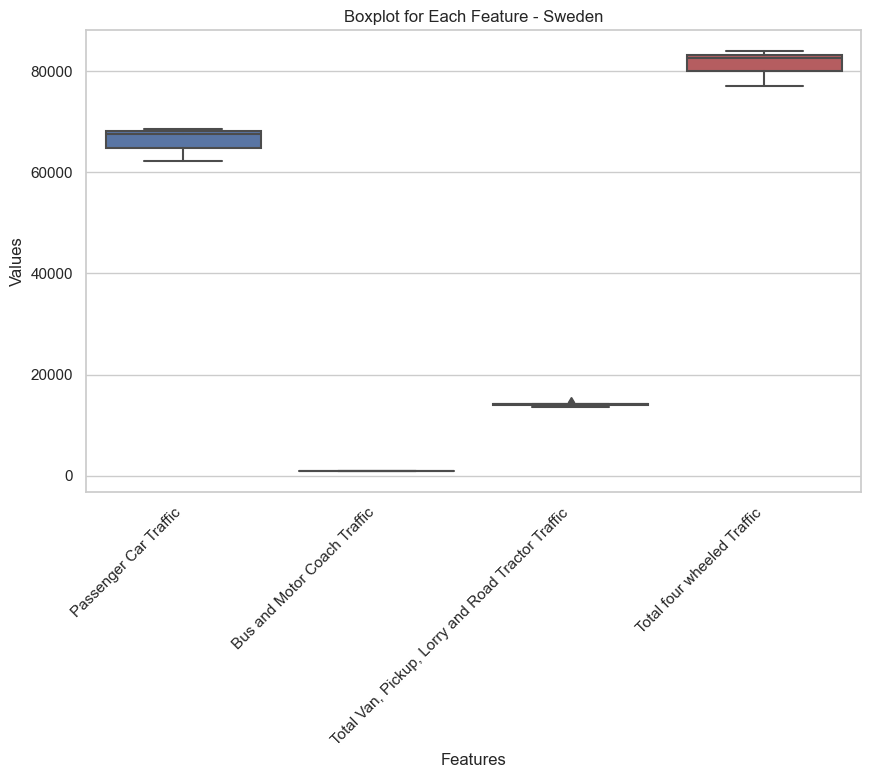

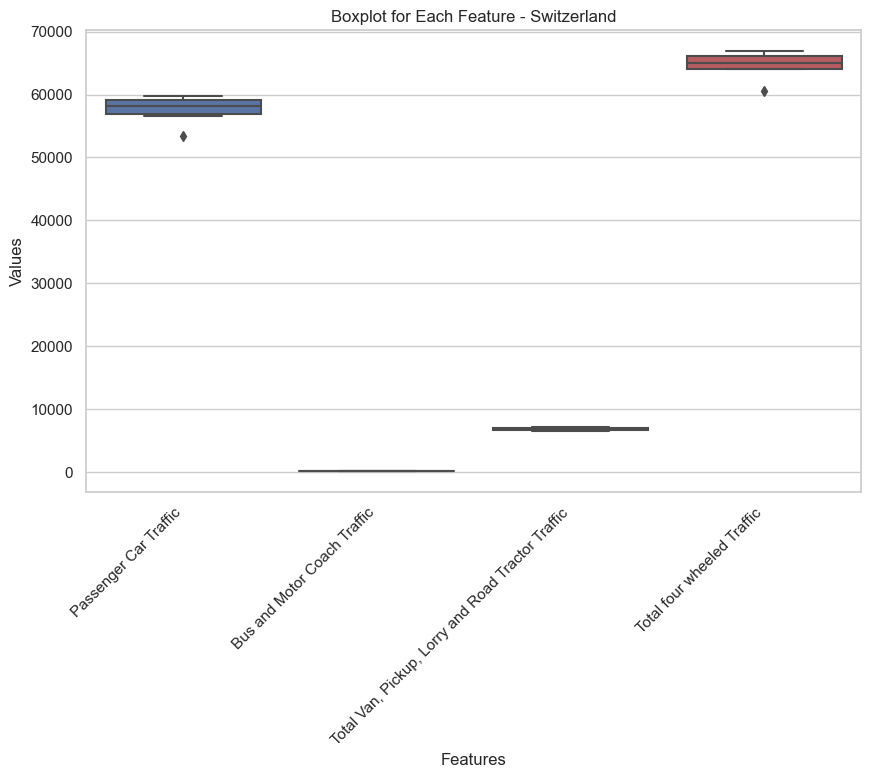

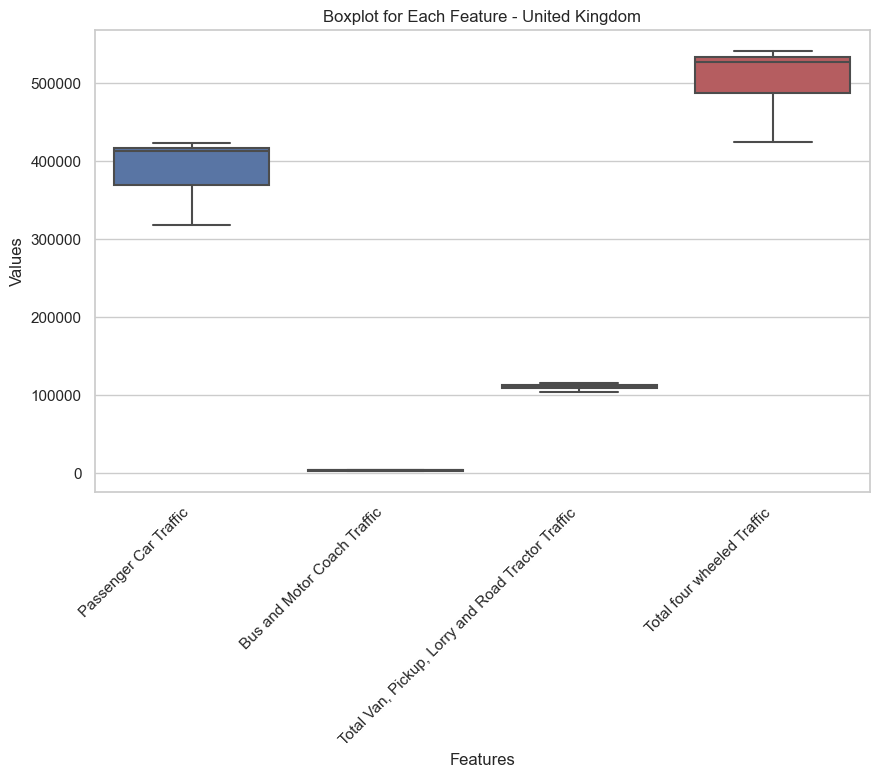

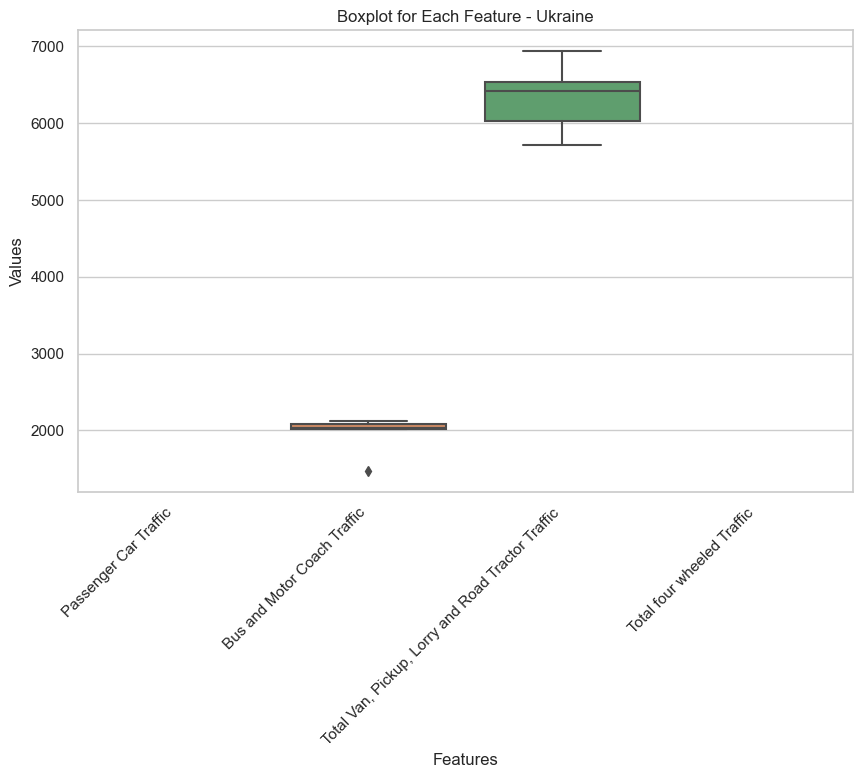

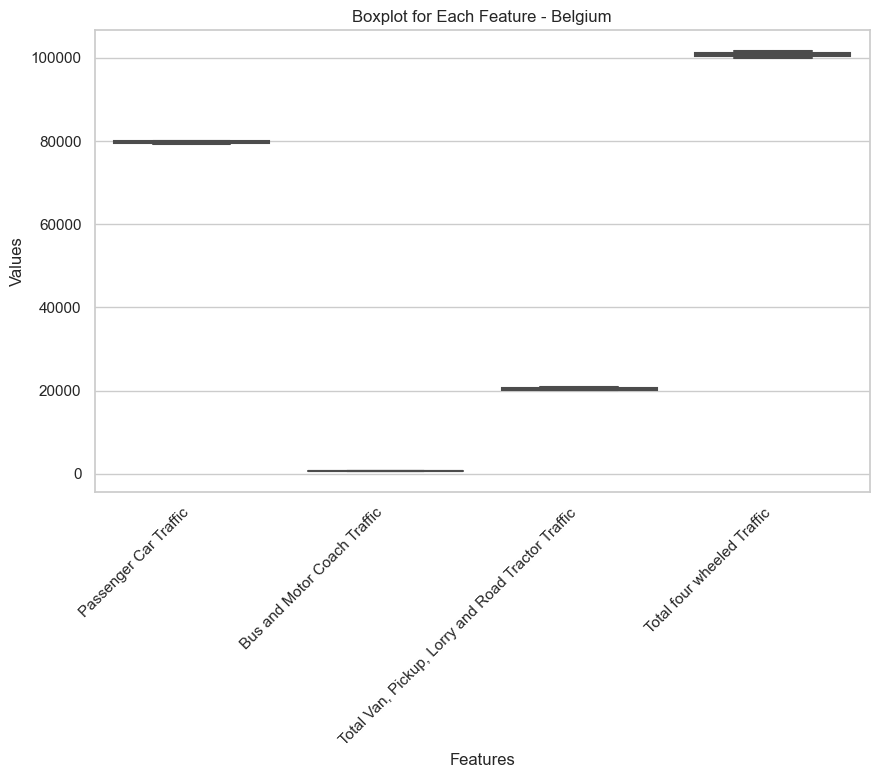

In [10]:
sns.set(style="whitegrid")  # Set the style of the visualization

# Selecting the relevant columns for boxplot
boxplot_data = df.iloc[:,:-1]

# Get unique categories
categories = df['Category'].unique()

# Create a separate boxplot for each category
for category in categories:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_data[boxplot_data["Category"] == category].iloc[:,1:]))
    plt.title(f"Boxplot for Each Feature - {category}")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()

Looking at previous graphs we can see that the following countries are the ones with either very visible outliers or multiple ones:
- Croatia
- Ireland
- Latvia
- North Macedonia
- Portugal
- Russian Federation
- Serbia
- Slovak Republic
- Slovenia
- Spain

Our EDA analysis was helpful in defyining actions needed to solve the following problems:
- Missing values
- Scaling of data
- Outliers

#### ●	Taking into consideration the tasks required in the machine learning section, use appropriate data cleaning, engineering, extraction and/or other techniques to structure and enrich your data. Rationalize your decisions and implementation, including evidence of how your process has addressed the problems identified in the EDA (Exploratory Data Analysis) stage and how your structured data will assist in the analysis stage. This should include visualizations to illustrate your work and evidence to support your methodology.[0-30]

From previous analysis we realized there are multiple things we need to work on.

Let's work on the features scaling and let's do a quick head of the dataframe to better explain the importance of this point:

In [11]:
df.head()

Category  Passenger Car Traffic  Bus and Motor Coach Traffic  \
0   Austria                60721.0                        390.0   
1   Belarus                  244.0                        324.0   
2  Bulgaria                    NaN                        353.0   
3   Croatia                19780.0                        240.0   
4   Denmark                40313.0                        624.0   

   Total Van, Pickup, Lorry and Road Tractor Traffic  \
0                                            13810.0   
1                                              935.0   
2                                             2757.0   
3                                             3170.0   
4                                             9257.0   

   Total four wheeled Traffic  Year  
0                     74921.0  2021  
1                      1503.0  2021  
2                      3110.0  2021  
3                     23190.0  2021  
4                     50194.0  2021

If we look at data for Austria and Belarus in 2021, we can clearly see that the "Total four wheeled Traffic" is about 50 times bigger in Austria. This might be because of different reasons such as:
- Population size is different
- In one of the countries traffic data is not well represented with respect to the total population
- The development of a country may influence its vehicle traffic

For this reason, for our analysis, we want to consider the traffic % of vehicle categories with respect to the total four wheeled traffic of the specific country.

First of all, we want to make sure that the traffic sum of different vehicles type is equal to the four wheeled total:

In [12]:
# Sum traffic metrics of different vehicle types
df['Sum four wheeled Traffic'] = df['Passenger Car Traffic'] + df['Bus and Motor Coach Traffic'] + df['Total Van, Pickup, Lorry and Road Tractor Traffic']

# Check if the sum in the new column is equal to the values in column 4
df['Sum Check'] = df['Sum four wheeled Traffic'] == df['Total four wheeled Traffic']

# Store the rows where the sum is not equal to column 4
rows_with_mismatch = df[df['Sum Check'] == False]

Let's look at samples where we can see this miss match:

In [13]:
rows_with_mismatch

Category  Passenger Car Traffic  Bus and Motor Coach Traffic  \
2             Bulgaria                    NaN                        353.0   
8              Germany               582400.0                       2900.0   
13               Malta                 2290.0                         59.0   
16          Montenegro                    NaN                         13.0   
21            Portugal                    NaN                        403.0   
..                 ...                    ...                          ...   
19              Norway                34849.0                        569.0   
21            Portugal                    NaN                        451.0   
23  Russian Federation                    NaN                          NaN   
24     Slovak Republic                    NaN                          NaN   
29             Ukraine                    NaN                       2026.0   

    Total Van, Pickup, Lorry and Road Tractor Traffic  \
2                                              2757.0   
8                                             92600.0   
13                                              502.0   
16                                                NaN   
21                                                NaN   
..                                                ...   
19                                             9208.0   
21                                                NaN   
23                                            44837.0   
24                                             4017.0   
29                                             5719.0   

    Total four wheeled Traffic  Year  Sum four wheeled Traffic  Sum Check  
2                       3110.0  2021                       NaN      False  
8                     677800.0  2021                  677900.0      False  
13                      2852.0  2021                    2851.0      False  
16                         NaN  2021                       NaN      False  
21                         NaN  2021                       NaN      False  
..                         ...   ...                       ...        ...  
19                     44625.0  2016                   44626.0      False  
21                         NaN  2016                       NaN      False  
23                         NaN  2016                       NaN      False  
24                         NaN  2016                       NaN      False  
29                         NaN  2016                       NaN      False  

[69 rows x 8 columns]

We can immediatelly observe that in some case the "False" flag is caused by the presence of NaN values.

Let's replace those NaN values and repeat the calculation:

In [14]:
rows_with_mismatch.fillna(0, inplace=True)

# Reset the index to avoid duplicate labels
rows_with_mismatch.reset_index(drop=True, inplace=True)

rows_with_mismatch['Sum four wheeled Traffic'] = (
    rows_with_mismatch['Passenger Car Traffic'] +
    rows_with_mismatch['Bus and Motor Coach Traffic'] +
    rows_with_mismatch['Total Van, Pickup, Lorry and Road Tractor Traffic']
)

# Check if the sum in the new column is equal to the values in column 4
rows_with_mismatch['Sum Check'] = rows_with_mismatch['Sum four wheeled Traffic'] == rows_with_mismatch['Total four wheeled Traffic']

# Display the rows where the sum is not equal to column 4
rows_with_mismatch = rows_with_mismatch[rows_with_mismatch['Sum Check'] == False]


In [15]:
rows_with_mismatch

Category  Passenger Car Traffic  Bus and Motor Coach Traffic  \
1              Germany               582400.0                       2900.0   
2                Malta                 2290.0                         59.0   
3           Montenegro                    0.0                         13.0   
4             Portugal                    0.0                        403.0   
5              Romania                47249.0                       3862.0   
..                 ...                    ...                          ...   
64              Norway                34849.0                        569.0   
65            Portugal                    0.0                        451.0   
66  Russian Federation                    0.0                          0.0   
67     Slovak Republic                    0.0                          0.0   
68             Ukraine                    0.0                       2026.0   

    Total Van, Pickup, Lorry and Road Tractor Traffic  \
1                                             92600.0   
2                                               502.0   
3                                                 0.0   
4                                                 0.0   
5                                             10242.0   
..                                                ...   
64                                             9208.0   
65                                                0.0   
66                                            44837.0   
67                                             4017.0   
68                                             5719.0   

    Total four wheeled Traffic  Year  Sum four wheeled Traffic  Sum Check  
1                     677800.0  2021                  677900.0      False  
2                       2852.0  2021                    2851.0      False  
3                          0.0  2021                      13.0      False  
4                          0.0  2021                     403.0      False  
5                      61354.0  2021                   61353.0      False  
..                         ...   ...                       ...        ...  
64                     44625.0  2016                   44626.0      False  
65                         0.0  2016                     451.0      False  
66                         0.0  2016                   44837.0      False  
67                         0.0  2016                    4017.0      False  
68                         0.0  2016                    7745.0      False  

[63 rows x 8 columns]

With this operation we can clearly see that we reduced the samples from 69 to 63.

Given that numbers might be rounded, let's remove all samples where the difference between the already available sum and the calculated one is less than 1%:

In [16]:
# Set the percentage threshold
percentage_threshold = 1

# Calculate the absolute difference and percentage difference using .loc
rows_with_mismatch.loc[:, 'Absolute_Difference'] = rows_with_mismatch['Sum four wheeled Traffic'] - rows_with_mismatch['Total four wheeled Traffic']
rows_with_mismatch.loc[:, 'Percentage_Difference'] = (rows_with_mismatch['Absolute_Difference'] / rows_with_mismatch['Total four wheeled Traffic']) * 100

# Filter rows where the percentage difference is greater than or equal to the threshold using .loc
rows_with_mismatch = rows_with_mismatch.loc[rows_with_mismatch['Percentage_Difference'] >= percentage_threshold]

# Drop the additional columns used for calculations using .loc
rows_with_mismatch = rows_with_mismatch.drop(['Absolute_Difference', 'Percentage_Difference'], axis=1)

In [17]:
rows_with_mismatch

Category  Passenger Car Traffic  Bus and Motor Coach Traffic  \
3           Montenegro                    0.0                         13.0   
4             Portugal                    0.0                        403.0   
6   Russian Federation                    0.0                          0.0   
7               Serbia                    0.0                        135.0   
8      Slovak Republic                    0.0                          0.0   
15          Montenegro                    0.0                         10.0   
17            Portugal                    0.0                        308.0   
18  Russian Federation                    0.0                          0.0   
19              Serbia                    0.0                        167.0   
20     Slovak Republic                    0.0                          0.0   
22             Ukraine                    0.0                       1468.0   
31            Portugal                    0.0                        434.0   
32  Russian Federation                    0.0                          0.0   
33              Serbia                    0.0                        168.0   
34     Slovak Republic                    0.0                          0.0   
37             Ukraine                    0.0                       2117.0   
44            Portugal                    0.0                        482.0   
45  Russian Federation                    0.0                          0.0   
46              Serbia                    0.0                        170.0   
47     Slovak Republic                    0.0                          0.0   
49             Ukraine                    0.0                       2084.0   
54            Portugal                    0.0                        455.0   
55  Russian Federation                    0.0                          0.0   
56              Serbia                    0.0                        160.0   
57     Slovak Republic                    0.0                          0.0   
59             Ukraine                    0.0                       2017.0   
65            Portugal                    0.0                        451.0   
66  Russian Federation                    0.0                          0.0   
67     Slovak Republic                    0.0                          0.0   
68             Ukraine                    0.0                       2026.0   

    Total Van, Pickup, Lorry and Road Tractor Traffic  \
3                                                 0.0   
4                                                 0.0   
6                                             23280.0   
7                                                 0.0   
8                                              3634.0   
15                                                0.0   
17                                                0.0   
18                                            23444.0   
19                                                0.0   
20                                             3974.0   
22                                             6935.0   
31                                                0.0   
32                                            20037.0   
33                                                0.0   
34                                             4167.0   
37                                             6538.0   
44                                                0.0   
45                                            18607.0   
46                                                0.0   
47                                             3997.0   
49                                             6418.0   
54                                                0.0   
55                                            21750.0   
56                                                0.0   
57                                             4317.0   
59                                             6031.0   
65                                                0.0   

In [18]:
rows_with_mismatch.shape

(30, 8)

We can now see that we are left with only with samples where "Total four wheeled Traffic" had originally a nan value. We thus want to make sure that first of all those samples are deleted from our dataframe:

In [19]:
# Remove samples where Total four wheeled Traffic is null 
df.dropna(subset=['Total four wheeled Traffic'], inplace=True)

In [20]:
df.shape

(158, 8)

We can see that the dataset is now dropped from 188 to 158, exactly 30 samples.

Let's now see how many other samples are left with null values:

In [21]:
# Show samples where there are null values
df[df.isnull().any(axis=1)]

Category  Passenger Car Traffic  Bus and Motor Coach Traffic  \
2  Bulgaria                    NaN                        353.0   
2  Bulgaria                    NaN                        329.0   
2  Bulgaria                    NaN                        614.0   
2  Bulgaria                    NaN                        574.0   
3  Bulgaria                    NaN                        560.0   
3  Bulgaria                    NaN                        578.0   

   Total Van, Pickup, Lorry and Road Tractor Traffic  \
2                                             2757.0   
2                                             2458.0   
2                                             1638.0   
2                                             2121.0   
3                                             2739.0   
3                                             2831.0   

   Total four wheeled Traffic  Year  Sum four wheeled Traffic  Sum Check  
2                      3110.0  2021                       NaN      False  
2                      2787.0  2020                       NaN      False  
2                      2252.0  2019                       NaN      False  
2                      2695.0  2018                       NaN      False  
3                      3299.0  2017                       NaN      False  
3                      3409.0  2016                       NaN      False

As Bulgaria is the only country with NaN values, we decide to drop it:

In [22]:
# We drop all samples that have null vlues
df.dropna(inplace=True)

In [23]:
# We get current size of the dataframe df
df.shape

(152, 8)

Now, for the traffic by vehicle type column, we can get the % value with respect to the total traffic:

In [24]:
# % calculation
for i in df.iloc[:, 1:-4].columns:
    df[i] = (df[i]/df["Total four wheeled Traffic"])*100

Now that we have the % values, we can remove the following columns:
- Total four wheeled Traffic
- Sum four wheeled Traffic
- Sum Check

In [25]:
columns_to_delete = ['Total four wheeled Traffic', 'Sum four wheeled Traffic', 'Sum Check']

# Delete specified columns using del
for column in columns_to_delete:
    del df[column]

This transformation allowed us to remove samples where we had null values for specific columns but what about countries that are missing samples for specific years (from 2016 to 2021)?

Let's identify them and fill the values with the mean of available data:

In [26]:
all_categories = df['Category'].unique()
all_years = range(2016, 2022)
ref_df = pd.DataFrame(list(product(all_categories, all_years)), columns=['Category', 'Year'])

# Merge the reference DataFrame with the original DataFrame
ref_df = pd.merge(ref_df, df, on=['Category', 'Year'], how='left')

# Calculate the mean for each category
category_means = ref_df.groupby('Category').transform('mean')

# Fill missing values with the corresponding mean for each category
ref_df.fillna(category_means, inplace=True)

df = ref_df

Let's now visualize the same graphs we used in EDA:

In [27]:
# Initialize Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='feature-selector',
        options=[{'label': col, 'value': col} for col in df.columns[2:]],
        value='Bus and Motor Coach Traffic',
        multi=False,
        style={'width': '50%'}
    ),
    dcc.Graph(id='traffic-bar-chart')
])

# Define callback to update the bar chart based on dropdown selection
@app.callback(
    Output('traffic-bar-chart', 'figure'),
    [Input('feature-selector', 'value')]
)
def update_bar_chart(selected_feature):
    df_grouped = df.groupby(["Category", "Year"]).sum().reset_index()
    fig = px.bar(df_grouped, x='Year', y=selected_feature, animation_frame='Category',
                 title=f'{selected_feature} by Year Over Categories')
    fig.update_layout(xaxis_title='Year', yaxis_title=selected_feature)
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

We have now resolved the problem of missing data, now we need to solve the outliers problem.

Let's first of all see if the situation has been improved so far:

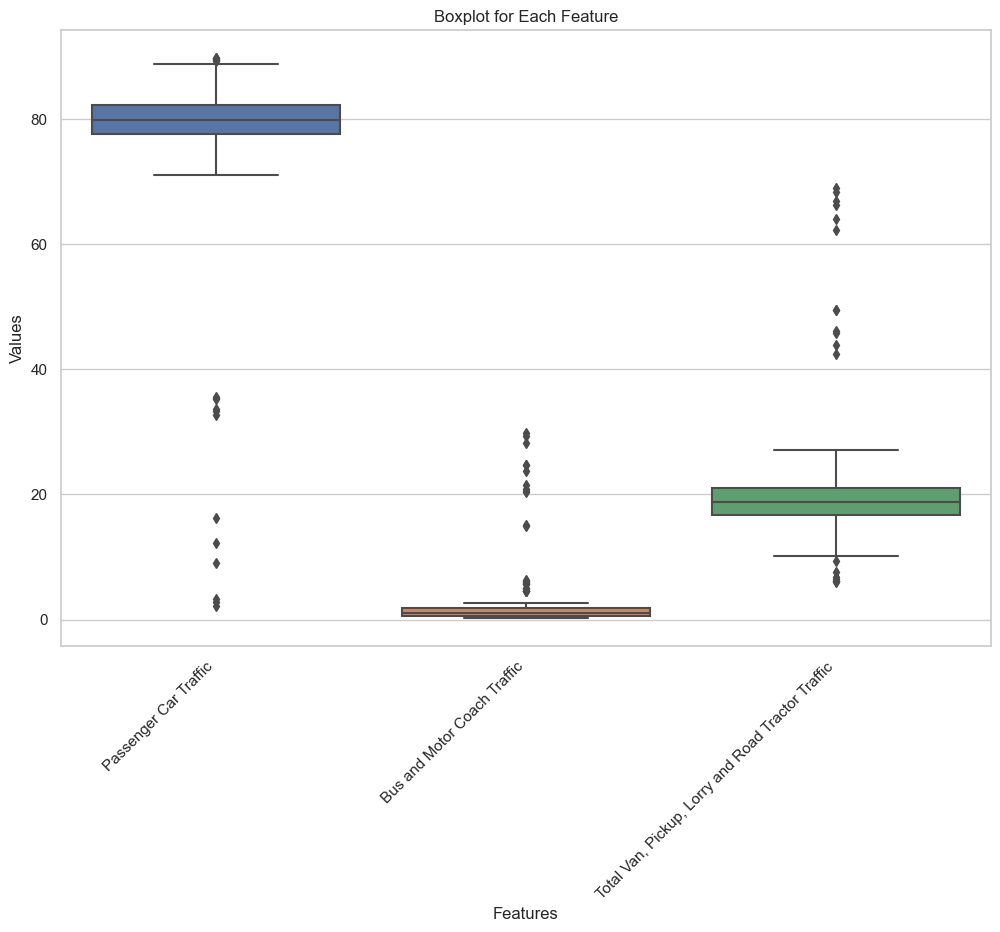

In [28]:
sns.set(style="whitegrid")  # Set the style of the visualization

# Selecting the relevant columns for boxplot
boxplot_data = df.drop(columns=['Category', 'Year'])

# Create a boxplot for each feature
plt.figure(figsize=(12, 8))
sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_data))
plt.title("Boxplot for Each Feature")
plt.xlabel("Features")
plt.ylabel("Values")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

If we look at the boxplot for each feature we see very different results after the feature transformation made so far. Let's see the same for the single countries: 

In [29]:
df

Category  Year  Passenger Car Traffic  Bus and Motor Coach Traffic  \
0    Austria  2016              83.652140                     0.619617   
1    Austria  2017              83.591761                     0.624007   
2    Austria  2018              83.096423                     0.601927   
3    Austria  2019              82.437615                     0.606359   
4    Austria  2020              81.747229                     0.521233   
..       ...   ...                    ...                          ...   
151  Belgium  2017              78.861532                     0.604688   
152  Belgium  2018              79.103826                     0.609194   
153  Belgium  2019              79.103826                     0.609194   
154  Belgium  2020              79.103826                     0.609194   
155  Belgium  2021              79.103826                     0.609194   

     Total Van, Pickup, Lorry and Road Tractor Traffic  
0                                            15.728243  
1                                            15.784232  
2                                            16.301651  
3                                            16.956026  
4                                            17.732909  
..                                                 ...  
151                                          20.532795  
152                                          20.286488  
153                                          20.286488  
154                                          20.286488  
155                                          20.286488  

[156 rows x 5 columns]

In [30]:
df.drop("Year", axis=1)

Category  Passenger Car Traffic  Bus and Motor Coach Traffic  \
0    Austria              83.652140                     0.619617   
1    Austria              83.591761                     0.624007   
2    Austria              83.096423                     0.601927   
3    Austria              82.437615                     0.606359   
4    Austria              81.747229                     0.521233   
..       ...                    ...                          ...   
151  Belgium              78.861532                     0.604688   
152  Belgium              79.103826                     0.609194   
153  Belgium              79.103826                     0.609194   
154  Belgium              79.103826                     0.609194   
155  Belgium              79.103826                     0.609194   

     Total Van, Pickup, Lorry and Road Tractor Traffic  
0                                            15.728243  
1                                            15.784232  
2                                            16.301651  
3                                            16.956026  
4                                            17.732909  
..                                                 ...  
151                                          20.532795  
152                                          20.286488  
153                                          20.286488  
154                                          20.286488  
155                                          20.286488  

[156 rows x 4 columns]

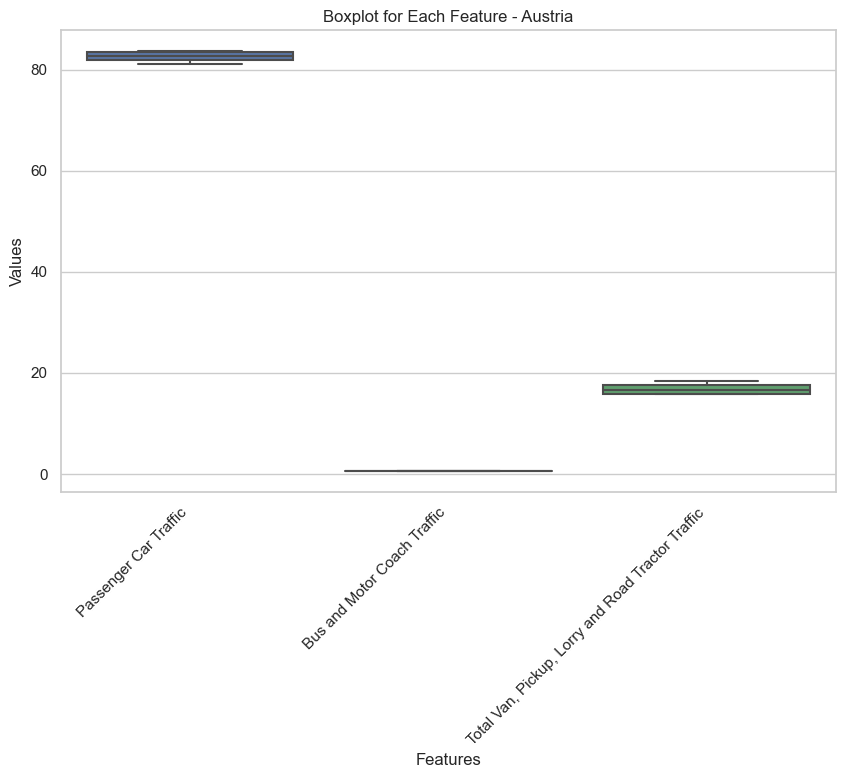

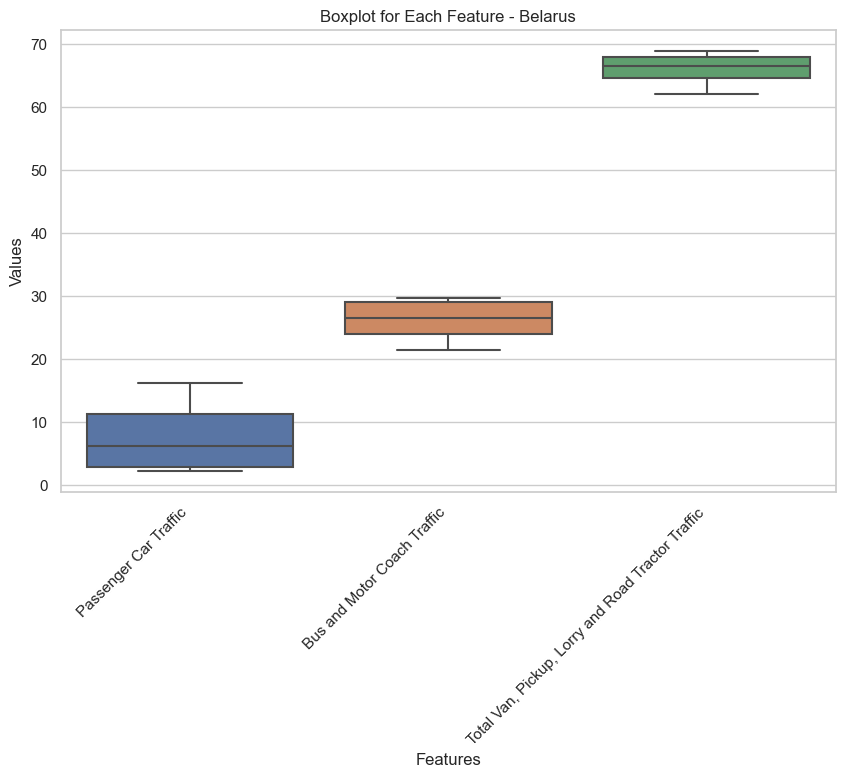

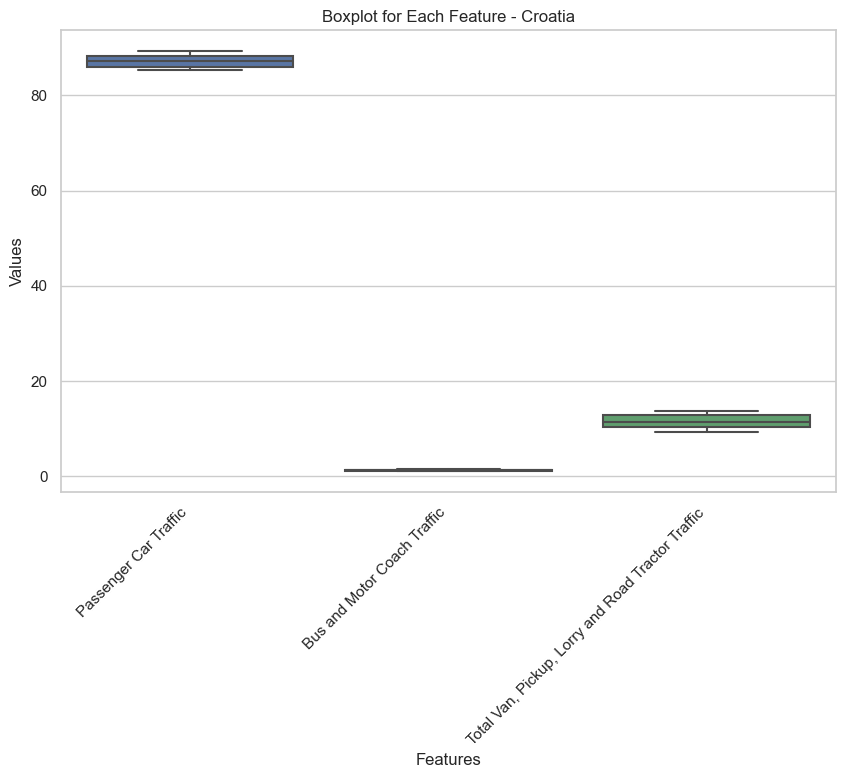

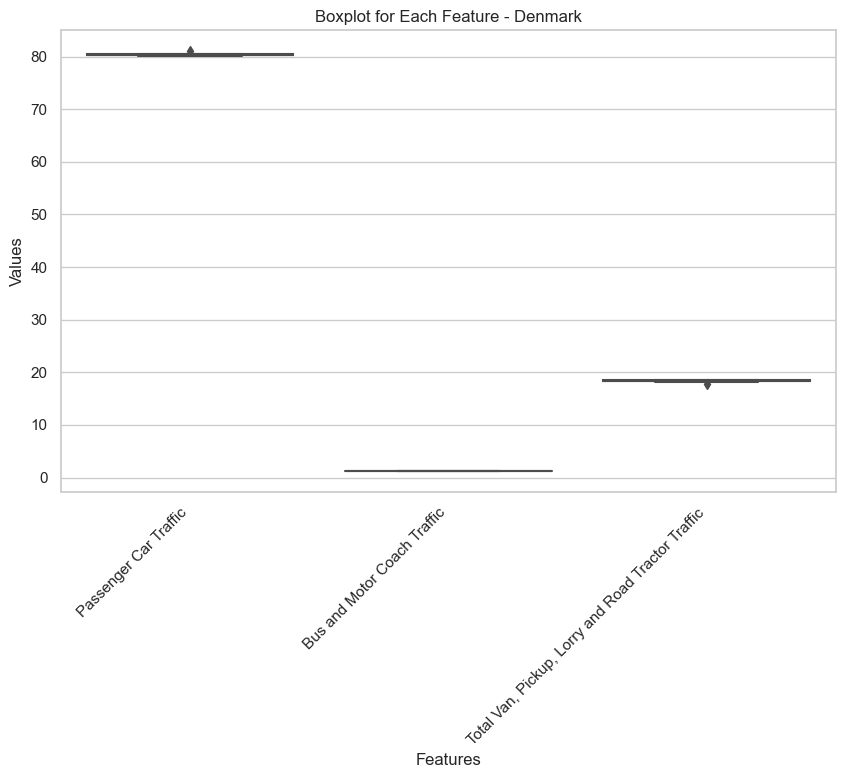

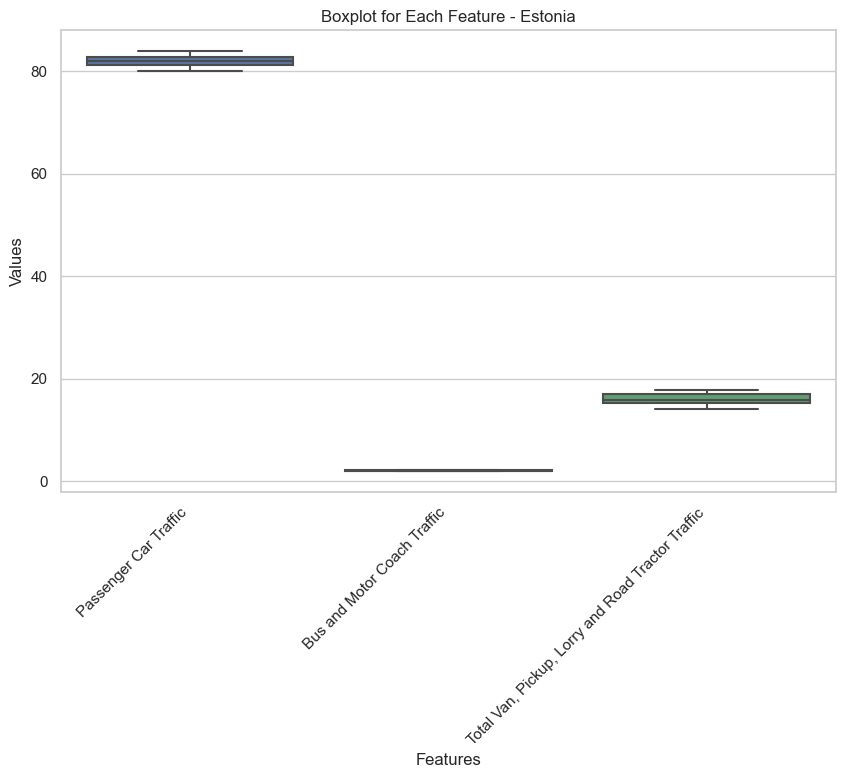

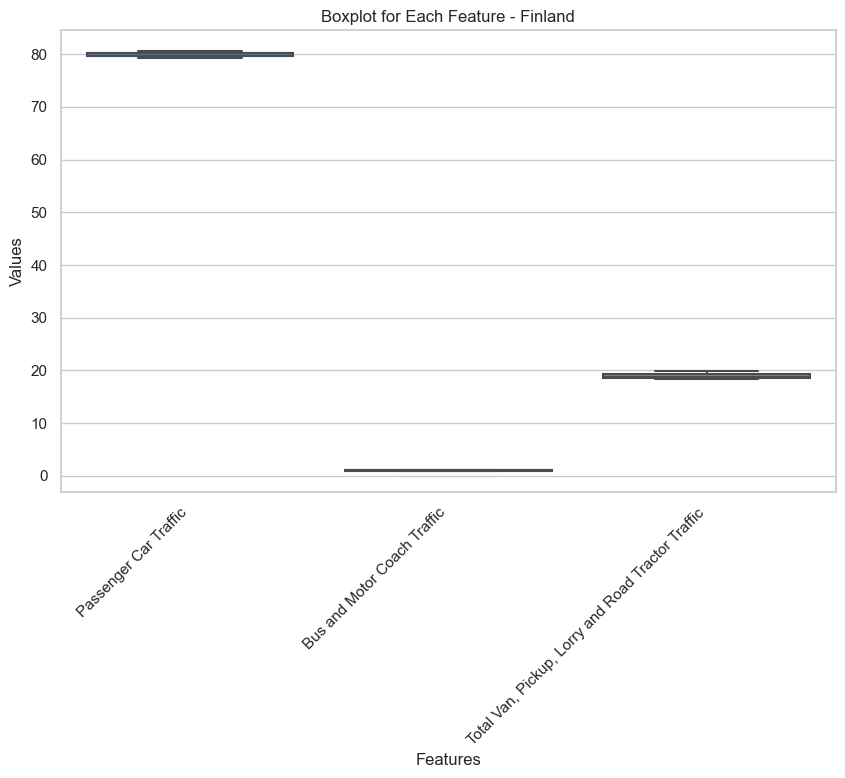

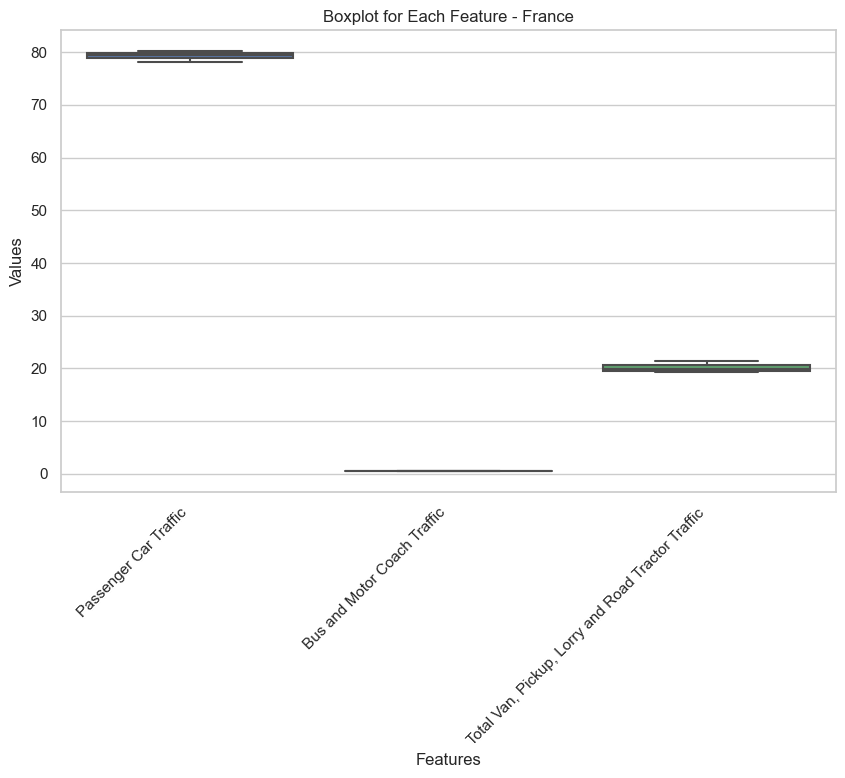

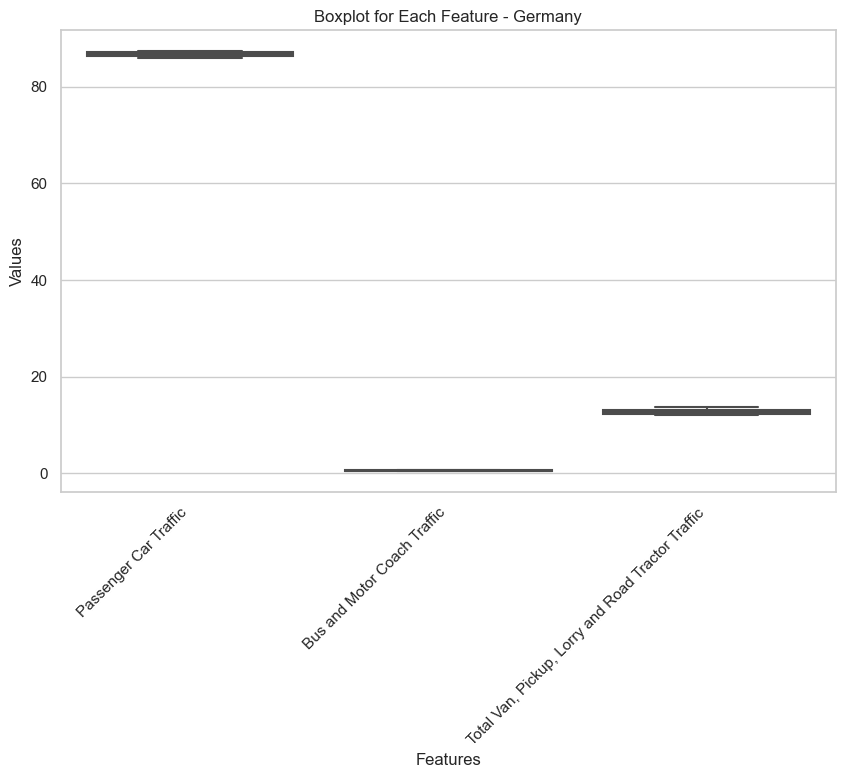

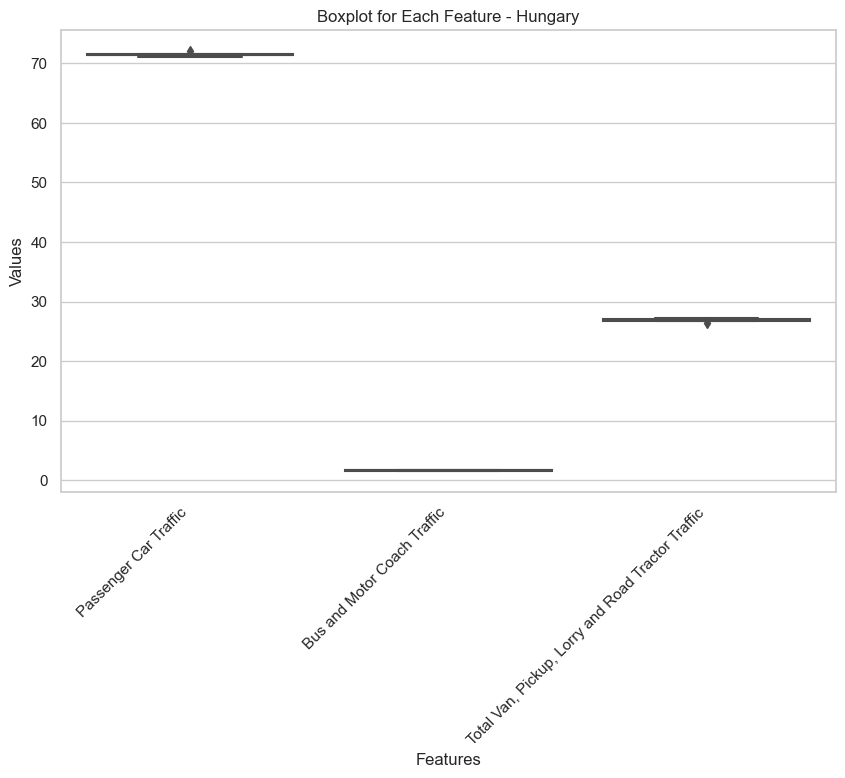

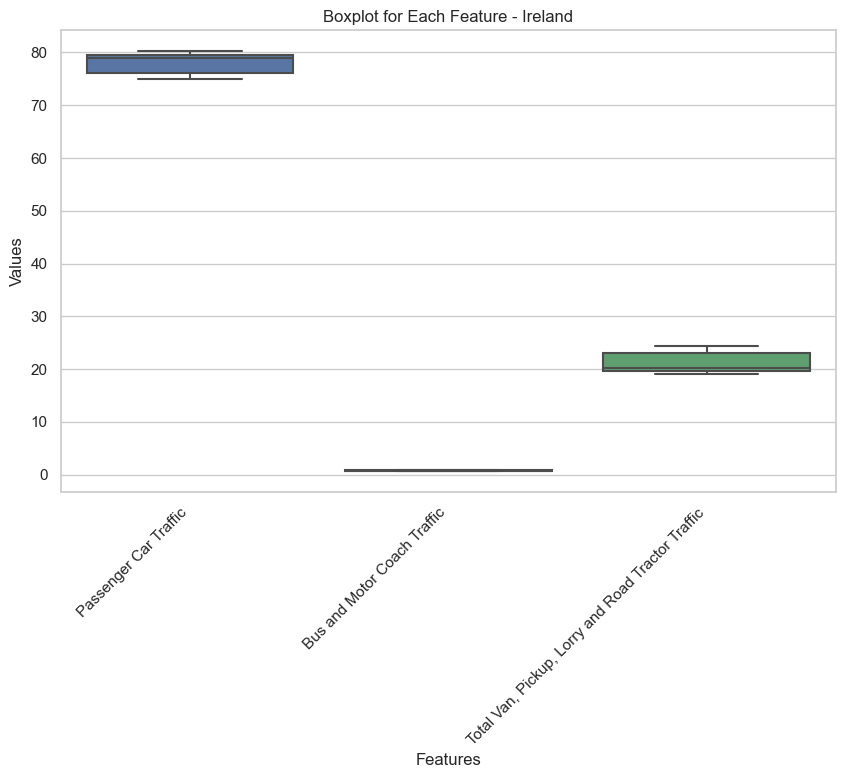

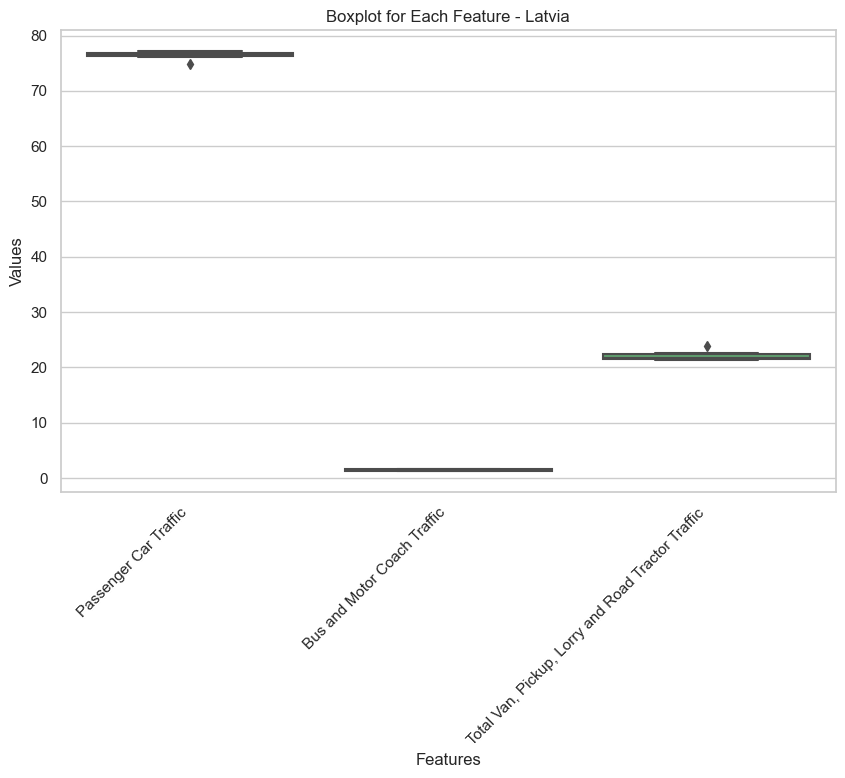

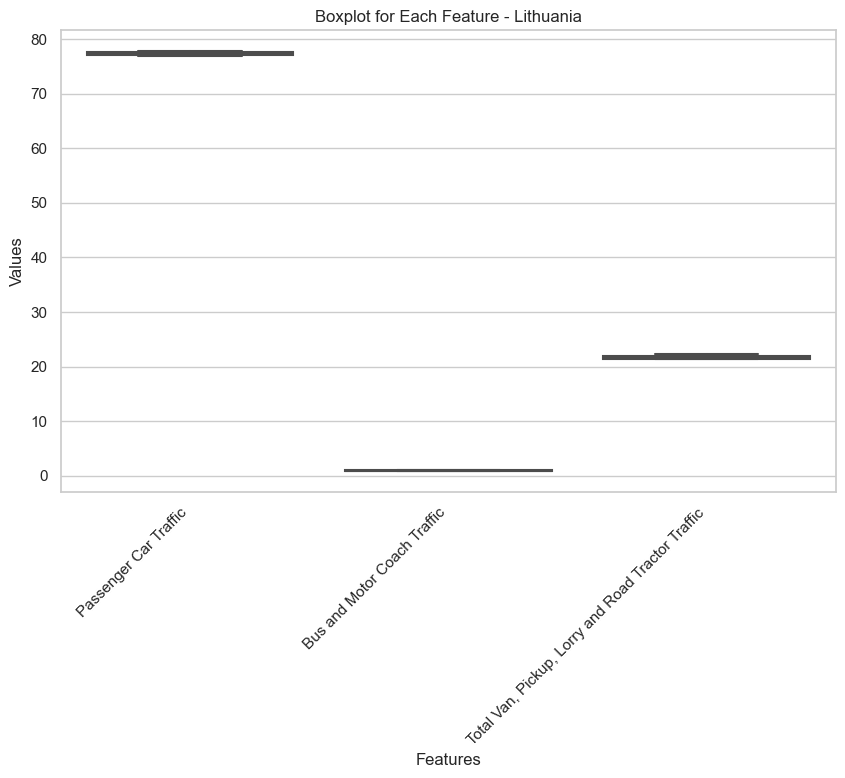

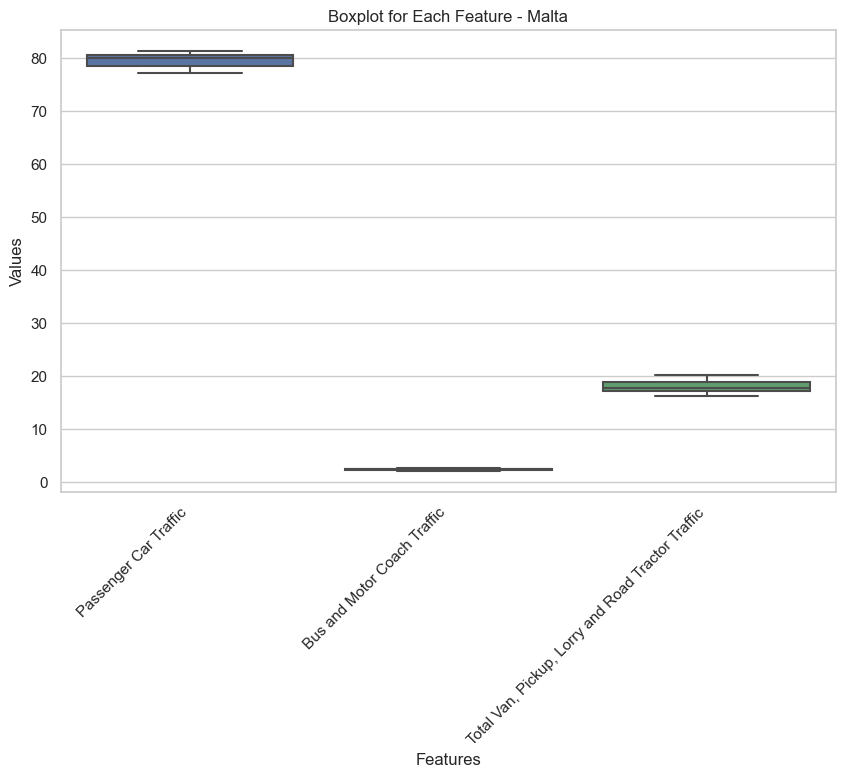

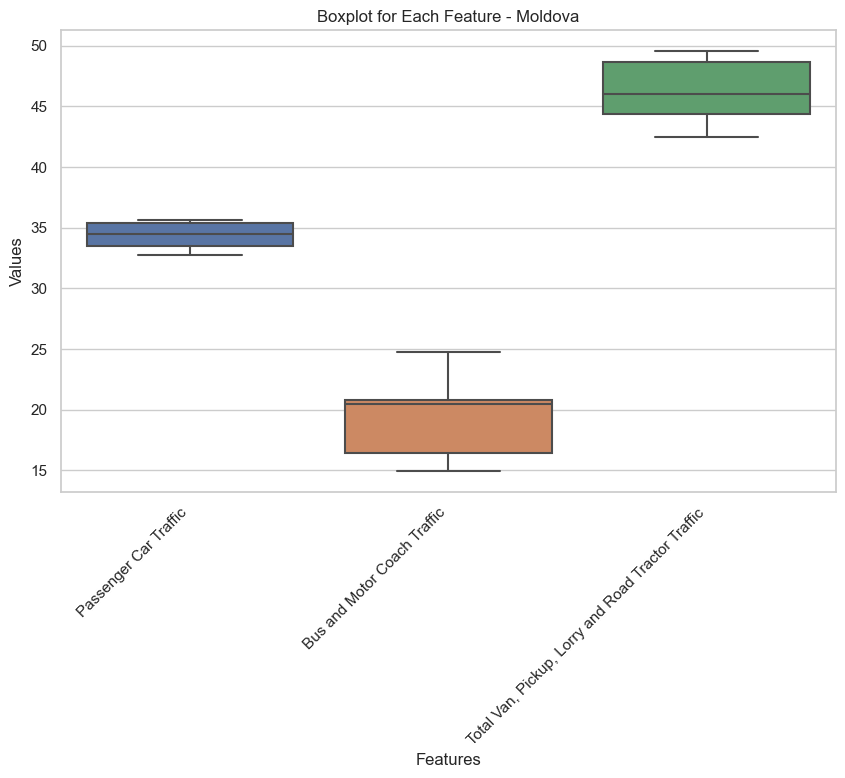

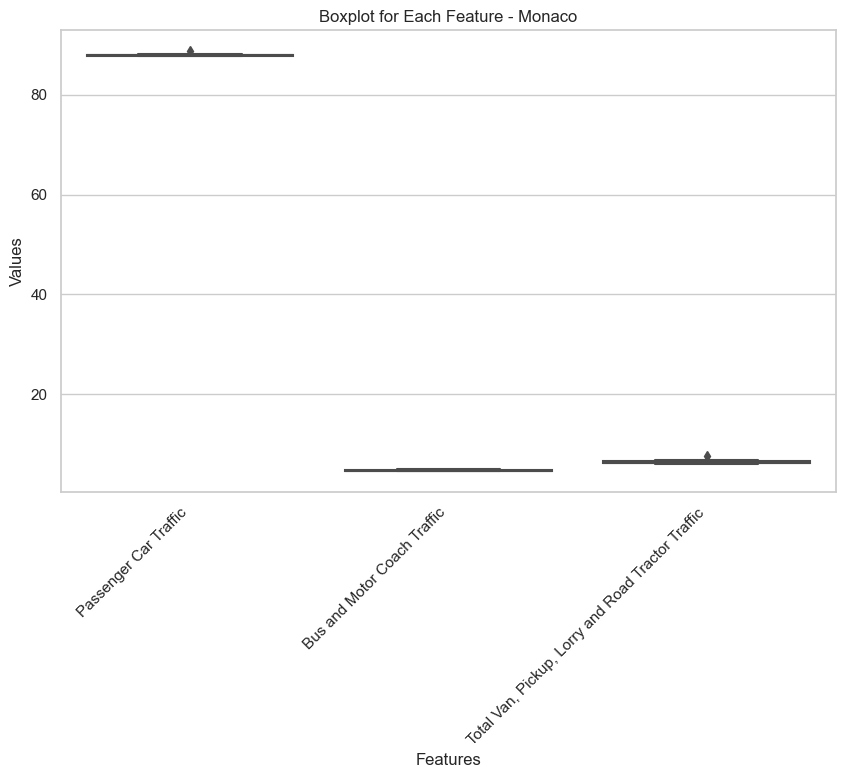

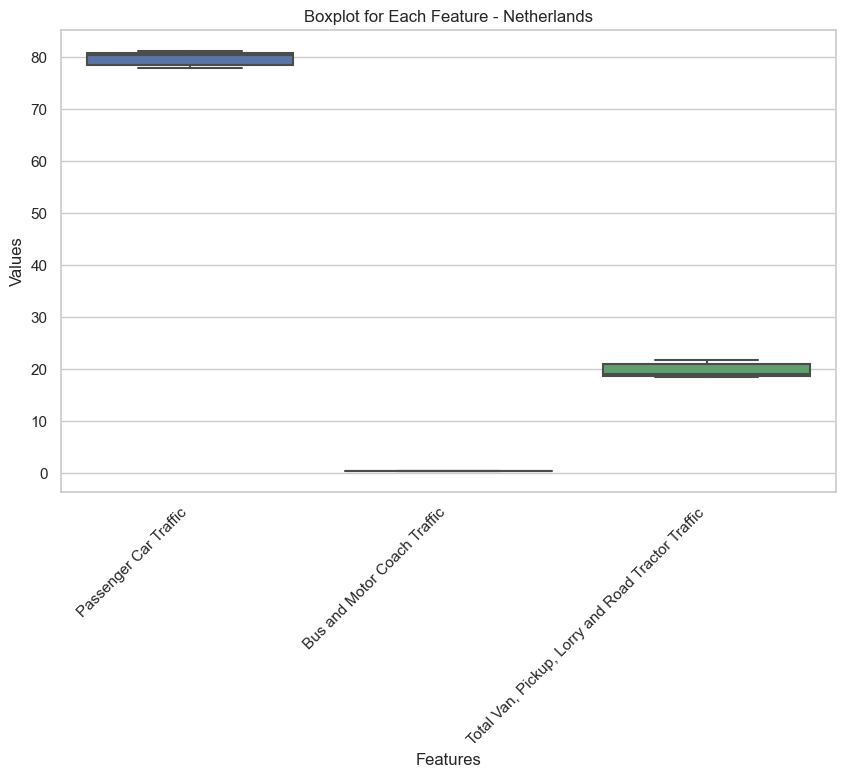

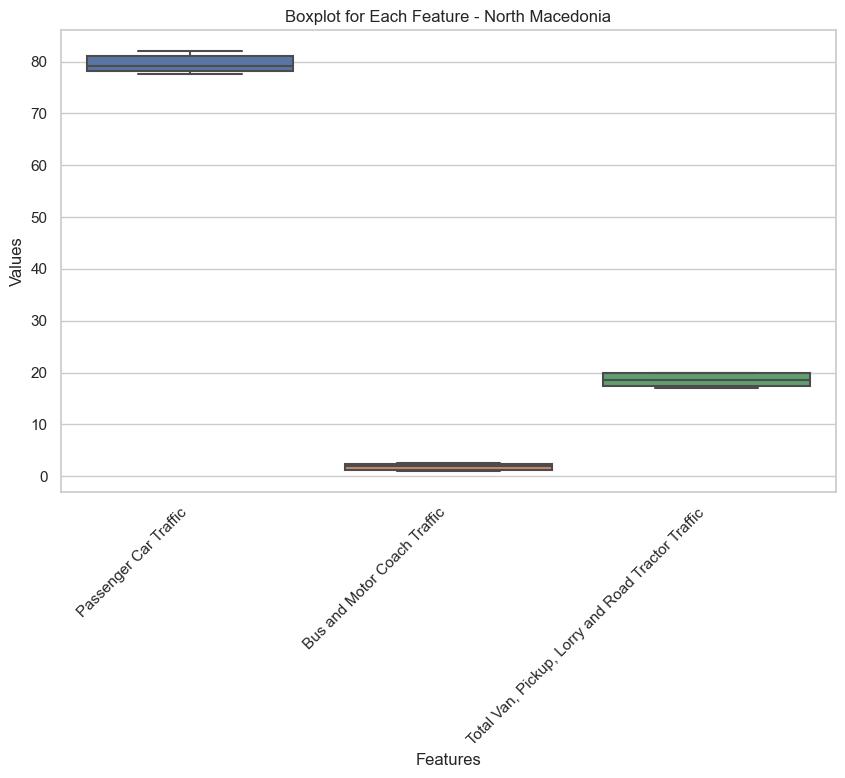

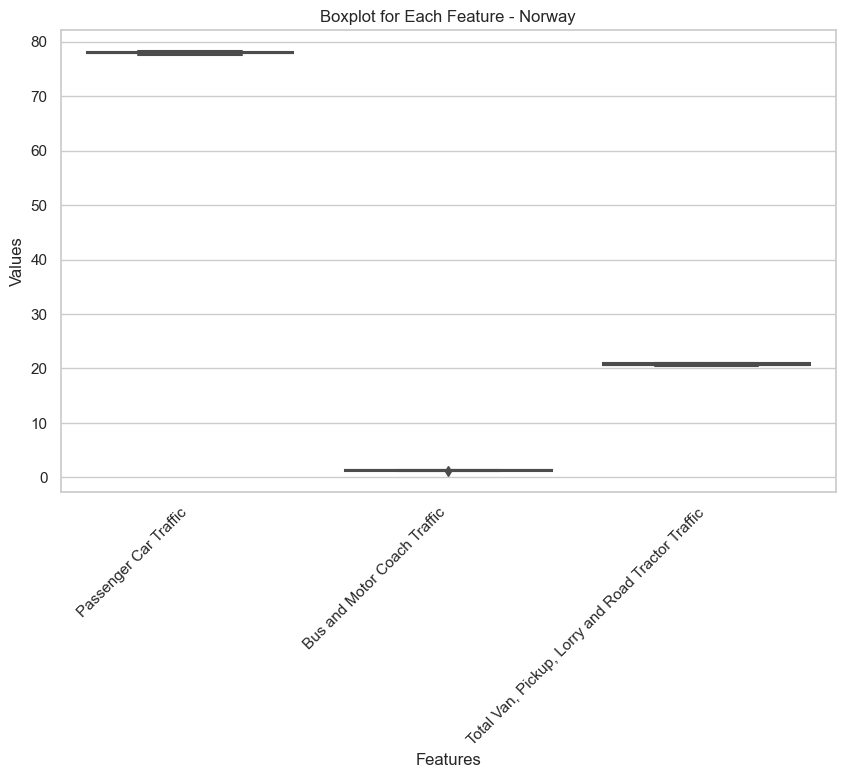

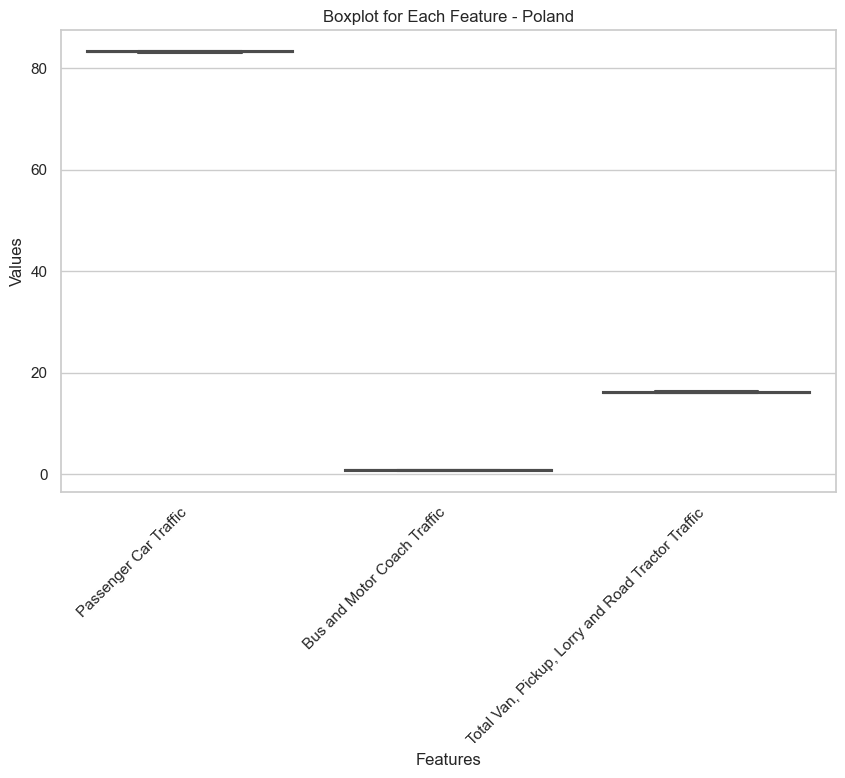

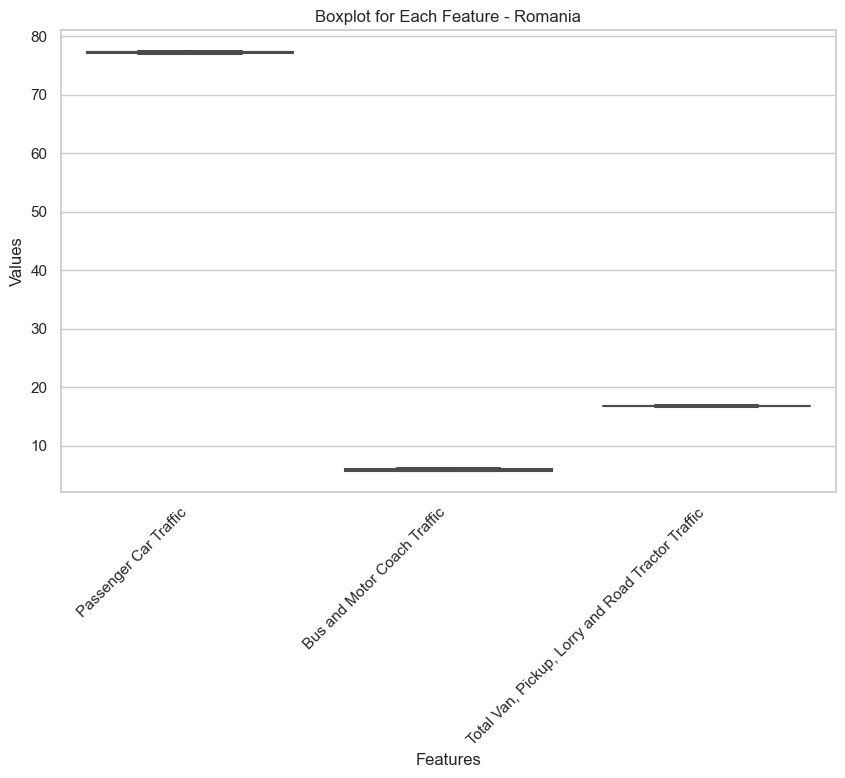

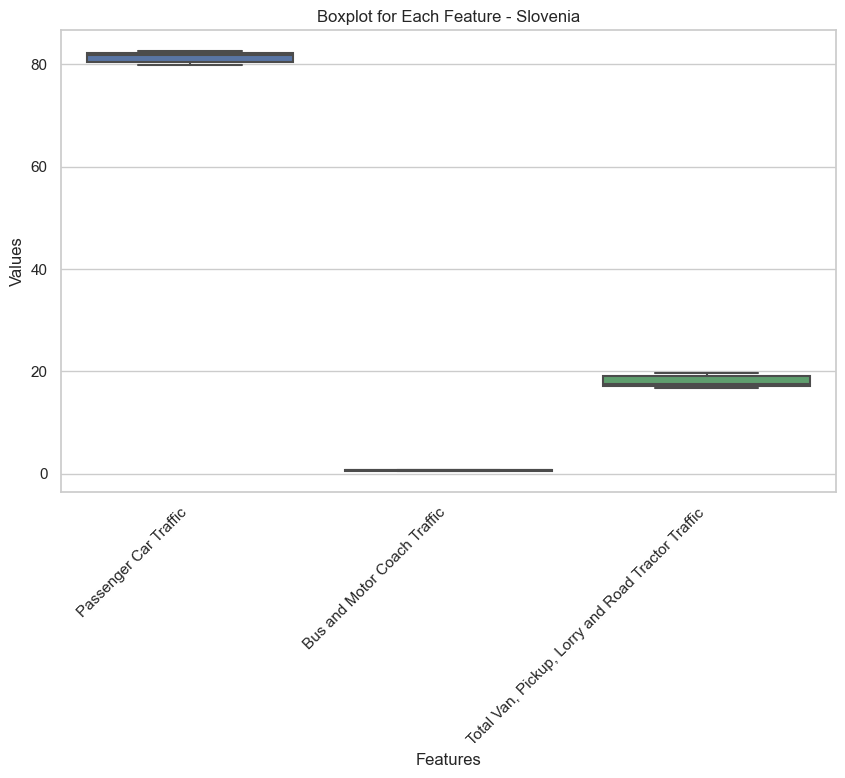

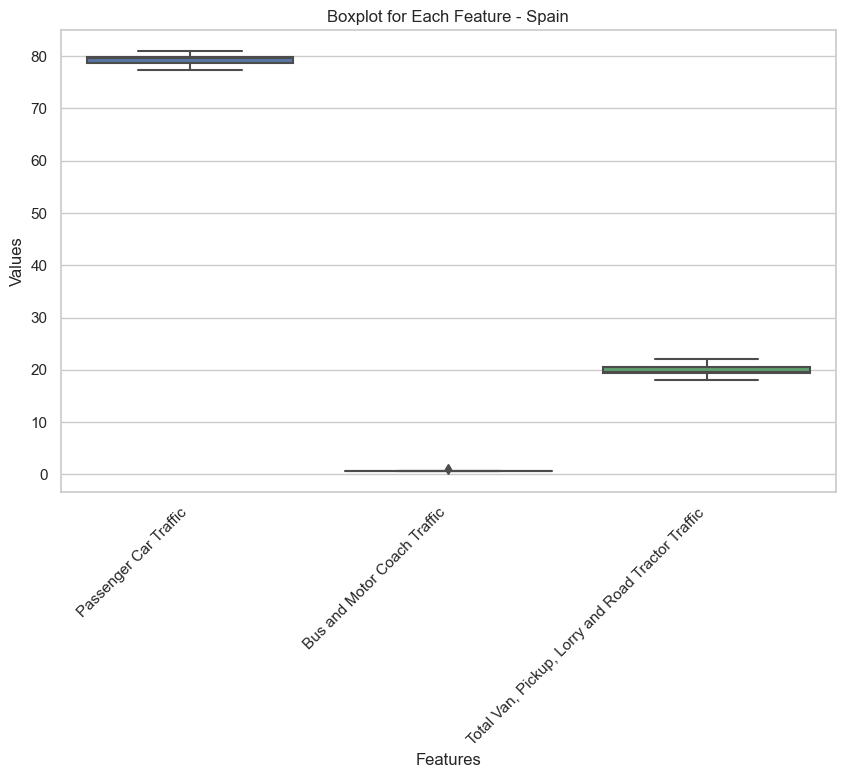

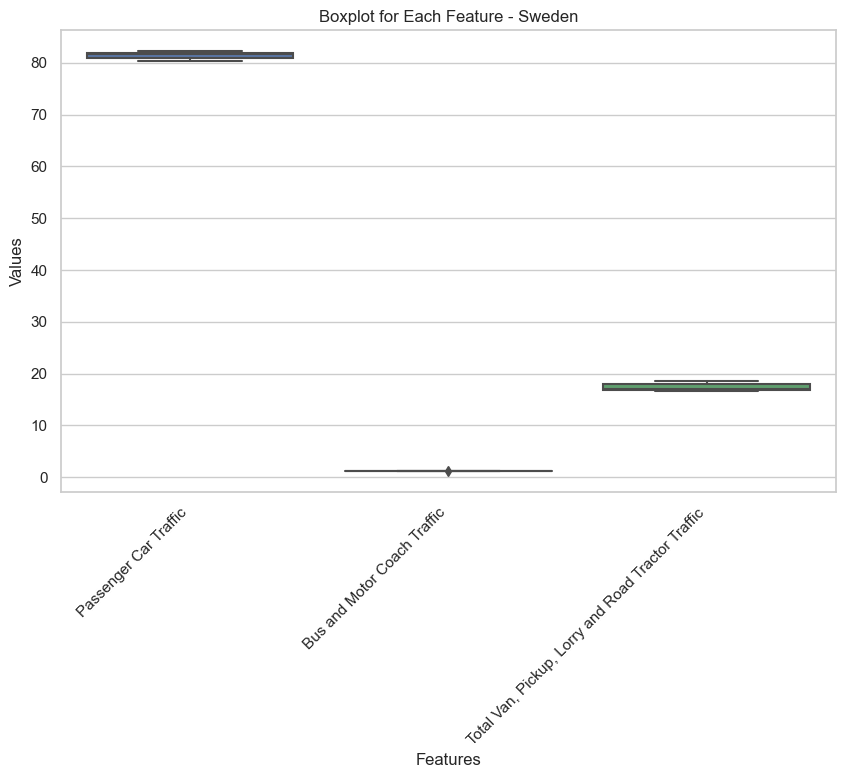

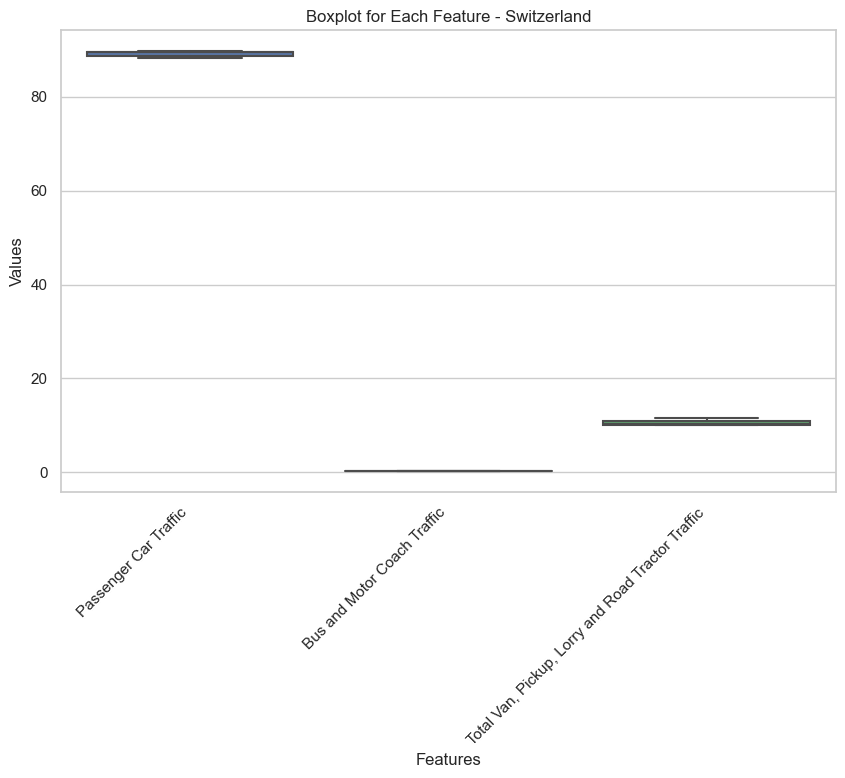

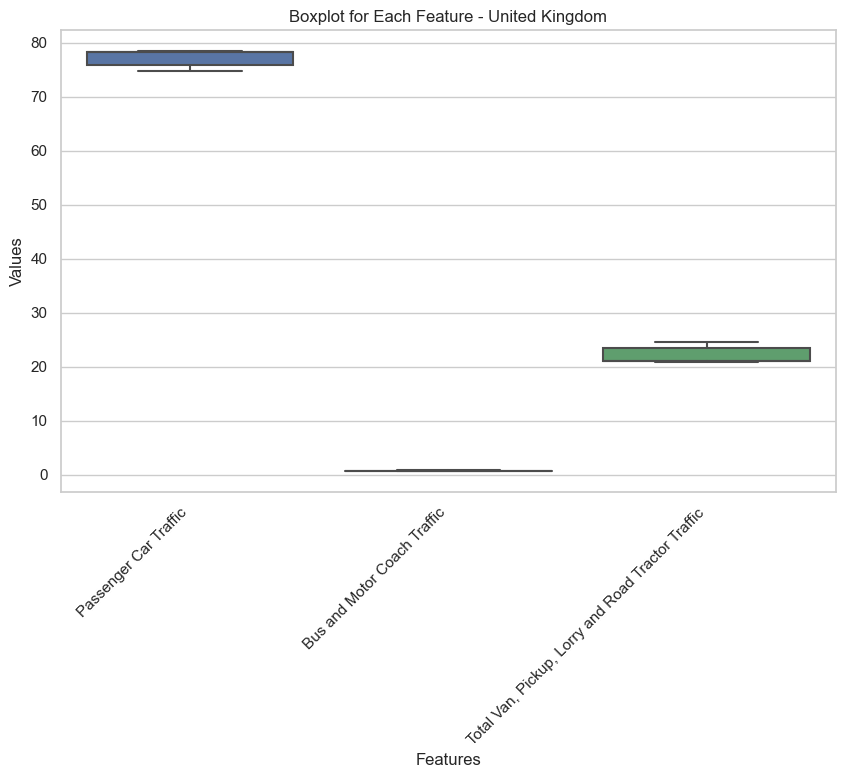

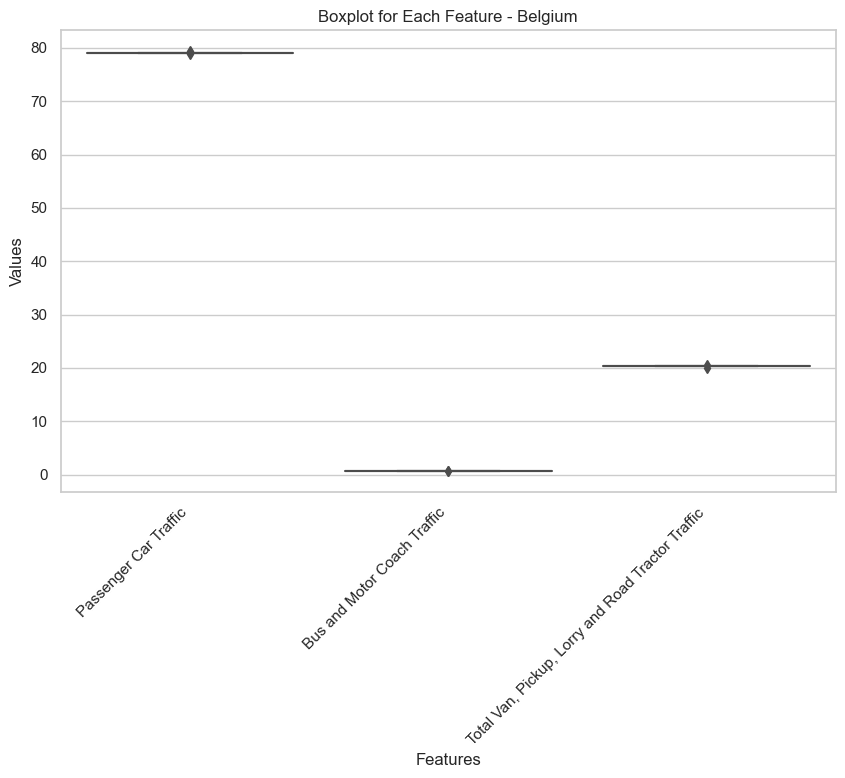

In [31]:
sns.set(style="whitegrid")  # Set the style of the visualization

# Selecting the relevant columns for boxplot
boxplot_data = df.drop("Year", axis=1)

# Get unique categories
categories = df['Category'].unique()

# Create a separate boxplot for each category
for category in categories:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_data[boxplot_data["Category"] == category].iloc[:,1:]))
    plt.title(f"Boxplot for Each Feature - {category}")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()

Results seems to be improved very much.

As the data is now between 0 and 100 (given that we are talking about %) it would make sense to also scale the dataset using MinMaxScales:

In [32]:
# Specify the columns to be scaled
columns_to_scale = ['Passenger Car Traffic', 'Bus and Motor Coach Traffic', 'Total Van, Pickup, Lorry and Road Tractor Traffic']

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit and transform only the specified columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [33]:
df

Category  Year  Passenger Car Traffic  Bus and Motor Coach Traffic  \
0    Austria  2016               0.930971                     0.013921   
1    Austria  2017               0.930281                     0.014069   
2    Austria  2018               0.924616                     0.013323   
3    Austria  2019               0.917082                     0.013473   
4    Austria  2020               0.909188                     0.010596   
..       ...   ...                    ...                          ...   
151  Belgium  2017               0.876188                     0.013416   
152  Belgium  2018               0.878959                     0.013568   
153  Belgium  2019               0.878959                     0.013568   
154  Belgium  2020               0.878959                     0.013568   
155  Belgium  2021               0.878959                     0.013568   

     Total Van, Pickup, Lorry and Road Tractor Traffic  
0                                             0.153818  
1                                             0.154708  
2                                             0.162941  
3                                             0.173352  
4                                             0.185713  
..                                                 ...  
151                                           0.230261  
152                                           0.226342  
153                                           0.226342  
154                                           0.226342  
155                                           0.226342  

[156 rows x 5 columns]

And let's visualize again the box-plots:

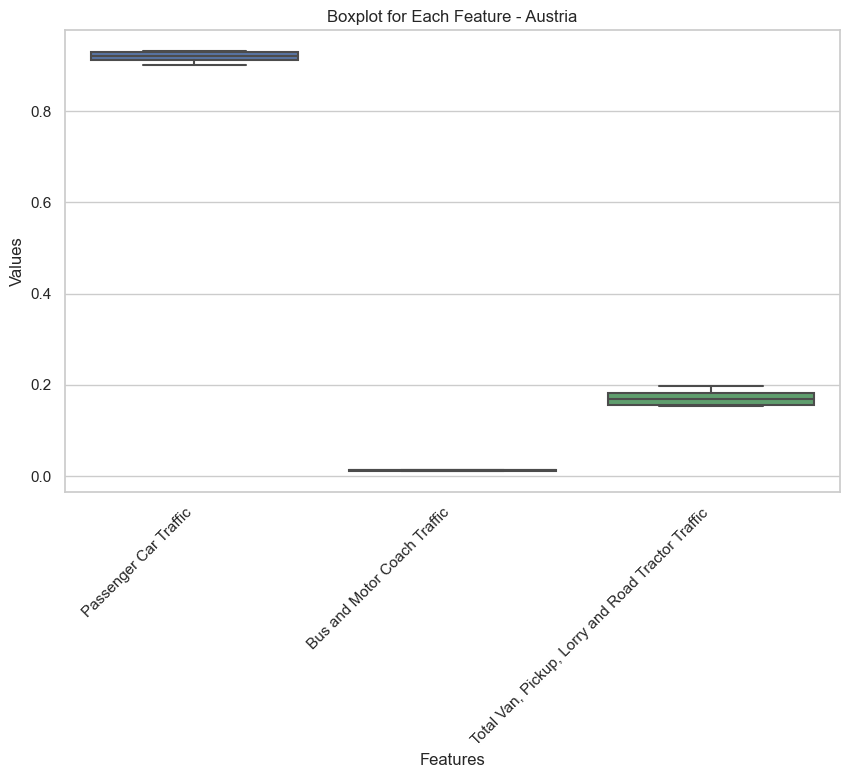

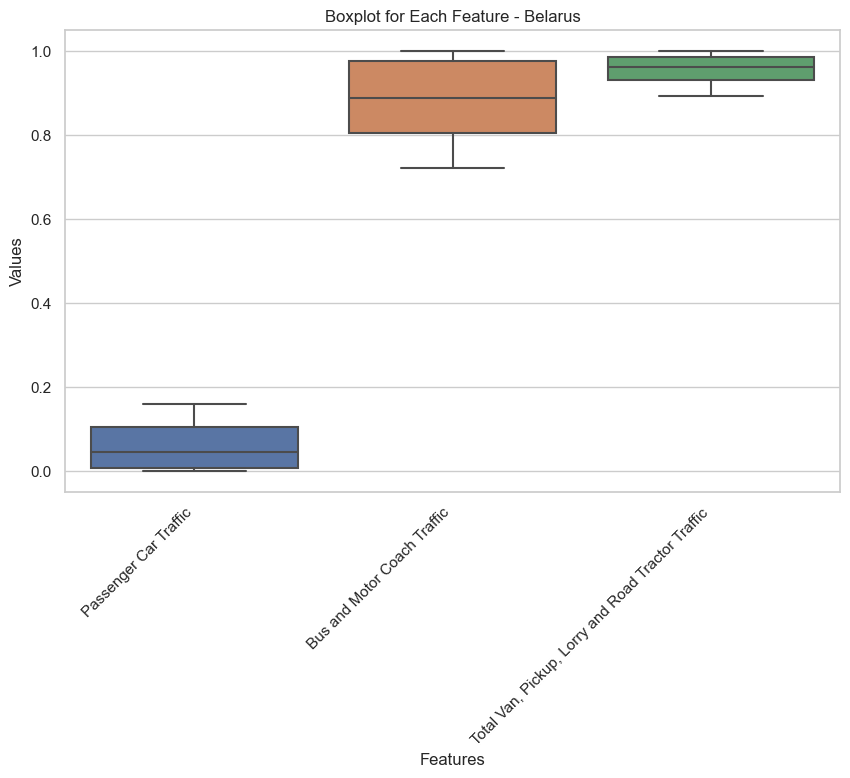

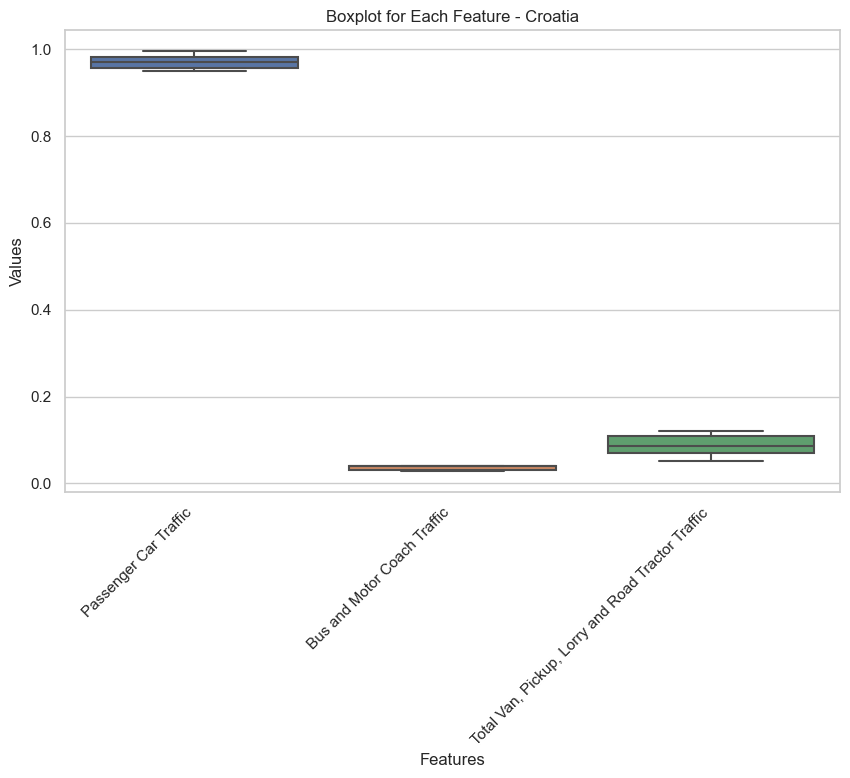

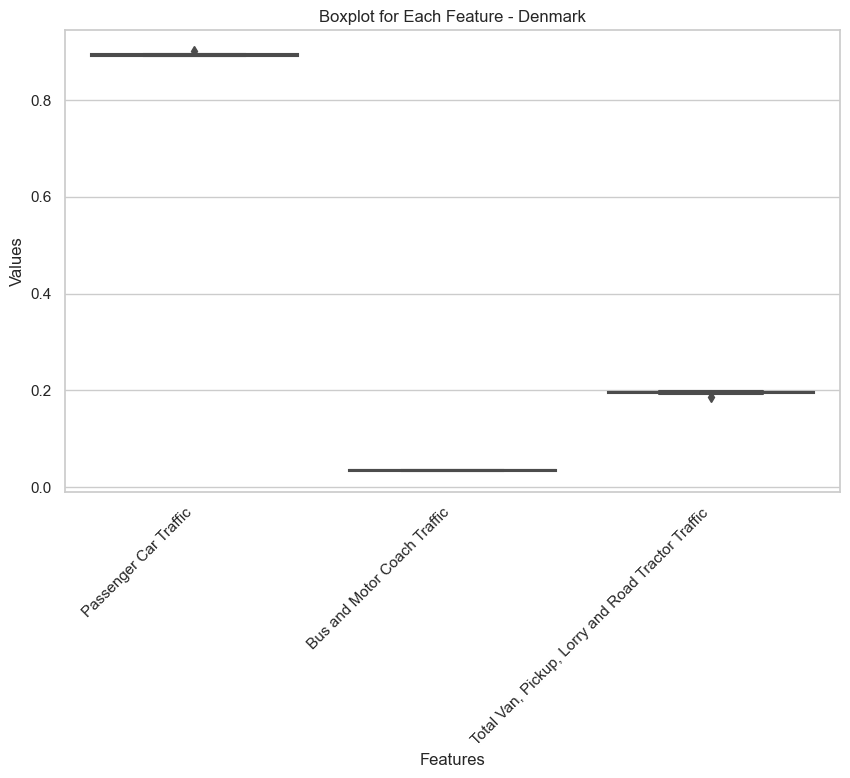

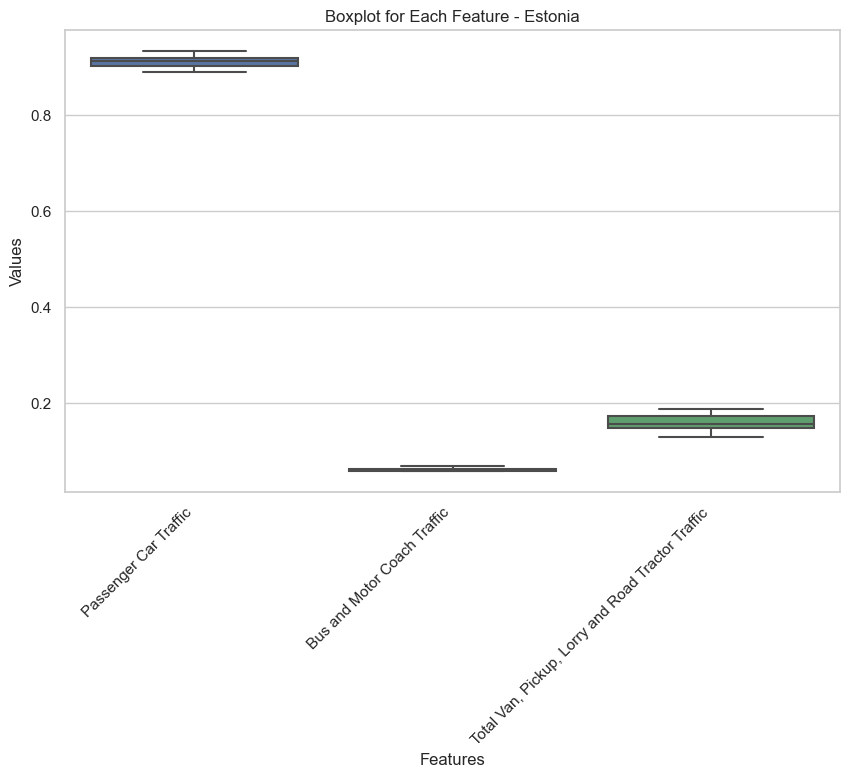

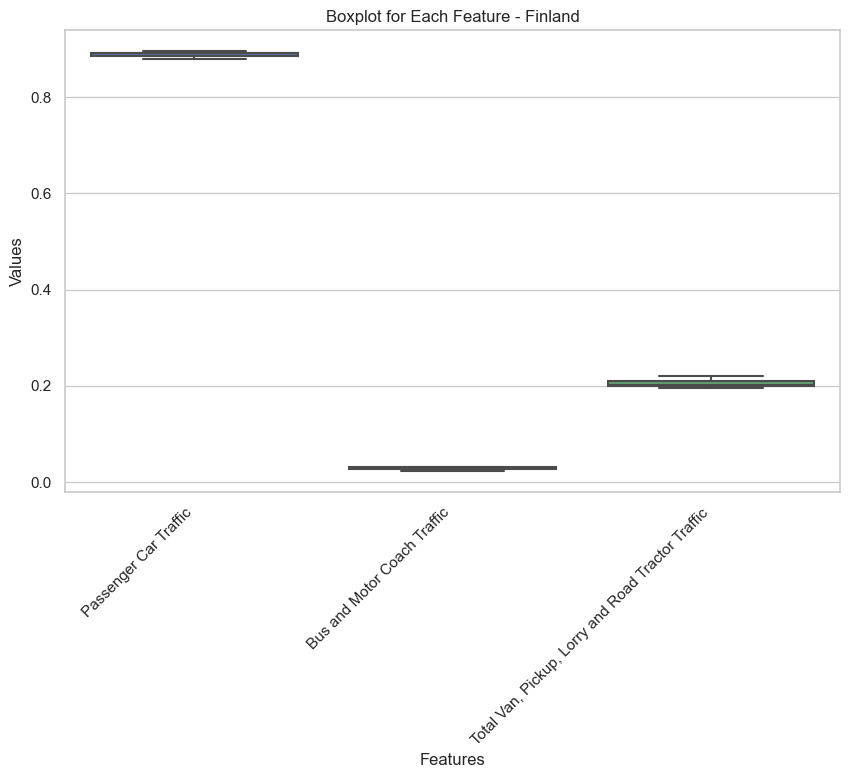

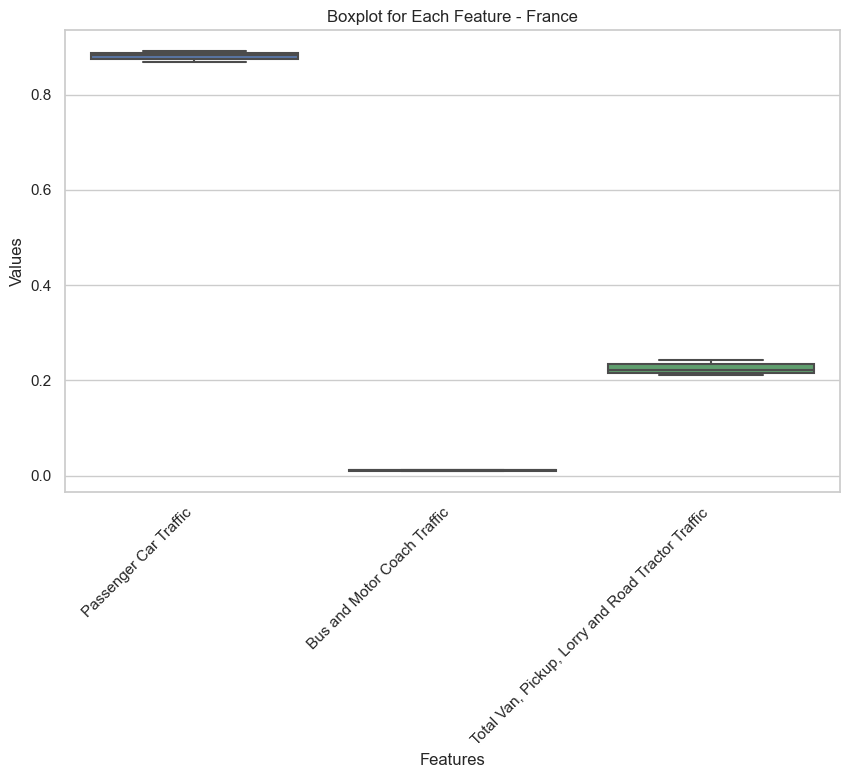

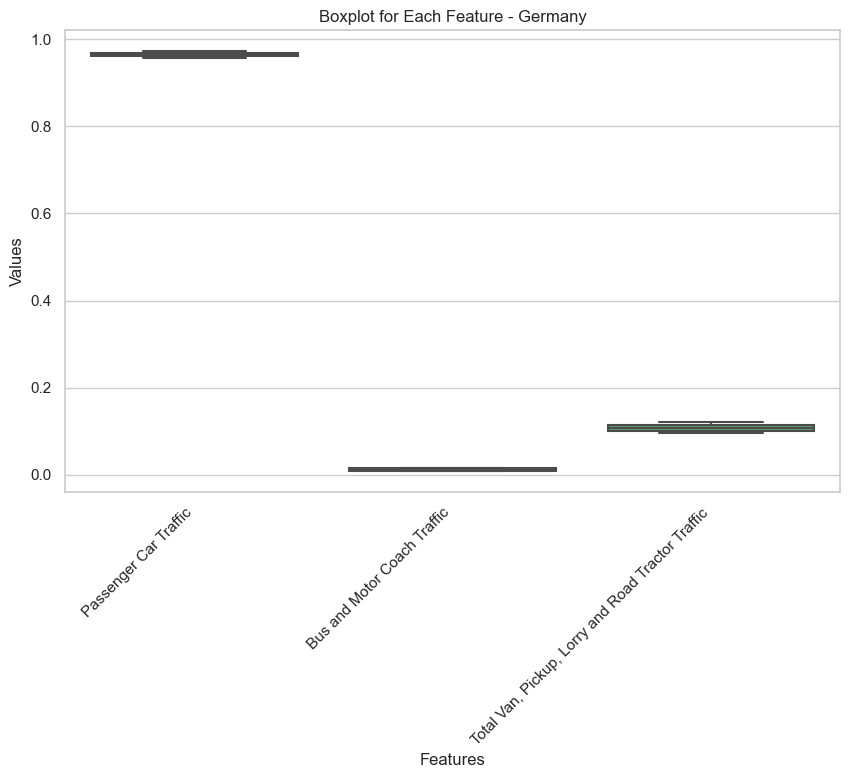

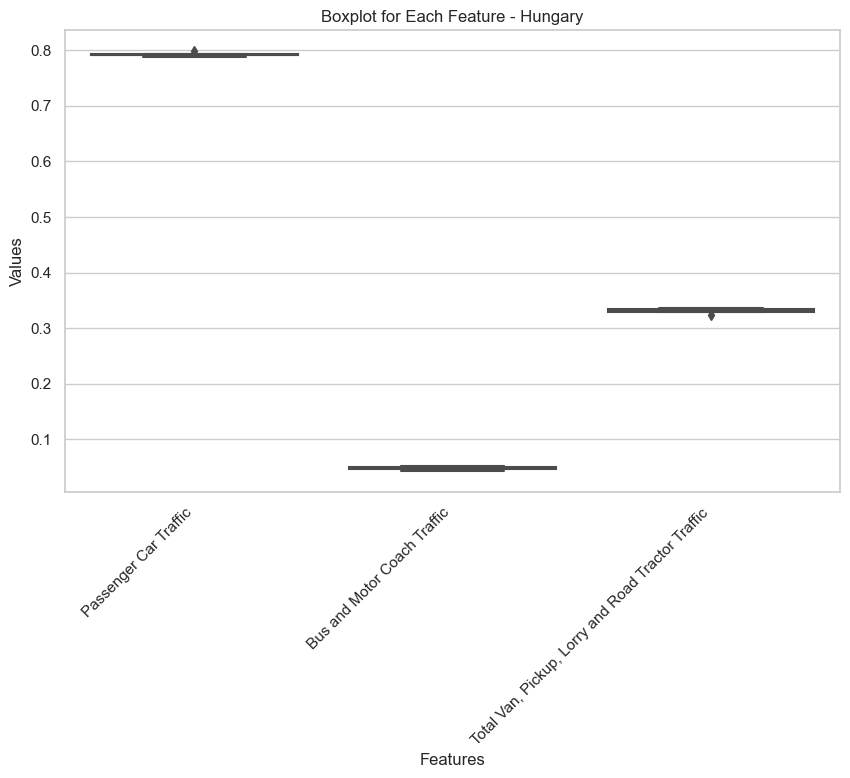

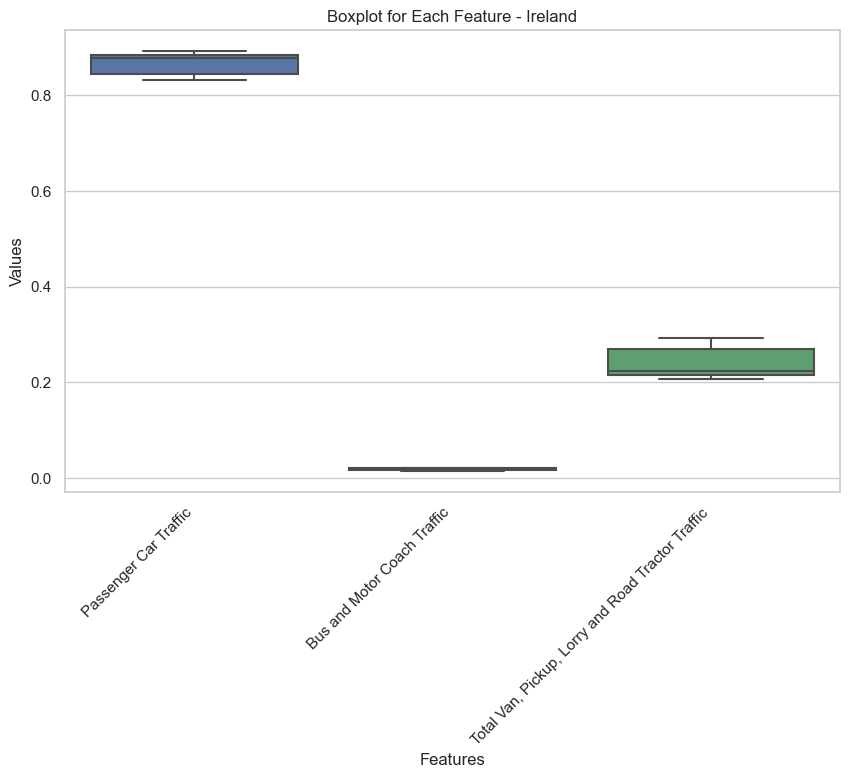

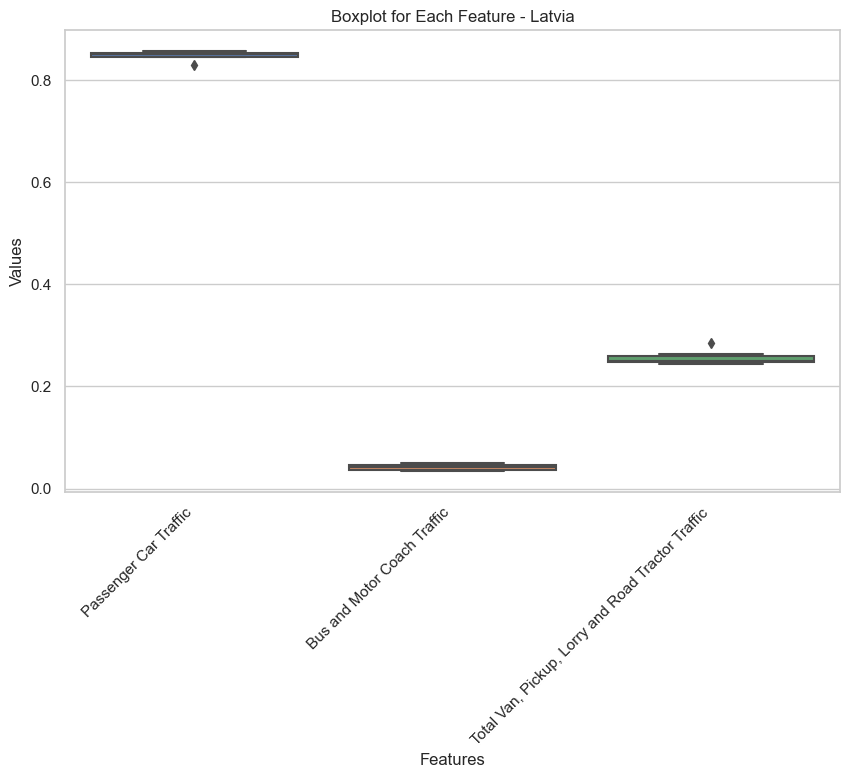

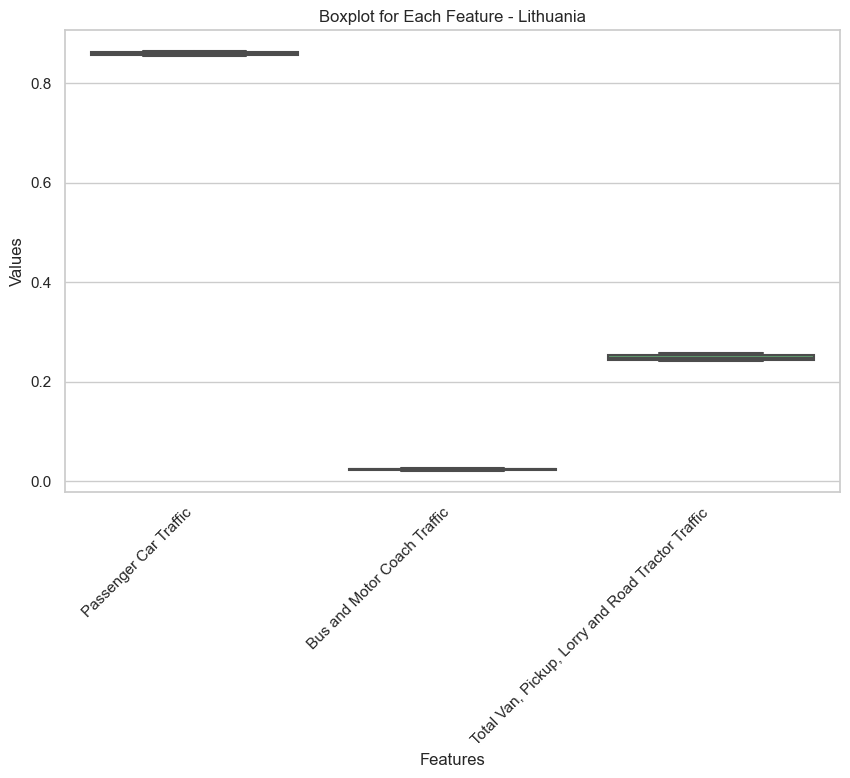

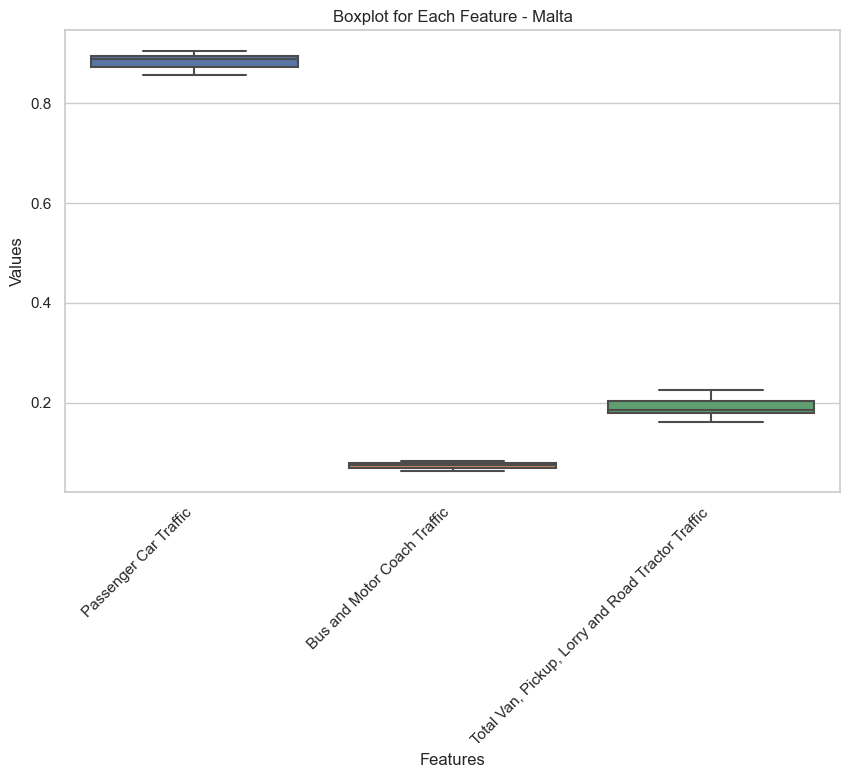

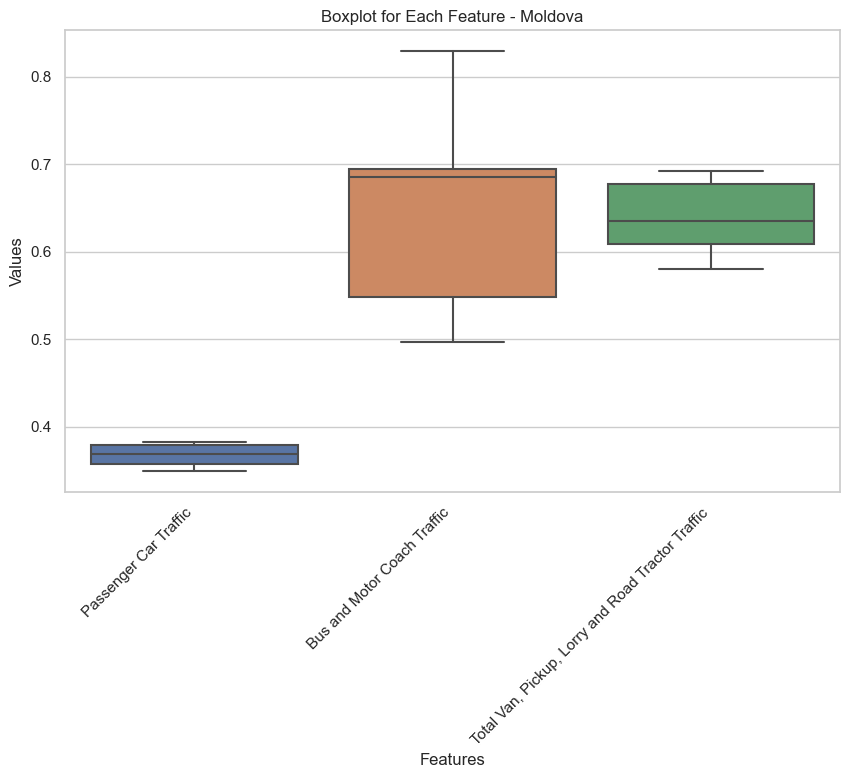

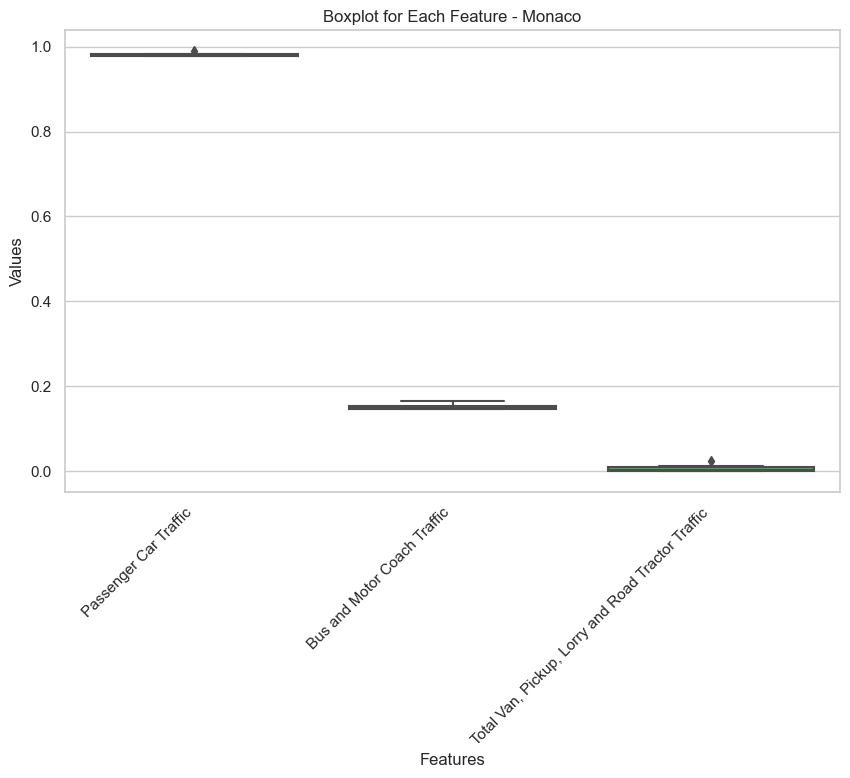

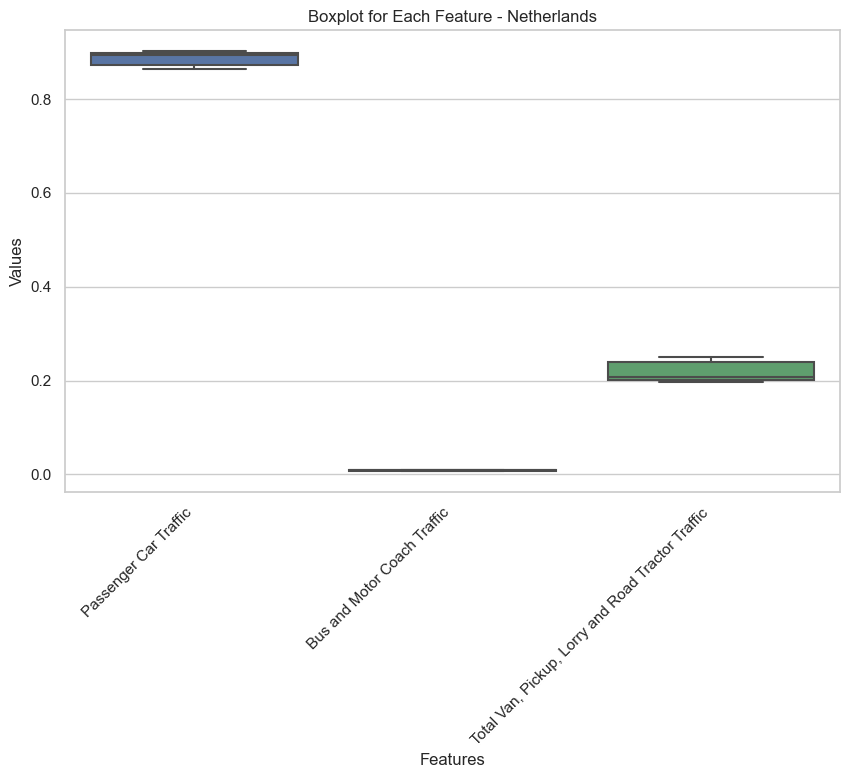

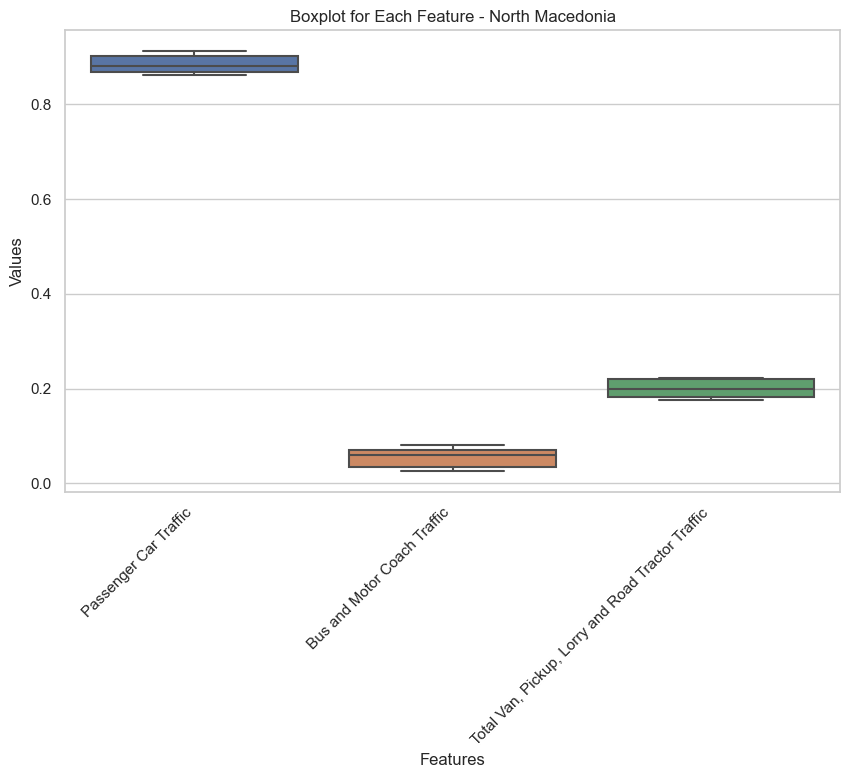

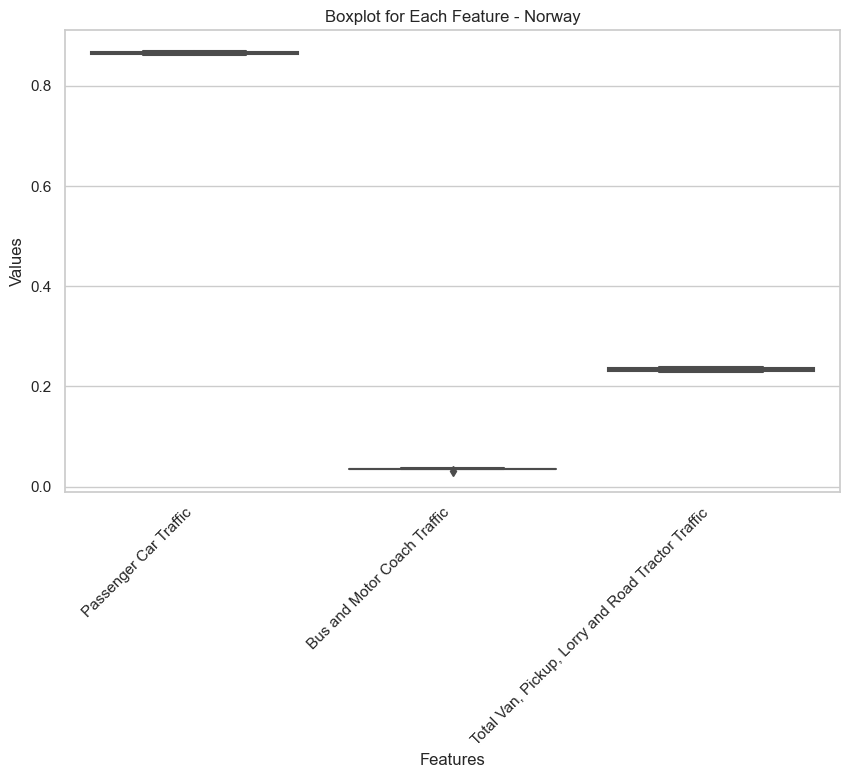

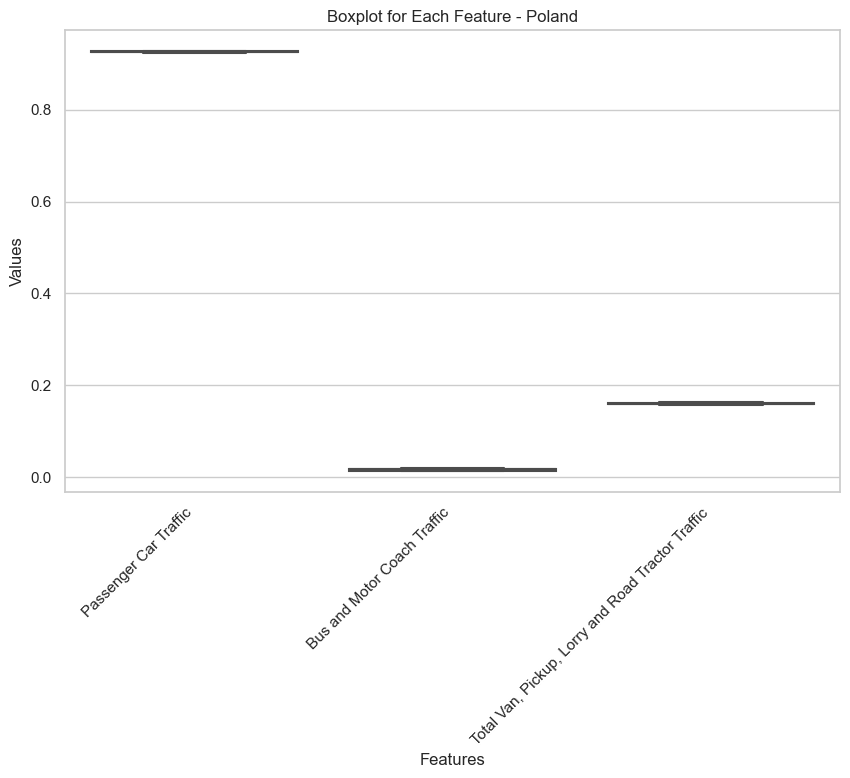

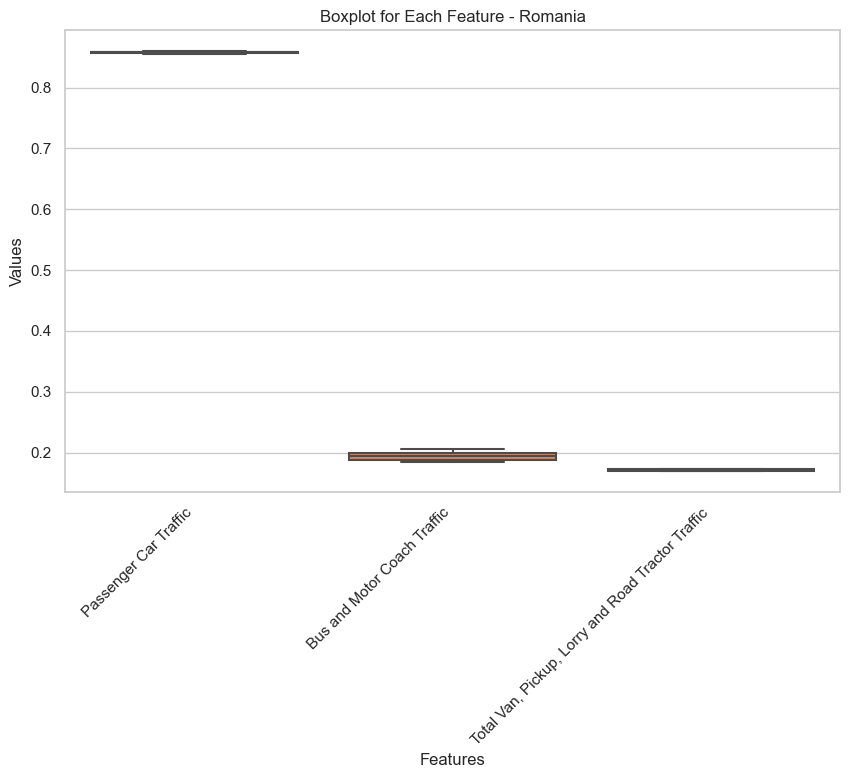

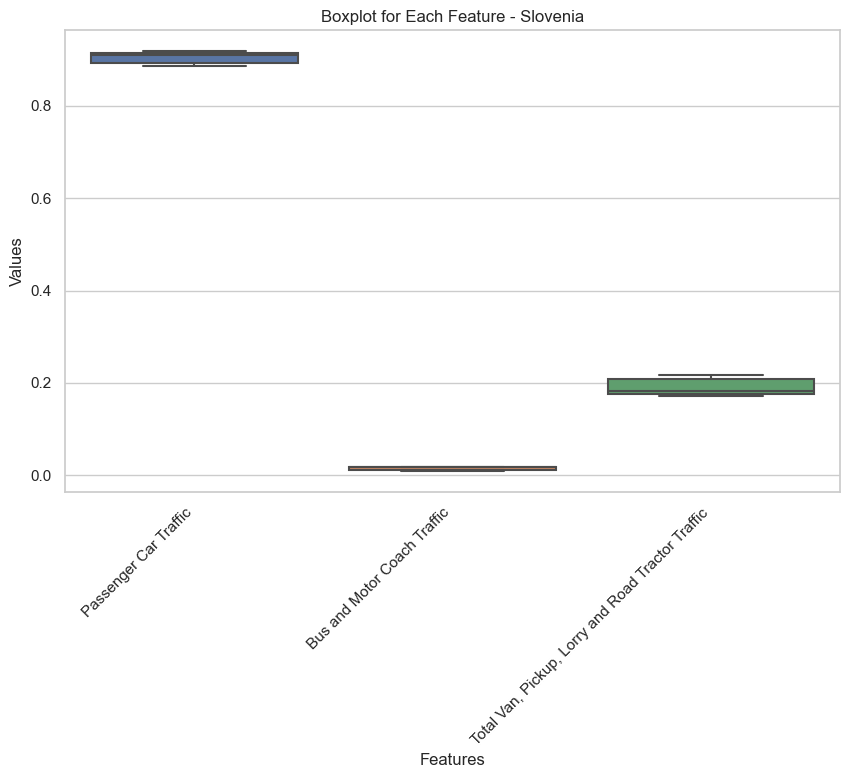

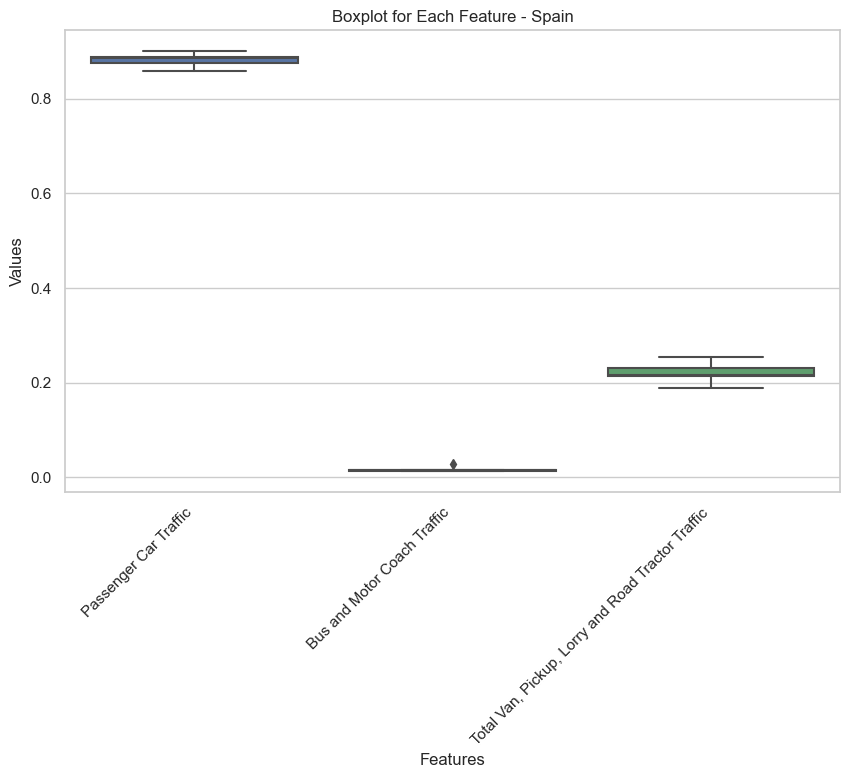

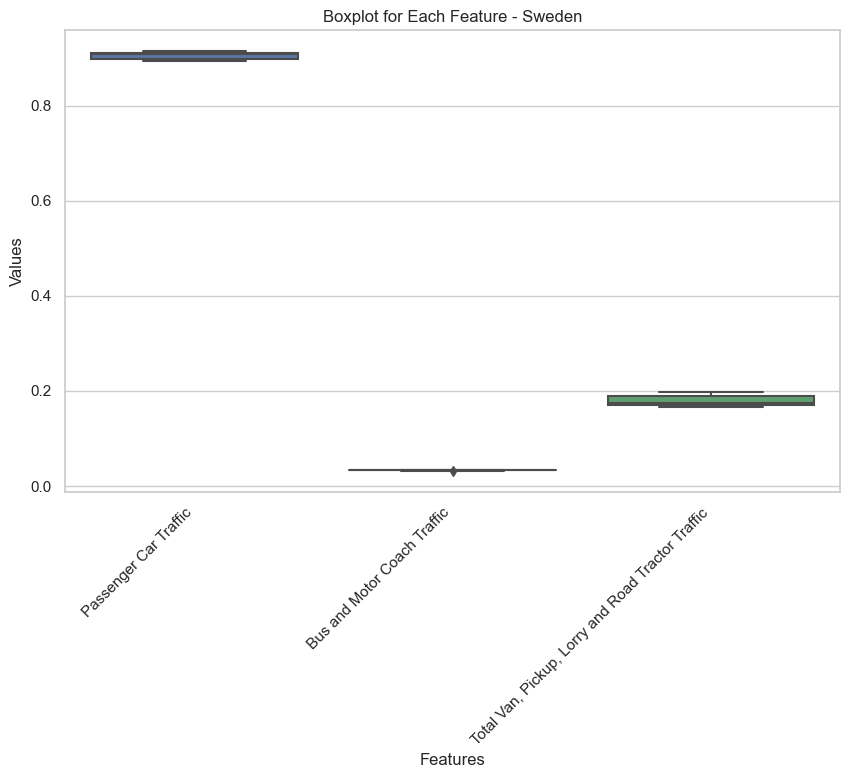

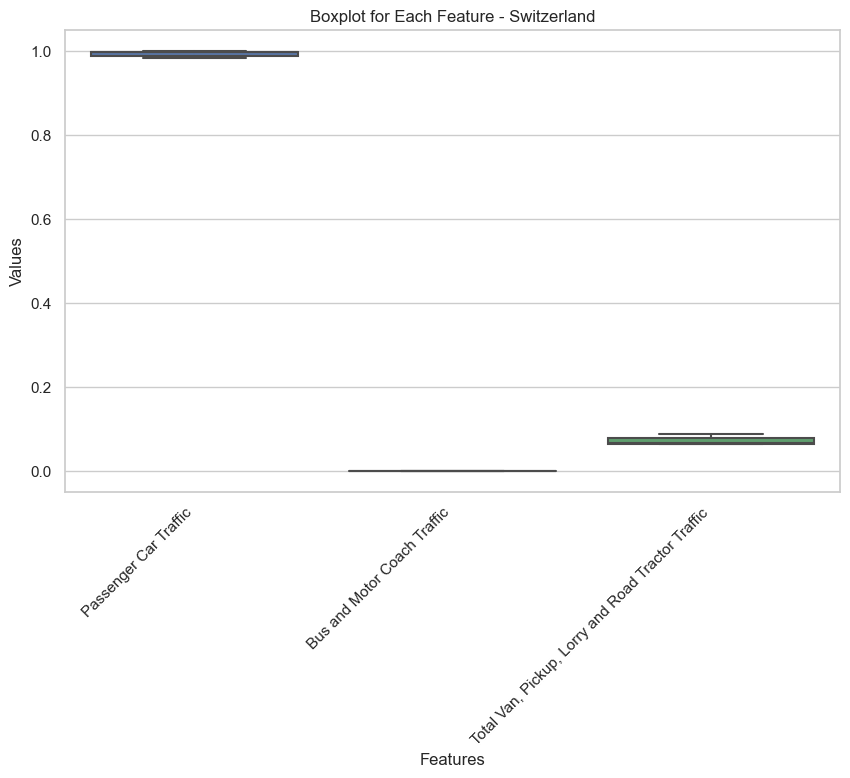

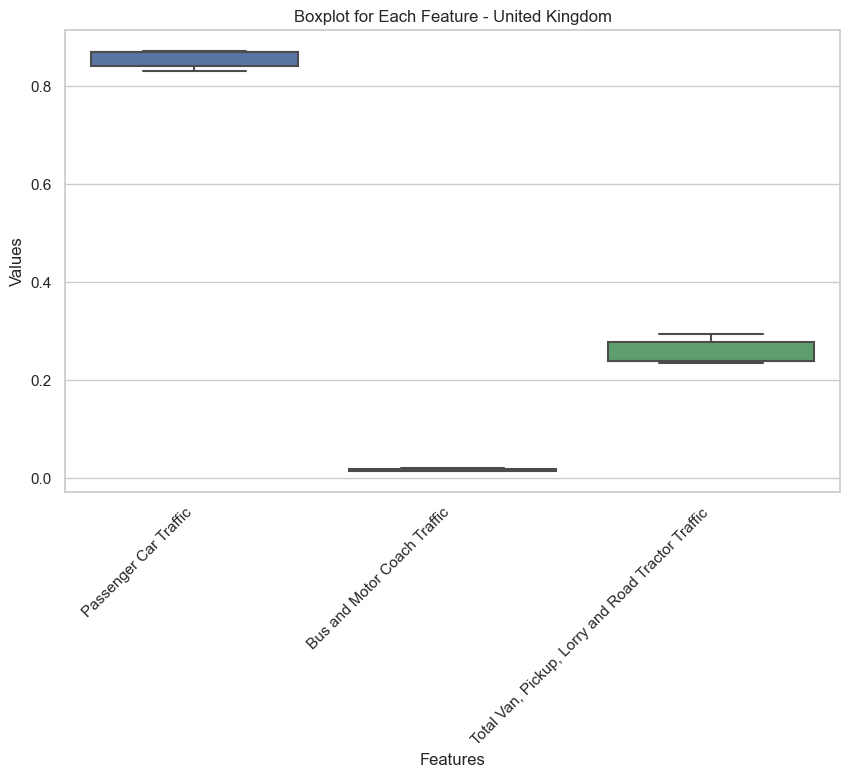

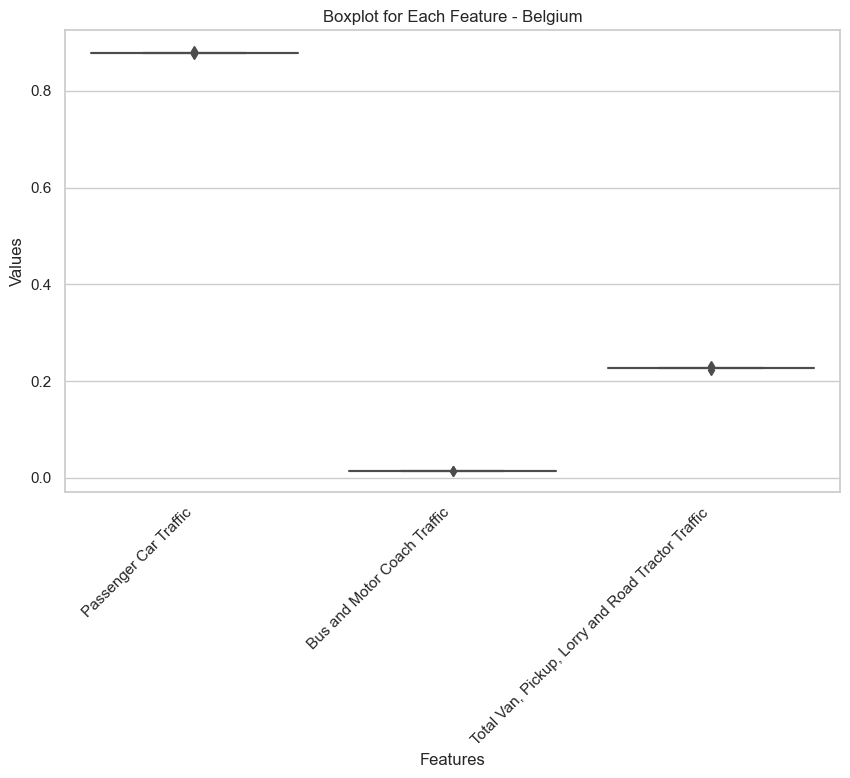

In [34]:
sns.set(style="whitegrid")  # Set the style of the visualization

# Selecting the relevant columns for boxplot
boxplot_data = df.drop("Year", axis=1)

# Get unique categories
categories = df['Category'].unique()

# Create a separate boxplot for each category
for category in categories:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_data[boxplot_data["Category"] == category].iloc[:,1:]))
    plt.title(f"Boxplot for Each Feature - {category}")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()

Countries we were investigating in EDA were:
- Croatia -> Outliers removed
- Ireland -> Outliers removed
- Latvia -> Outliers reduced
- North Macedonia -> Outliers removed
- Portugal -> Country removed
- Russian Federation -> Country removed
- Serbia -> Country removed
- Slovak Republic -> Country removed
- Slovenia -> Outliers removed
- Spain -> Outliers reduced

The cleaning so far has importantly reduced the presence of outliers when looking at single country data. We don't want to delete outliers when looking at aggregation data because:
- Outliers may include relevant information when traffic % are extrmely different for a specific country with respect to others
- Outliers may be caused by events that happened on a specific year (see Covid-19) but we are interested in the relationhip of how those changes impacted countries

Now that our dataset has been transformed and prepared, we can continue our work with some statistics.

But first, let's export the dataset for future dashboarding purposes:

In [35]:
# Data export for dashboarding purposes
df.to_csv("..\Data\df_dashboard.csv", index=False)

# Statistics for Data Analytics Tasks 1-4

#### ●	Use descriptive statistics and appropriate visualisations in order to summarise the dataset(s) used, and to help justify the chosen models. [0-20]

Now that our dataset has been cleaned, let's look at it:

In [36]:
df.head()

Category  Year  Passenger Car Traffic  Bus and Motor Coach Traffic  \
0  Austria  2016               0.930971                     0.013921   
1  Austria  2017               0.930281                     0.014069   
2  Austria  2018               0.924616                     0.013323   
3  Austria  2019               0.917082                     0.013473   
4  Austria  2020               0.909188                     0.010596   

   Total Van, Pickup, Lorry and Road Tractor Traffic  
0                                           0.153818  
1                                           0.154708  
2                                           0.162941  
3                                           0.173352  
4                                           0.185713

The head function gave us an idea of what the dataset looks like, let's check its dimension:

In [37]:
# Dysplay the shape of our dataset
df.shape

(156, 5)

Let's now see the type of each column, the presence of null values and unique values for each column:

In [38]:
# Display data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 5 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Category                                           156 non-null    object 
 1   Year                                               156 non-null    int64  
 2   Passenger Car Traffic                              156 non-null    float64
 3   Bus and Motor Coach Traffic                        156 non-null    float64
 4   Total Van, Pickup, Lorry and Road Tractor Traffic  156 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.2+ KB


Another important thing we want to double-check is the presence of null values:

In [39]:
# Display sum of null values for each column
df.isnull().sum()

Category                                             0
Year                                                 0
Passenger Car Traffic                                0
Bus and Motor Coach Traffic                          0
Total Van, Pickup, Lorry and Road Tractor Traffic    0
dtype: int64

Let's see which countries are represented by this dataset and for what years:

In [40]:
# Display of unique Countries
df.Category.unique()

array(['Austria', 'Belarus', 'Croatia', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Hungary', 'Ireland', 'Latvia', 'Lithuania',
       'Malta', 'Moldova', 'Monaco', 'Netherlands', 'North Macedonia',
       'Norway', 'Poland', 'Romania', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'United Kingdom', 'Belgium'], dtype=object)

In [41]:
# Display of unique Years
df.Year.unique()

array([2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

So far we can say that our dataset contains transportation data  for European countries from 2016 to 2021.

Let's see the data distribution when using the describe function:

In [42]:
# Display data distribution
df.describe()

Year  Passenger Car Traffic  Bus and Motor Coach Traffic  \
count   156.000000             156.000000                   156.000000   
mean   2018.500000               0.843576                     0.095637   
std       1.713325               0.192802                     0.203472   
min    2016.000000               0.000000                     0.000000   
25%    2017.000000               0.861141                     0.013945   
50%    2018.500000               0.887486                     0.029216   
75%    2020.000000               0.914434                     0.057200   
max    2021.000000               1.000000                     1.000000   

       Total Van, Pickup, Lorry and Road Tractor Traffic  
count                                         156.000000  
mean                                            0.236475  
std                                             0.181279  
min                                             0.000000  
25%                                             0.168644  
50%                                             0.203518  
75%                                             0.239181  
max                                             1.000000

The data we see from the describe function is somehow interesting as it gives us an overview of how traffic by vehicle type is distributed across time and countries.

Let's look specifically at Ireland:

In [43]:
# Ireland traffic data
df.loc[df["Category"]=="Ireland"]

Category  Year  Passenger Car Traffic  Bus and Motor Coach Traffic  \
54  Ireland  2016               0.891713                     0.016772   
55  Ireland  2017               0.886555                     0.018563   
56  Ireland  2018               0.879613                     0.021027   
57  Ireland  2019               0.875842                     0.021748   
58  Ireland  2020               0.834539                     0.018825   
59  Ireland  2021               0.831206                     0.014442   

    Total Van, Pickup, Lorry and Road Tractor Traffic  
54                                           0.207096  
55                                           0.213429  
56                                           0.221927  
57                                           0.226835  
58                                           0.285677  
59                                           0.292379

In [44]:
# Ireland traffic data statistical description
df.loc[df["Category"]=="Ireland"].describe()

Year  Passenger Car Traffic  Bus and Motor Coach Traffic  \
count     6.000000               6.000000                     6.000000   
mean   2018.500000               0.866578                     0.018563   
std       1.870829               0.026699                     0.002701   
min    2016.000000               0.831206                     0.014442   
25%    2017.250000               0.844865                     0.017220   
50%    2018.500000               0.877728                     0.018694   
75%    2019.750000               0.884820                     0.020477   
max    2021.000000               0.891713                     0.021748   

       Total Van, Pickup, Lorry and Road Tractor Traffic  
count                                           6.000000  
mean                                            0.241224  
std                                             0.037708  
min                                             0.207096  
25%                                             0.215554  
50%                                             0.224381  
75%                                             0.270967  
max                                             0.292379

Looking at years available it seems that Ireland's traffic is composed by:
- A mean of 86% for passenger traffic, 2% for bus and motor coach traffic and 24% for other four wheeled vehicles
- A max of 89% for passenger traffic, 2% for bus and motor coach traffic and 29% for other four wheeled vehicles
- A min of 83% for passenger traffic, 1% for bus and motor coach traffic and 21% for other four wheeled vehicles

Let's visualize the trend of Ireland traffic by vehicle type over time:

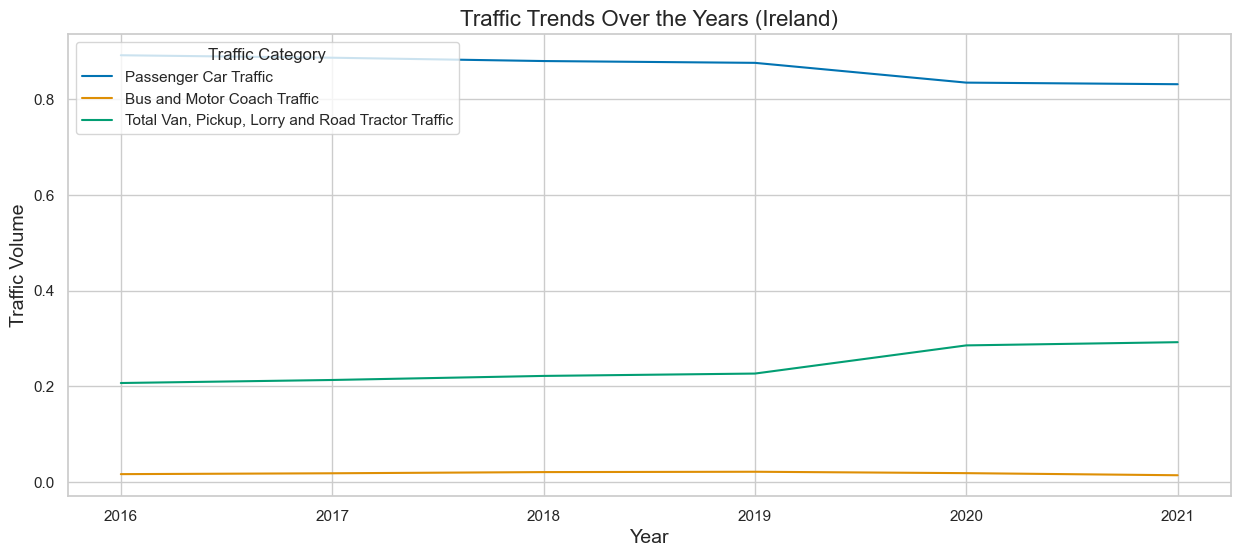

In [45]:
# Filter the DataFrame to extract vehicle categories for Ireland
passenger_df = df[df['Category'] == 'Ireland'][["Passenger Car Traffic", "Year"]]
bus_df = df[df['Category'] == 'Ireland'][["Bus and Motor Coach Traffic", "Year"]]
other_df = df[df['Category'] == 'Ireland'][["Total Van, Pickup, Lorry and Road Tractor Traffic", "Year"]]

# Create separate figures for better clarity
fig, ax = plt.subplots(figsize=(15, 6))

# Use a color palette that is colorblind-friendly
palette = sns.color_palette("colorblind")

# Plot separate lines for passenger car, bus, and other traffic
sns.lineplot(x='Year', y='Passenger Car Traffic', data=passenger_df, label="Passenger Car Traffic", color=palette[0], ax=ax)
sns.lineplot(x='Year', y='Bus and Motor Coach Traffic', data=bus_df, label="Bus and Motor Coach Traffic", color=palette[1], ax=ax)
sns.lineplot(x='Year', y='Total Van, Pickup, Lorry and Road Tractor Traffic', data=other_df, label="Total Van, Pickup, Lorry and Road Tractor Traffic", color=palette[2], ax=ax)

# Increase the font size for labels and title
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Traffic Volume', fontsize=14)
ax.set_title('Traffic Trends Over the Years (Ireland)', fontsize=16)

# Improve legend placement and add a title
ax.legend(title='Traffic Category', title_fontsize='12', loc='upper left')

plt.show()

Even though Bus and Motor coach traffic has been quite steady if we compare it to the other two types of traffic, it's interesting to see how passenger car traffic has decreased since 2019. This might indeed be related to Covid.

Let's now better visualize describe results we were previously looking at using boxplots:

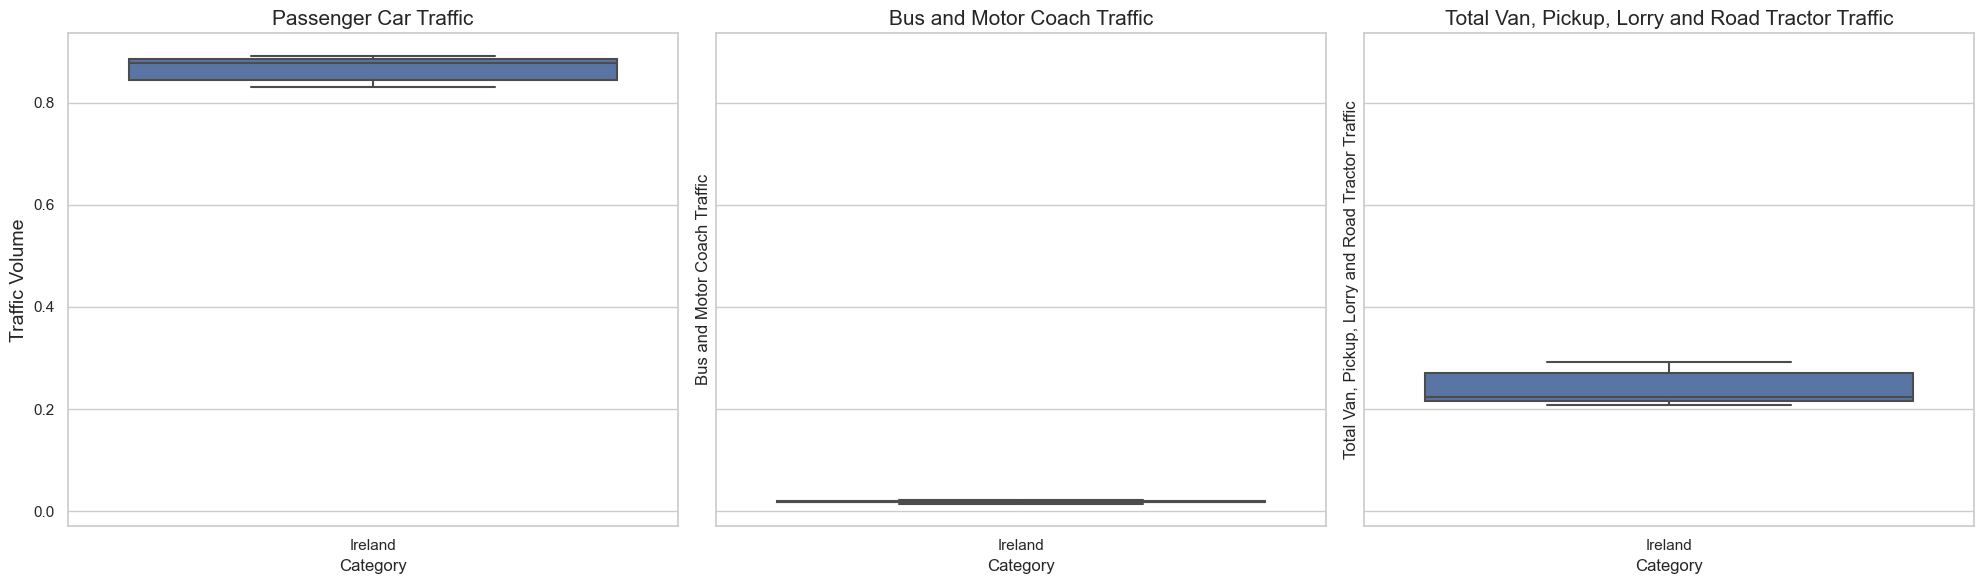

In [46]:
# Filter the DataFrame to extract data for Ireland
ireland_df = df[df['Category'] == 'Ireland']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), sharey=True)

# Create boxplots for each column
sns.boxplot(x='Category', y='Passenger Car Traffic', data=ireland_df, ax=axes[0])
sns.boxplot(x='Category', y='Bus and Motor Coach Traffic', data=ireland_df, ax=axes[1])
sns.boxplot(x='Category', y='Total Van, Pickup, Lorry and Road Tractor Traffic', data=ireland_df, ax=axes[2])

# Set titles for each subplot
axes[0].set_title('Passenger Car Traffic', fontsize=15)
axes[1].set_title('Bus and Motor Coach Traffic', fontsize=15)
axes[2].set_title('Total Van, Pickup, Lorry and Road Tractor Traffic', fontsize=15)

# Set common y-axis label
axes[0].set_ylabel('Traffic Volume', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

Previous graph doesn't look very readable, let's try to rebuild the graphs giving their own scale to the y axis:

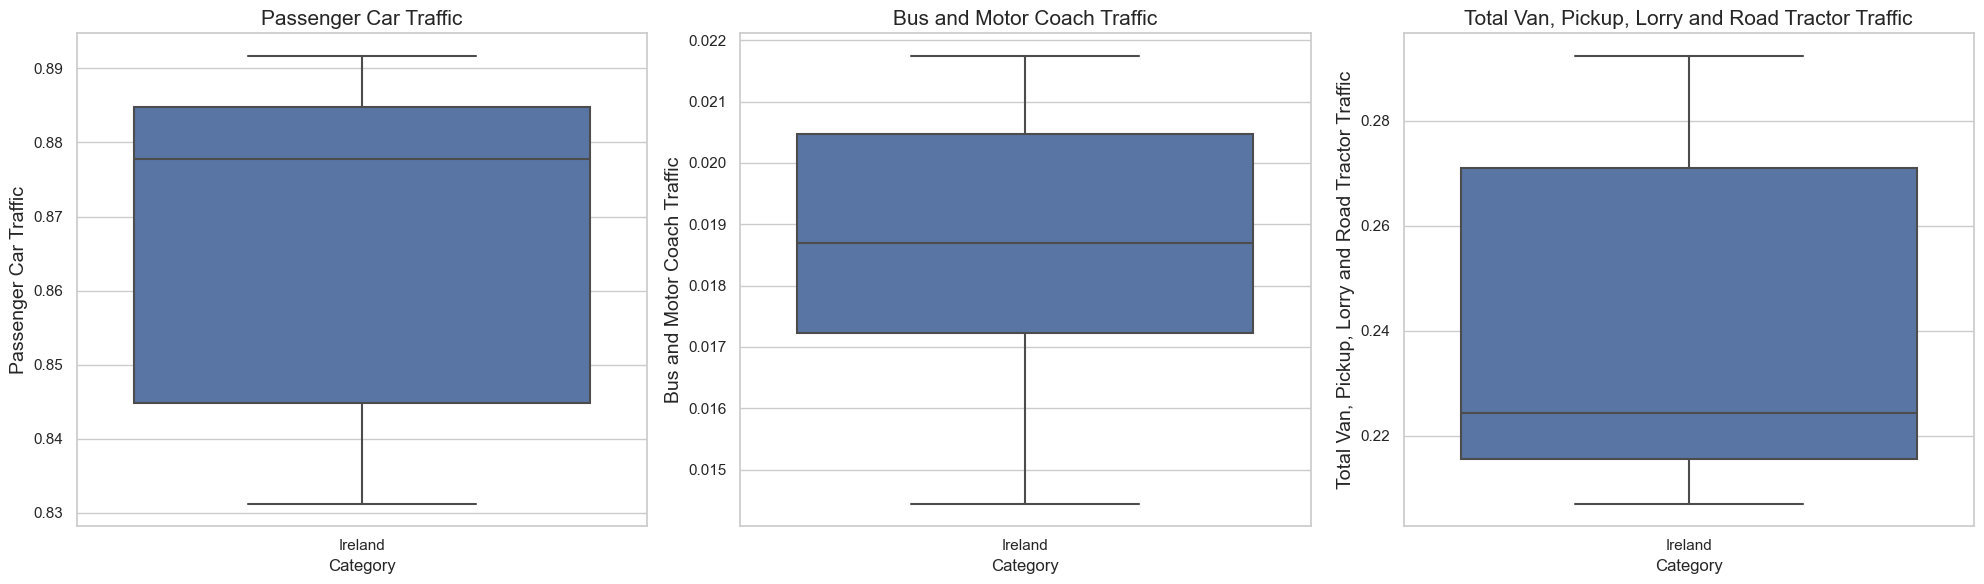

In [47]:
# Filter the DataFrame to extract data for Ireland
ireland_df = df[df['Category'] == 'Ireland']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Create boxplots for each column with individual y-axes
sns.boxplot(x='Category', y='Passenger Car Traffic', data=ireland_df, ax=axes[0])
sns.boxplot(x='Category', y='Bus and Motor Coach Traffic', data=ireland_df, ax=axes[1])
sns.boxplot(x='Category', y='Total Van, Pickup, Lorry and Road Tractor Traffic', data=ireland_df, ax=axes[2])

# Set titles for each subplot
axes[0].set_title('Passenger Car Traffic', fontsize=15)
axes[1].set_title('Bus and Motor Coach Traffic', fontsize=15)
axes[2].set_title('Total Van, Pickup, Lorry and Road Tractor Traffic', fontsize=15)

# Set individual y-axis labels
axes[0].set_ylabel('Passenger Car Traffic', fontsize=14)
axes[1].set_ylabel('Bus and Motor Coach Traffic', fontsize=14)
axes[2].set_ylabel('Total Van, Pickup, Lorry and Road Tractor Traffic', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

Interestingly we see that Bus and Motor Coach Traffic hasn't been changing too much over time, with the mean right at the middle and a low standard deviation.

The situation for the two others vehicle type is quite different to the bus one and opposite to each other (predictable given that we are analysing %). Let's now calculate mean, median, mode and standard deviationf or the different traffic by vechicles columns:

In [48]:
median_passenger_traffic = ireland_df["Passenger Car Traffic"].sum()/2
median_bus_traffic = ireland_df["Bus and Motor Coach Traffic"].sum()/2
median_other_traffic = ireland_df["Total Van, Pickup, Lorry and Road Tractor Traffic"].sum()/2

print(f"Median of Passenger Car Traffic % in Ireland is {median_passenger_traffic}")
print(f"Median of Bus and Motor Coach Traffic % in Ireland is {median_bus_traffic}")
print(f"Median of Total Van, Pickup, Lorry and Road Tractor Traffic % in Ireland is {median_other_traffic}")

Median of Passenger Car Traffic % in Ireland is 2.599734157860812
Median of Bus and Motor Coach Traffic % in Ireland is 0.05568882856304127
Median of Total Van, Pickup, Lorry and Road Tractor Traffic % in Ireland is 0.7236719942389531


We've now only looked at the medians of our metrics but let's also compute other descriptive info:

In [49]:
# Extract columns 2, 3, and 4
selected_columns = ireland_df.iloc[:, 2:5]

# Compute Mean, Median, Mode, and Standard Deviation
mean_values = selected_columns.mean()
median_values = selected_columns.median()
mode_values = selected_columns.mode().iloc[0]  # Mode may have multiple values, so take the first one
std_dev_values = selected_columns.std()

# Create a summary DataFrame
summary_ireland_df = pd.DataFrame({
    'Mean': mean_values*100,
    'Median': median_values*100,
    'Mode': mode_values*100,
    'Standard Deviation': std_dev_values*100
})

In [50]:
summary_ireland_df

Mean     Median  \
Passenger Car Traffic                              86.657805  87.772757   
Bus and Motor Coach Traffic                         1.856294   1.869431   
Total Van, Pickup, Lorry and Road Tractor Traffic  24.122400  22.438121   

                                                        Mode  \
Passenger Car Traffic                              83.120605   
Bus and Motor Coach Traffic                         1.444190   
Total Van, Pickup, Lorry and Road Tractor Traffic  20.709604   

                                                   Standard Deviation  
Passenger Car Traffic                                        2.669924  
Bus and Motor Coach Traffic                                  0.270087  
Total Van, Pickup, Lorry and Road Tractor Traffic            3.770837

From results we can see that passenger car traffic is the most prevalent, with an average traffic of around 86%, and it has a relatively stable pattern.
Bus and motor coach traffic is less frequent but exhibits a consistent and predictable trend with low variability.
Total van, pickup, lorry, and road tractor traffic is intermediate in volume, showing more variability in traffic levels.

Comparing the mean values, passenger car traffic dominates, followed by total van, pickup, lorry, and road tractor traffic, and then bus and motor coach traffic.
The standard deviations provide insights into the variability, with bus and motor coach traffic being the most stable, followed by passenger car traffic and then total van, pickup, lorry, and road tractor traffic.

This is a clear statement about the fact that in Ireland, considering only four wheeled vehicles, people tend more to travel with their own cars instead of using public transportation.

A mean below 2% for bus and motor coach traffic seems like a low percentage and the first reason of this that comes into my mind is because of poor infrastructure or frequency. As this assumption is just a speculation, let's see how Ireland compares with other countries in Europe:

In [51]:
# Let's extract a dataframe excluding Ireland
no_ireland_df = df[df['Category'] != 'Ireland']

In [52]:
no_ireland_df

Category  Year  Passenger Car Traffic  Bus and Motor Coach Traffic  \
0    Austria  2016               0.930971                     0.013921   
1    Austria  2017               0.930281                     0.014069   
2    Austria  2018               0.924616                     0.013323   
3    Austria  2019               0.917082                     0.013473   
4    Austria  2020               0.909188                     0.010596   
..       ...   ...                    ...                          ...   
151  Belgium  2017               0.876188                     0.013416   
152  Belgium  2018               0.878959                     0.013568   
153  Belgium  2019               0.878959                     0.013568   
154  Belgium  2020               0.878959                     0.013568   
155  Belgium  2021               0.878959                     0.013568   

     Total Van, Pickup, Lorry and Road Tractor Traffic  
0                                             0.153818  
1                                             0.154708  
2                                             0.162941  
3                                             0.173352  
4                                             0.185713  
..                                                 ...  
151                                           0.230261  
152                                           0.226342  
153                                           0.226342  
154                                           0.226342  
155                                           0.226342  

[150 rows x 5 columns]

And compute mean, median, mode and standard deviation:

In [53]:
# Extract columns 2, 3, and 4
selected_columns = no_ireland_df.iloc[:, 2:5]

# Compute Mean, Median, Mode, and Standard Deviation
mean_values = selected_columns.mean()
median_values = selected_columns.median()
mode_values = selected_columns.mode().iloc[0]  # Mode may have multiple values, so take the first one
std_dev_values = selected_columns.std()

# Create a summary DataFrame
summary_no_ireland_df = pd.DataFrame({
    'Mean': mean_values*100,
    'Median': median_values*100,
    'Mode': mode_values*100,
    'Standard Deviation': std_dev_values*100
})

In [54]:
summary_no_ireland_df

Mean     Median  \
Passenger Car Traffic                              84.265596  88.825158   
Bus and Motor Coach Traffic                         9.871954   3.062681   
Total Van, Pickup, Lorry and Road Tractor Traffic  23.628519  19.998857   

                                                        Mode  \
Passenger Car Traffic                              87.895908   
Bus and Motor Coach Traffic                         1.356844   
Total Van, Pickup, Lorry and Road Tractor Traffic  22.634184   

                                                   Standard Deviation  
Passenger Car Traffic                                       19.652827  
Bus and Motor Coach Traffic                                 20.692767  
Total Van, Pickup, Lorry and Road Tractor Traffic           18.476125

From the data extracted, we can observe the following:

- The mean value for passenger car traffic in Ireland is higher than the mean for Europe, but with a median slightly lower than the European one. This suggests that Ireland has a higher reliance on passenger cars compared to the average European country, but not the highest. The standard deviation is significantly lower in Ireland, indicating less variability in passenger car traffic.


- The mean and median values for bus and motor coach traffic in Ireland are significantly lower than in Europe. This could suggest a lower reliance on public transportation in Ireland. The standard deviation is also much lower in Ireland, indicating less variability in bus and motor coach traffic.


- The mean and median values for other four wheeled vehicles in Ireland are slightly higher than the ones for Europe. This suggests that Ireland might have a higher reliance on these types of vehicles compared to the average European country and on the higher band. The standard deviation is lower in Ireland, indicating again less variability in this type of traffic.


Possible causes for these differences could be related to the geographical, economic, and infrastructural characteristics of Ireland. For example, Ireland’s smaller size and population density could lead to a higher reliance on personal vehicles (passenger cars) and less on public transportation (buses and motor coaches). 

Economic factors such as income levels, cost of vehicle ownership, and cost of public transportation could also play a role. Infrastructure factors such as the availability and quality of public transportation, road networks, and traffic congestion could also influence these patterns.

#### ●	Analyse the variables in your dataset(s) and use appropriate inferential statistics to gain insights on possible population values (e.g., if you were working with public transport, you could find a confidence interval for the population proportion of users commuting to Dublin by train). [0-20]

Inferential statistics is a branch of statistics that involves drawing conclusions, making predictions, and making inferences about a population based on a sample of data taken from that population. The primary goal of inferential statistics is to generalize findings from a sample to a larger population and to make informed decisions or predictions about that population.

In our case, the data we have at our disposal can be considered a sample as it only contains data from 2016 to 2021. For this reason we want to apply inferential statistics and, more specifically, we want to identify confidence intervals for Ireland traffic metrics.

Let's start with our favourite metric "Bus and Motor Coach Traffic":

In [55]:
# We want to find a confidence interval for the mean of "Bus and Motor Coach Traffic" in Ireland
bus_traffic_data_dublin = ireland_df['Bus and Motor Coach Traffic']

# Calculate the confidence interval
confidence_interval = stats.norm.interval(0.95, loc=np.mean(bus_traffic_data_dublin), scale=np.std(bus_traffic_data_dublin))

print("95% Confidence Interval for Bus Car Traffic Mean:", confidence_interval)

95% Confidence Interval for Bus Car Traffic Mean: (0.013730561054052333, 0.023395324654641843)


Previous results show that we can be 95% confidence that if we enlarge our population - true population - (for example looking at data for 2022, 2023 and even future years such as 2024), the bus and motor coach traffic % would be between 1.37% and 2.34%.

Let's now apply a t-testand remember that it is a statistical test used to determine if there is a significant difference between the means of two groups or if a single group's mean is significantly different from a known or hypothesized value. 

In our case we want to apply it to understand if there is any chance of having the bus and motor coach traffic mean equal to 5%.

Let's now define null and alternative hypothesis:
- Null Hypothesis (H0) -> The mean of "Bus and Motor Coach Traffic" in Dublin is equal to 5%.
- Alternative Hypothesis (H1) -> The mean of "Bus and Motor Coach Traffic" in Dublin is not equal to 5%.

In [56]:
# T-test execution for Bus and Motor Coach Traffic 
t_stat, p_value = stats.ttest_1samp(bus_traffic_data_dublin, 0.05)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -28.511084529659996
P-value: 9.943239064306657e-07


The p-value resulting from the t-test is compared to a significance level (commonly 0.05). If the p-value is less than the significance level, we reject the null hypothesis.

In our case, the p-value is extremely small (9.94e-07), indicating strong evidence against the null hypothesis. With such a small value, we reject the null hypothesis and conclude that the mean of "Bus and Motor Coach Traffic" in Dublin is significantly different from 5%.

Let's do the same for 2%:

In [57]:
# T-test execution for Bus and Motor Coach Traffic 
t_stat, p_value = stats.ttest_1samp(bus_traffic_data_dublin, 0.02)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -1.303304490742629
P-value: 0.24925528024925608


In this case the p-value is greater than the commonly used significance level of 0.05, we thus fail to reject the null hypothesis. This means that there is not enough evidence to suggest that the mean of "Bus and Motor Coach Traffic" in Dublin is significantly different from 2% at a 5% significance level.

Therefore, based on this analysis, we do not have sufficient statistical evidence to conclude that the mean bus and motor coach traffic in Dublin differs significantly from 2%.

And in fact, if we look at result over the years we can see that min is 1.4% and max 2.2% with a mean of 1.9%. Also, our confidence interval at 95% is (0.013730561054052333, 0.023395324654641843).

In [58]:
ireland_df[["Year", "Bus and Motor Coach Traffic"]].describe()

Year  Bus and Motor Coach Traffic
count     6.000000                     6.000000
mean   2018.500000                     0.018563
std       1.870829                     0.002701
min    2016.000000                     0.014442
25%    2017.250000                     0.017220
50%    2018.500000                     0.018694
75%    2019.750000                     0.020477
max    2021.000000                     0.021748

As the confidence interval can give us a lot of information, let's also compute the confidence interval for other meatrics by also visualizing them:

DataFrame with Confidence Intervals:
                                                  Lower Bound Upper Bound
Passenger Car Traffic                                0.814248    0.918908
Bus and Motor Coach Traffic                          0.013269    0.023857
Total Van, Pickup, Lorry and Road Tractor Traffic    0.167317    0.315131


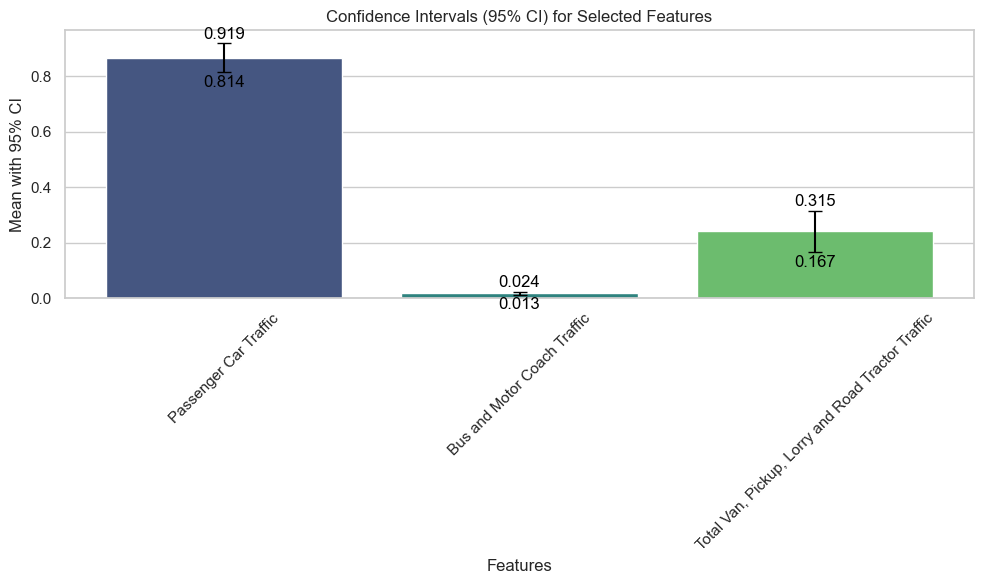

In [59]:
# Select the features for which you want to calculate confidence intervals
features = ['Passenger Car Traffic', 'Bus and Motor Coach Traffic', 'Total Van, Pickup, Lorry and Road Tractor Traffic']

# Create a new DataFrame to store confidence intervals
ci_df = pd.DataFrame(index=features, columns=['Lower Bound', 'Upper Bound'])

# Calculate confidence intervals for each feature using stats.norm.interval
for feature in features:
    mean = ireland_df[feature].mean()
    std_dev = ireland_df[feature].std()
    confidence_interval = stats.norm.interval(0.95, loc=mean, scale=std_dev)
    ci_df.loc[feature] = confidence_interval

# Display the DataFrame with confidence intervals
print("DataFrame with Confidence Intervals:")
print(ci_df)

# Plotting the graph with numbers near the CI range
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=ci_df.index, y=(ci_df['Lower Bound'] + ci_df['Upper Bound']) / 2, palette="viridis")

# Add numeric values near the CI range
for index, feature in enumerate(features):
    lower_bound, upper_bound = ci_df.loc[feature]
    plt.text(index, upper_bound + 0.005, f'{upper_bound:.3f}', ha='center', va='bottom', color='black')
    plt.text(index, lower_bound - 0.01, f'{lower_bound:.3f}', ha='center', va='top', color='black')

plt.errorbar(x=ci_df.index, y=(ci_df['Lower Bound'] + ci_df['Upper Bound']) / 2,
             yerr=(ci_df['Upper Bound'] - ci_df['Lower Bound']) / 2,
             fmt='none', color='black', capsize=5)

plt.title("Confidence Intervals (95% CI) for Selected Features")
plt.ylabel("Mean with 95% CI")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The width of the confidence interval reflects the precision of the estimate. A narrower interval means that the estimate is more precise, while a wider interval means that the estimate is less precise.

In the results obtained for Ireland, the confidence interval for passenger car traffic is wider than the confidence interval for bus and motor coach traffic, this is because the sample size for bus and motor coach traffic is smaller.

This means that the estimate for passenger car traffic is less precise than the estimate for bus and motor coach traffic.

#### ● Undertake research to find similarities between some country(s) against Ireland and apply parametric and non-parametric inferential statistical techniques to compare them (e.g., t-test, analysis of variance, Wilcoxon test, chi-squared test, among others). You must justify your choices and verify the applicability of the tests. Hypotheses and conclusions must be clearly stated. You are expected to use at least 5 different inferential statistics tests. [0-40]

Now tha twe got an understanding of what are Confidence Intervals for specific traffic vehicles in Ireland, let's see how we can compare to other countries in Europe. For this purpose parametric and non-parametric inferential statistical techniques will be used.

The main difference between those is that parametric methods assume that the analyzed population has specific properties that we will shortly look at. On the other hand, non-parametric techniques are less strict to those requirements.


Parametric inferential statistical techniques used are:
- T-Test
- One-Way ANOVA
- Two-Way ANOVA

Non-parametric inferential statistical techniques used are:
- Kruskal-Wallis
- Wilcoxon test


##### Parametric inferential statistical techniques - Assumptions

Before proceeding with parametric inferential statistical techniques, we need to make sure that our data follows the specific assumptions:
- The populations are independent. In other words, their outcomes do not affect each other.
- The populations have a normal distribution.
- The variances of the normal distributions are equal.

https://www.pythonfordatascience.org/parametric-assumptions-python/

The first test to perform it's to verify that the population is independent. 

In the context of time-series data, the concept of independence refers to the assumption that each observation in the time series is not influenced by or dependent on the previous observations. To verify this we perform an autocorrelation test called Ljung-Box test. 

Let's start with Passenger Car Traffic in Ireland first:

In [60]:
# Extract time series for only Passenger Car Traffic in Ireland
time_series = df[["Category", "Year", "Passenger Car Traffic"]]
time_series_ireland = time_series.loc[time_series["Category"]=="Ireland"].iloc[:,1:]
# Set 'Year' as the index
time_series_ireland.set_index('Year', inplace=True)

This is the time-series we want to check if autocorrelated or not:

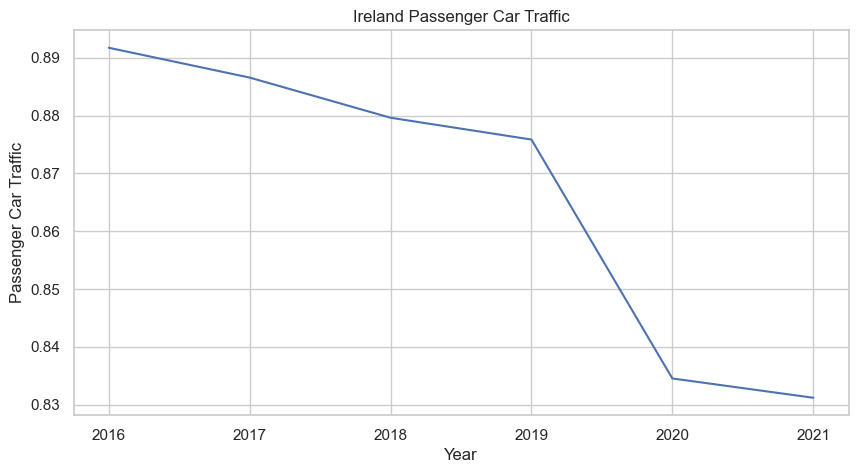

In [61]:
# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(time_series_ireland['Passenger Car Traffic'])
plt.title('Ireland Passenger Car Traffic')
plt.xlabel('Year')
plt.ylabel('Passenger Car Traffic')
plt.show()

We now execute the Ljung-Box test:

In [62]:
# Conduct the Ljung-Box test for autocorrelation
lags = min(3, len(time_series_ireland)-1)
results = sm.stats.acorr_ljungbox(time_series_ireland['Passenger Car Traffic'], lags=lags, return_df=True)

In [63]:
# Display the test results
print("Ljung-Box Test Results:")
print(results)

Ljung-Box Test Results:
    lb_stat  lb_pvalue
1  2.234944   0.134922
2  2.286055   0.318852
3  3.235550   0.356714


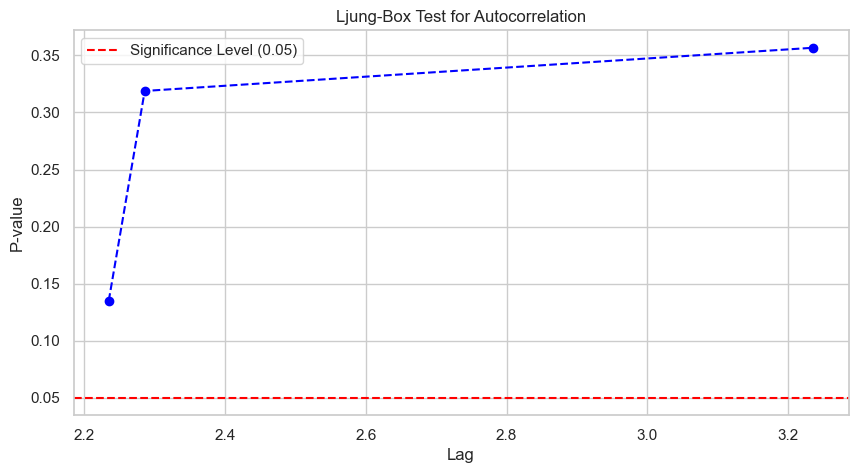

In [64]:
# Plot the p-values from the Ljung-Box test
plt.figure(figsize=(10, 5))
plt.plot(results['lb_stat'], results['lb_pvalue'], marker='o', linestyle='--', color='blue')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
plt.title('Ljung-Box Test for Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.legend()
plt.show()

Given that the p-values from the Ljung-Box test are consistently above a significance level (defined as 0.05), it suggests that there is no significant autocorrelation, supporting the assumption of independence. 

If, on the other hand, p-values would have been below the significance level, this would have indicate autocorrelation, suggesting a lack of independence in the time series.






Let's now build the following function to make sure that we can extract autocorrelation for each country and metric available:

In [65]:
def check_autocorrelation(df, country_column='Category', value_columns=['Passenger Car Traffic', 'Bus and Motor Coach Traffic', 'Total Van, Pickup, Lorry and Road Tractor Traffic'], lags=3, significance_level=0.05):
    """
    Check autocorrelation for each country's time series.

    Parameters:
    - df: DataFrame containing the time series data
    - country_column: Column name containing country names
    - value_columns: List of column names containing time series values
    - lags: Number of lags to consider in the Ljung-Box test
    - significance_level: Significance level for the Ljung-Box test

    Returns:
    - result_df: DataFrame with columns 'Country', 'Autocorrelation Flag', 'Autocorrelated Series'
    """
    result_list = []

    # Iterate through each country
    for country in df[country_column].unique():
        country_df = df[df[country_column] == country]

        autocorrelation_flag = False
        autocorrelated_series = []

        # Iterate through each time series for the country
        for value_column in value_columns:
            series = country_df[value_column]
            results = sm.stats.acorr_ljungbox(series, lags=lags, return_df=True)

            # Check if any p-value is below the significance level
            if any(results['lb_pvalue'] < significance_level):
                autocorrelation_flag = True
                autocorrelated_series.append(value_column)

        result_list.append({
            'Country': country,
            'Autocorrelation Flag': autocorrelation_flag,
            'Autocorrelated Series': ', '.join(autocorrelated_series)
        })

    result_df = pd.DataFrame(result_list)
    return result_df

# Execute function to identify autocorrelation
result_df = check_autocorrelation(df)

In [66]:
result_df

Country  Autocorrelation Flag Autocorrelated Series
0           Austria                 False                      
1           Belarus                 False                      
2           Croatia                 False                      
3           Denmark                 False                      
4           Estonia                 False                      
5           Finland                 False                      
6            France                 False                      
7           Germany                 False                      
8           Hungary                 False                      
9           Ireland                 False                      
10           Latvia                 False                      
11        Lithuania                 False                      
12            Malta                 False                      
13          Moldova                 False                      
14           Monaco                 False                      
15      Netherlands                 False                      
16  North Macedonia                 False                      
17           Norway                 False                      
18           Poland                 False                      
19          Romania                 False                      
20         Slovenia                 False                      
21            Spain                 False                      
22           Sweden                 False                      
23      Switzerland                 False                      
24   United Kingdom                 False                      
25          Belgium                 False

Luckly all time-series are independent. Let's now verify that, for each country, the distribution is normal:

In [67]:
def check_normality(df, country_column='Category', value_columns=['Passenger Car Traffic', 'Bus and Motor Coach Traffic', 'Total Van, Pickup, Lorry and Road Tractor Traffic'], alpha=0.05):
    """
    Check normality for each country's time series using the Shapiro-Wilk test.

    Parameters:
    - df: DataFrame containing the time series data
    - country_column: Column name containing country names
    - value_columns: List of column names containing time series values
    - alpha: Significance level for the Shapiro-Wilk test

    Returns:
    - result_df: DataFrame with columns 'Country', 'Normality Flag', 'Non-Normal Series'
    """
    result_list = []

    # Iterate through each country
    for country in df[country_column].unique():
        country_df = df[df[country_column] == country]

        normality_flag = True
        non_normal_series = []

        # Iterate through each time series for the country
        for value_column in value_columns:
            series = country_df[value_column]
            _, p_value = shapiro(series)

            # Check if p-value is below the significance level
            if p_value < alpha:
                normality_flag = False
                non_normal_series.append(value_column)

        result_list.append({
            'Country': country,
            'Normality Flag': normality_flag,
            'Non-Normal Series': ', '.join(non_normal_series)
        })

    result_df = pd.DataFrame(result_list)
    return result_df

# Execute function to identify normality
result_normality_df = check_normality(df)

In [68]:
result_normality_df

Country  Normality Flag  \
0           Austria           False   
1           Belarus            True   
2           Croatia           False   
3           Denmark            True   
4           Estonia            True   
5           Finland            True   
6            France           False   
7           Germany           False   
8           Hungary            True   
9           Ireland            True   
10           Latvia            True   
11        Lithuania           False   
12            Malta            True   
13          Moldova            True   
14           Monaco            True   
15      Netherlands           False   
16  North Macedonia            True   
17           Norway           False   
18           Poland            True   
19          Romania            True   
20         Slovenia           False   
21            Spain           False   
22           Sweden            True   
23      Switzerland           False   
24   United Kingdom           False   
25          Belgium            True   

                                    Non-Normal Series  
0                         Bus and Motor Coach Traffic  
1                                                      
2                         Bus and Motor Coach Traffic  
3                                                      
4                                                      
5                                                      
6                         Bus and Motor Coach Traffic  
7                         Bus and Motor Coach Traffic  
8                                                      
9                                                      
10                                                     
11                        Bus and Motor Coach Traffic  
12                                                     
13                                                     
14                                                     
15  Total Van, Pickup, Lorry and Road Tractor Traffic  
16                                                     
17                        Bus and Motor Coach Traffic  
18                                                     
19                                                     
20                        Bus and Motor Coach Traffic  
21                        Bus and Motor Coach Traffic  
22                                                     
23  Passenger Car Traffic, Total Van, Pickup, Lorr...  
24  Passenger Car Traffic, Total Van, Pickup, Lorr...  
25

Previous table shows Countries with Non-Normal series and also the name of the series. 

As we must obey to assumptions required for parametric techniques, we are forced to drop those series:

In [69]:
df

Category  Year  Passenger Car Traffic  Bus and Motor Coach Traffic  \
0    Austria  2016               0.930971                     0.013921   
1    Austria  2017               0.930281                     0.014069   
2    Austria  2018               0.924616                     0.013323   
3    Austria  2019               0.917082                     0.013473   
4    Austria  2020               0.909188                     0.010596   
..       ...   ...                    ...                          ...   
151  Belgium  2017               0.876188                     0.013416   
152  Belgium  2018               0.878959                     0.013568   
153  Belgium  2019               0.878959                     0.013568   
154  Belgium  2020               0.878959                     0.013568   
155  Belgium  2021               0.878959                     0.013568   

     Total Van, Pickup, Lorry and Road Tractor Traffic  
0                                             0.153818  
1                                             0.154708  
2                                             0.162941  
3                                             0.173352  
4                                             0.185713  
..                                                 ...  
151                                           0.230261  
152                                           0.226342  
153                                           0.226342  
154                                           0.226342  
155                                           0.226342  

[156 rows x 5 columns]

In [70]:
# Collect countries that are normal
normal_countries = result_normality_df.loc[result_normality_df["Normality Flag"]==True].iloc[:,:1].values
normal_countries = [country[0] for country in normal_countries]

# Let's filter our dataset
df_parametric = df[df["Category"].isin(normal_countries)]

In [71]:
df_parametric

Category  Year  Passenger Car Traffic  Bus and Motor Coach Traffic  \
6    Belarus  2016               0.012938                     1.000000   
7    Belarus  2017               0.000000                     0.985214   
8    Belarus  2018               0.006537                     0.948353   
9    Belarus  2019               0.078061                     0.828932   
10   Belarus  2020               0.113751                     0.797907   
..       ...   ...                    ...                          ...   
151  Belgium  2017               0.876188                     0.013416   
152  Belgium  2018               0.878959                     0.013568   
153  Belgium  2019               0.878959                     0.013568   
154  Belgium  2020               0.878959                     0.013568   
155  Belgium  2021               0.878959                     0.013568   

     Total Van, Pickup, Lorry and Road Tractor Traffic  
6                                             0.966773  
7                                             0.991737  
8                                             1.000000  
9                                             0.957750  
10                                            0.922774  
..                                                 ...  
151                                           0.230261  
152                                           0.226342  
153                                           0.226342  
154                                           0.226342  
155                                           0.226342  

[90 rows x 5 columns]

The last test we need to perform is variance one. In a normal distribution, variance is a measure of how spread out the data points are from the mean. If two or more normal distributions have equal variances, it means that the spread of data points around the mean is the same for these distributions.

To check this, Levene test is used:

In [72]:
def check_variances(df, country_column='Category', value_columns=['Passenger Car Traffic', 'Bus and Motor Coach Traffic', 'Total Van, Pickup, Lorry and Road Tractor Traffic'], alpha=0.05):
    """
    Check variances for each country's time series.

    Parameters:
    - df: DataFrame containing the time series data
    - country_column: Column name containing country names
    - value_columns: List of column names containing time series values
    - alpha: Significance level for Levene's test

    Returns:
    - result_df: DataFrame with columns 'Country', 'Variances Equal Flag'
    """
    result_list = []

    # Iterate through each country
    for country in df[country_column].unique():
        country_df = df[df[country_column] == country]

        # Check equality of variances for each time series
        variances_equal_flag, p_value_variances = levene(*[country_df[value_column] for value_column in value_columns])

        result_list.append({
            'Country': country,
            'Variances Equal Flag': variances_equal_flag if p_value_variances >= alpha else False
        })

    result_df = pd.DataFrame(result_list)
    return result_df

# Execute function to identify variances
result_variances_df = check_variances(df_parametric)

In [73]:
result_variances_df

Country Variances Equal Flag
0           Belarus                False
1           Denmark             1.176464
2           Estonia                False
3           Finland             0.962475
4           Hungary             0.184785
5           Ireland             2.296199
6            Latvia              0.56151
7             Malta             1.447283
8           Moldova              3.01342
9            Monaco             0.613364
10  North Macedonia             0.088673
11           Poland             0.967114
12          Romania                False
13           Sweden             2.640207
14          Belgium               1.2123

Let's now remove from the df_parametric countries where the variance test showed non equal results:

In [74]:
# Let's identify countries that show an equal variance
variance_countries = result_variances_df.loc[result_variances_df["Variances Equal Flag"]!=False].iloc[:,:1].values
variance_countries = [country[0] for country in variance_countries]

# Let's further filter our dataframe
df_parametric = df_parametric[df_parametric["Category"].isin(variance_countries)]

In [75]:
df_parametric

Category  Year  Passenger Car Traffic  Bus and Motor Coach Traffic  \
18   Denmark  2016               0.890909                     0.035585   
19   Denmark  2017               0.891667                     0.036277   
20   Denmark  2018               0.895347                     0.035365   
21   Denmark  2019               0.900722                     0.034156   
22   Denmark  2020               0.894188                     0.032799   
..       ...   ...                    ...                          ...   
151  Belgium  2017               0.876188                     0.013416   
152  Belgium  2018               0.878959                     0.013568   
153  Belgium  2019               0.878959                     0.013568   
154  Belgium  2020               0.878959                     0.013568   
155  Belgium  2021               0.878959                     0.013568   

     Total Van, Pickup, Lorry and Road Tractor Traffic  
18                                            0.199388  
19                                            0.197975  
20                                            0.193285  
21                                            0.186376  
22                                            0.196105  
..                                                 ...  
151                                           0.230261  
152                                           0.226342  
153                                           0.226342  
154                                           0.226342  
155                                           0.226342  

[72 rows x 5 columns]

Now we can proceed with parametric inferential statistical techniques on the following 12 countries (including Ireland):

In [76]:
df_parametric["Category"].unique()

array(['Denmark', 'Finland', 'Hungary', 'Ireland', 'Latvia', 'Malta',
       'Moldova', 'Monaco', 'North Macedonia', 'Poland', 'Sweden',
       'Belgium'], dtype=object)

##### Parametric inferential statistical techniques - T-Test

As previously shared, t-test is a statistical test that is used to compare the means of two groups.

Let's start with the T-Test to compare Bus and Motor Coach Traffic between Ireland and Denmark with the following hypothesis:
- Null Hypothesis (H0) -> The mean of the "Bus and Motor Coach Traffic" in Ireland is equal to the mean of the same variable in Denmark.
- Alternative Hypothesis (H1) -> The mean of the "Bus and Motor Coach Traffic" in Ireland is not equal to the mean of the same variable in Denmark.

Let's now prepare our dataframes:

In [77]:
# Ireland and Denmark dataframes preparation
df_bus_ireland = df.loc[df["Category"]=="Ireland"]
df_bus_denmark = df.loc[df["Category"]=="Denmark"]

n_dublin = df_bus_ireland.shape[0]
std_dublin = df_bus_ireland['Bus and Motor Coach Traffic'].std()
avg_dublin = df_bus_ireland['Bus and Motor Coach Traffic'].mean()

n_denmark = df_bus_denmark.shape[0]
std_denmark = df_bus_denmark['Bus and Motor Coach Traffic'].std()
avg_denmark = df_bus_denmark['Bus and Motor Coach Traffic'].mean()

We perform now the T-Test for two populations, Ireland and Denmark, with pooled and not pooled standard deviations:

In [78]:
t_test = stats.ttest_ind_from_stats(mean1 = avg_dublin, std1 = std_dublin, nobs1 = n_dublin, 
                                    mean2 = avg_denmark, std2 = std_denmark, nobs2 = n_denmark, 
                                    equal_var = False)

In [79]:
# Show t-test resuls
t_test

Ttest_indResult(statistic=-13.45497759986988, pvalue=2.99504878800427e-06)

In [80]:
# Prepare dataframes for non-pooled std
X1 = df.loc[df["Category"]=="Denmark"]["Bus and Motor Coach Traffic"]
X2 = df.loc[df["Category"]=="Ireland"]["Bus and Motor Coach Traffic"]

t_test = stats.ttest_ind(X1, X2, equal_var = False)

In [81]:
# Show t-test resuls
t_test

TtestResult(statistic=13.45497759986988, pvalue=2.99504878800427e-06, df=6.984839324210283)

Using two different variations of the t-test gave the same results as both methods are designed to perform the same statistical test under the hood.

If we want to interpretate our results we can say that, given a very low p-value (below commonly used significance levels like 0.05), we reject the null hypothesis.

This means that there is enough evidence to suggest that the mean "Bus and Motor Coach Traffic" in Ireland is significantly different from the mean in Denmark.

We now did the test between Ireland and Denmark but let's see if we can find any similarity between Ireland and ohter countries:

In [82]:
def compare_traffic_between_countries(df, target_country='Ireland', traffic_column='Bus and Motor Coach Traffic', alpha=0.05):
    """
    Compare traffic between the target country and all other countries using t-test.

    Parameters:
    - df: DataFrame containing the time series data
    - target_country: The country for which traffic is compared to others
    - traffic_column: Column name containing the traffic values
    - alpha: Significance level for the t-test

    Returns:
    - result_df: DataFrame with columns 'Country', 'T-Test p-value', 'Significant Difference'
    """
    result_list = []

    # Extract data for the target country
    target_data = df[df['Category'] == target_country][traffic_column]

    # Iterate through each country
    for country in df['Category'].unique():
        if country != target_country:
            # Extract data for the current country
            current_data = df[df['Category'] == country][traffic_column]

            # Perform t-test
            t_statistic, p_value = ttest_ind(target_data, current_data, equal_var=False)

            # Check if the difference is significant
            significant_difference = p_value < alpha

            result_list.append({
                'Country': country,
                'T-Test p-value': p_value,
                'Significant Difference': significant_difference
            })

    result_df = pd.DataFrame(result_list)
    return result_df

# Execute the t-test among other countries on the bus and motor coach traffic metric
result_t_test_df = compare_traffic_between_countries(df_parametric)

In [83]:
result_t_test_df

Country  T-Test p-value  Significant Difference
0           Denmark    2.995049e-06                    True
1           Finland    4.054158e-04                    True
2           Hungary    1.299622e-08                    True
3            Latvia    8.235744e-05                    True
4             Malta    2.379583e-06                    True
5           Moldova    6.855708e-05                    True
6            Monaco    4.763687e-09                    True
7   North Macedonia    1.313095e-02                    True
8            Poland    2.201983e-01                   False
9            Sweden    8.002503e-06                    True
10          Belgium    6.205678e-03                    True

It seems that the only country where the mean percentage of "Bus and Motor Coach Traffic" is similar to Ireland is Poland.

So far we only compared Ireland to one country at time but what if we want to compare multiple countries all together? Well, in this case ANOVA would help.

##### Parametric inferential statistical techniques - One-Way Anova

The fundamental difference between ANOVA and a T-test is the number of groups being compared. A T-test is used when you're dealing with two groups. For example, comparing the mean of group A to the mean of group B. ANOVA, on the other hand, is used when you have three or more groups. For instance, comparing the means of group A, group B, and group C.

Also, ANOVA allow to compare either one independent variable at time (One-Way ANOVA) or multiple (Two-Way ANOVA).

Let's start our One-Way ANOVA analysis for the "Bus and Motor Coach Traffic" variable using the following hypotesis:
- Null Hypothesis (H0) -> The mean "Bus and Motor Coach Traffic" is equal across all categories (countries).
- Alternative Hypothesis (H1) -> At least one mean "Bus and Motor Coach Traffic" is significantly different from the others.

In [84]:
# Rename the columns to remove spaces
df_parametric.columns = ['Category', 'Year', 'Passenger_Car_Traffic', 'Bus_and_Motor_Coach_Traffic', 'Total_Van_Pickup_Lorry_and_Road_Tractor_Traffic']

# Fit the ANOVA model
model = ols('Bus_and_Motor_Coach_Traffic ~ Category', data=df_parametric).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print("ANOVA Table:")
print(anova_table)

ANOVA Table:
            sum_sq    df           F        PR(>F)
Category  2.090399  11.0  133.149978  7.441984e-38
Residual  0.085634  60.0         NaN           NaN


If we want to interpretate our results, we can say that with a very low p-value (below commonly used significance levels like 0.05), we reject the null hypothesis.

This means that there is enough evidence to suggest that the mean "Bus and Motor Coach Traffic" is significantly different across at least two categories (countries). Indeed, this is something we were expecting as we already came to the same conclusion with the T-Test.

In fact, let's now do the same test only for Ireland and Poland:

In [85]:
# Filter the DataFrame for Ireland and Poland
selected_countries = ['Ireland', 'Poland']
df_selected = df_parametric[df_parametric['Category'].isin(selected_countries)]

# Rename the columns to remove spaces
df_selected.columns = ['Category', 'Year', 'Passenger_Car_Traffic', 'Bus_and_Motor_Coach_Traffic', 'Total_Van_Pickup_Lorry_and_Road_Tractor_Traffic']

# Fit the ANOVA model
model = ols('Bus_and_Motor_Coach_Traffic ~ Category', data=df_selected).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print("ANOVA Table:")
print(anova_table)

ANOVA Table:
            sum_sq    df         F    PR(>F)
Category  0.000015   1.0  1.717195  0.219353
Residual  0.000088  10.0       NaN       NaN


In [86]:
df_selected

Category  Year  Passenger_Car_Traffic  Bus_and_Motor_Coach_Traffic  \
54   Ireland  2016               0.891713                     0.016772   
55   Ireland  2017               0.886555                     0.018563   
56   Ireland  2018               0.879613                     0.021027   
57   Ireland  2019               0.875842                     0.021748   
58   Ireland  2020               0.834539                     0.018825   
59   Ireland  2021               0.831206                     0.014442   
108   Poland  2016               0.924088                     0.019774   
109   Poland  2017               0.926398                     0.017959   
110   Poland  2018               0.926856                     0.017807   
111   Poland  2019               0.927106                     0.017801   
112   Poland  2020               0.924891                     0.012262   
113   Poland  2021               0.925429                     0.012298   

     Total_Van_Pickup_Lorry_and_Road_Tractor_Traffic  
54                                          0.207096  
55                                          0.213429  
56                                          0.221927  
57                                          0.226835  
58                                          0.285677  
59                                          0.292379  
108                                         0.160638  
109                                         0.158279  
110                                         0.157713  
111                                         0.157369  
112                                         0.163058  
113                                         0.162293

Given that this time the p-value (0.219353) is greater than the significance level 0.05, we can reconfirm that there is no significant difference in the mean "Bus and Motor Coach Traffic" between Ireland and Poland.

Let's actually see the confidence levels for Ireland and Poland:

In [87]:
# We want to find a confidence interval for the mean of "Bus and Motor Coach Traffic" in Ireland
bus_traffic_data_dublin = df.loc[df["Category"]=="Ireland"]['Bus and Motor Coach Traffic']
bus_traffic_data_poland = df.loc[df["Category"]=="Poland"]['Bus and Motor Coach Traffic']

# Calculate the confidence interval
confidence_interval_ireland = stats.norm.interval(0.95, loc=np.mean(bus_traffic_data_dublin), scale=np.std(bus_traffic_data_dublin))
confidence_interval_poland = stats.norm.interval(0.95, loc=np.mean(bus_traffic_data_poland), scale=np.std(bus_traffic_data_poland))

print("95% Confidence Interval for Bus Car Traffic Mean in Ireland:", confidence_interval_ireland)
print("95% Confidence Interval for Bus Car Traffic Mean in Poland:", confidence_interval_poland)

95% Confidence Interval for Bus Car Traffic Mean in Ireland: (0.013730561054052333, 0.023395324654641843)
95% Confidence Interval for Bus Car Traffic Mean in Poland: (0.010565579573562127, 0.022068118146156994)


As shown from previous results, Confidence Intervals are very similar to each other.

##### Parametric inferential statistical techniques - Two-Way Anova

With One-Way ANOVA we were able to compare multiple countries as a group but we ignored the effect that the Year we are looking at might have.

For this purpose we want to compare two features simultaneously, Bus and Motor Coach Traffic and Year. Well, in this case Two-Way ANOVA can be used.

Let's start by comparing Ireland and Poland using below hypothesis.

Null Hypothesis (H0):
- The mean "Bus and Motor Coach Traffic" is the same for all levels of the "Category" variable. (which in our case is simplified between Ireland and Poland)
- The mean "Bus and Motor Coach Traffic" is the same for all levels of the "Year" variable.
- There is no interaction effect between the "Category" and "Year" variables on the mean "Bus and Motor Coach Traffic."

Alternative Hypothesis (H1):
- At least one pair of categories (the only one we are looking at is Ireland-Poland) has a different mean "Bus and Motor Coach Traffic."
- At least one pair of years has a different mean "Bus and Motor Coach Traffic."
- There is an interaction effect between the "Category" and "Year" variables on the mean "Bus and Motor Coach Traffic."

In [88]:
# Filter the DataFrame for Ireland and Poland
selected_countries = ['Ireland', 'Poland']
df_selected = df_parametric[df_parametric['Category'].isin(selected_countries)]

# Rename the columns to remove spaces
df_selected.columns = ['Category', 'Year', 'Passenger_Car_Traffic', 'Bus_and_Motor_Coach_Traffic', 'Total_Van_Pickup_Lorry_and_Road_Tractor_Traffic']

# Fit the Two-Way ANOVA model for both features simultaneously
model = ols('Bus_and_Motor_Coach_Traffic ~ C(Category):Year', data=df_selected).fit()  

# Perform the Two-Way ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print("Two-Way ANOVA:")
print(anova_table)

Two-Way ANOVA:
                    sum_sq   df         F    PR(>F)
C(Category):Year  0.000045  2.0  3.473466  0.076216
Residual          0.000058  9.0       NaN       NaN


The term C(Category):Year represents the interaction between 'Category' and 'Year'. The p-value here is more than 0.05 (0.076216), which means that the interaction between 'Category' and 'Year' does not have a significant effect on 'Passenger Car Traffic'. 

In other words, we do not reject the null hypotheses as the relationship between 'Year' and 'Bus and Motor Coach Traffic' is the same for Ireland and Poland.

The reason why I applied Two-Way ANOVA to see if there was a time correlation specifically to those two countries is because the mean of their bus and motor coach traffic was similar but we didn't get an understanding if the time vatiable was playing a role or not. From the analysis we can see that there is a similar behaviour of how this % varies across years for both countries.

So far, Poland is the only country in Europe that was found to have similar behaviour and deeply analyzed. Reason for this is also because parametric techniques require some data cleaning that forced us to drop quite few countries.

Let's now try to make similar analysis using non-parametric techniques starting with Kruskal-Wallis.

##### Non-parametric inferential statistical techniques - Kruskal-Wallis

The Kruskal-Wallis test is a non-parametric statistical test used to determine whether there are any statistically significant differences between the medians of three or more independent groups.

Using this test, what we want to see if averages of "Passenger Car Traffic", "Bus and Motor Coach Traffic", "Total Van, Pickup, Lorry and Road Tractor Traffic" of Ireland are similar to the ones to other countries.

To do this, we apply the Kruskal-Wallis test to each traffic-related column for pair of countries including Ireland. If similarities among Ireland and other countries are found, results are stored in a dedicated dataframe.

Our Hypothesis are:
- Null Hypothesis (H0) -> For each traffic-related column ("Passenger Car Traffic," "Bus and Motor Coach Traffic," and "Total Van, Pickup, Lorry, and Road Tractor Traffic"), there is no significant difference in the distribution between Ireland and each paired country.
- Alternative Hypothesis (H1) -> For at least one traffic-related column, there is a significant difference in the distribution between Ireland and at least one paired country.

In [89]:
# List of traffic-related column names
traffic_columns = ["Passenger Car Traffic", "Bus and Motor Coach Traffic", "Total Van, Pickup, Lorry and Road Tractor Traffic"]

# Create an empty DataFrame to store all results
all_results_Kruskal = []

for country in df[df["Category"] != "Ireland"].Category.unique():

    # Filter the dataframe for only Ireland and the paired country
    df_filtered = df[df['Category'].isin(['Ireland', country])]

    # Create an empty DataFrame to store results
    kruskal_results = pd.DataFrame(index=traffic_columns, columns=['Kruskal-Wallis Statistic', 'p-value'])

    # Iterate over each traffic-related column
    for column in traffic_columns:
        print(f"\nKruskal-Wallis Test for {column} between Ireland and {country}:")

        # Perform Kruskal-Wallis test
        statistic, p_value = kruskal(*[group_data[column] for country, group_data in df_filtered.groupby('Category')])

        # Store results in the DataFrame
        kruskal_results.loc[column] = [statistic, p_value]

        # Print results
        print(f"   Kruskal-Wallis Test Statistic: {statistic}, p-value: {p_value}")

        # Check if p-value is greater than 0.05 and save the results
        if p_value > 0.05:
            result_entry = {'Country 1': 'Ireland', 'Country 2': country, 'Traffic Column': column,
                            'Kruskal-Wallis Statistic': statistic, 'p-value': p_value}
            all_results_Kruskal.append(result_entry)

    # Print the overall Kruskal-Wallis results for the current comparison
    print("\nOverall Kruskal-Wallis Results:")
    print(kruskal_results)
    
all_results_Kruskal = pd.DataFrame(all_results_Kruskal, columns=['Country 1', 'Country 2', 'Traffic Column', 'Kruskal-Wallis Statistic', 'p-value'])


Kruskal-Wallis Test for Passenger Car Traffic between Ireland and Austria:
   Kruskal-Wallis Test Statistic: 8.307692307692314, p-value: 0.003947751856903446

Kruskal-Wallis Test for Bus and Motor Coach Traffic between Ireland and Austria:
   Kruskal-Wallis Test Statistic: 8.307692307692314, p-value: 0.003947751856903446

Kruskal-Wallis Test for Total Van, Pickup, Lorry and Road Tractor Traffic between Ireland and Austria:
   Kruskal-Wallis Test Statistic: 8.307692307692314, p-value: 0.003947751856903446

Overall Kruskal-Wallis Results:
                                                  Kruskal-Wallis Statistic  \
Passenger Car Traffic                                             8.307692   
Bus and Motor Coach Traffic                                       8.307692   
Total Van, Pickup, Lorry and Road Tractor Traffic                 8.307692   

                                                    p-value  
Passenger Car Traffic                              0.003948  
Bus and Motor Coach

   Kruskal-Wallis Test Statistic: 1.6410256410256494, p-value: 0.20018480417757442

Kruskal-Wallis Test for Total Van, Pickup, Lorry and Road Tractor Traffic between Ireland and Poland:
   Kruskal-Wallis Test Statistic: 8.307692307692314, p-value: 0.003947751856903446

Overall Kruskal-Wallis Results:
                                                  Kruskal-Wallis Statistic  \
Passenger Car Traffic                                             8.307692   
Bus and Motor Coach Traffic                                       1.641026   
Total Van, Pickup, Lorry and Road Tractor Traffic                 8.307692   

                                                    p-value  
Passenger Car Traffic                              0.003948  
Bus and Motor Coach Traffic                        0.200185  
Total Van, Pickup, Lorry and Road Tractor Traffic  0.003948  

Kruskal-Wallis Test for Passenger Car Traffic between Ireland and Romania:
   Kruskal-Wallis Test Statistic: 0.9230769230769269, p-value

In [90]:
all_results_Kruskal

Country 1        Country 2  \
0    Ireland          Finland   
1    Ireland           France   
2    Ireland           France   
3    Ireland           Latvia   
4    Ireland           Latvia   
5    Ireland        Lithuania   
6    Ireland        Lithuania   
7    Ireland            Malta   
8    Ireland      Netherlands   
9    Ireland      Netherlands   
10   Ireland  North Macedonia   
11   Ireland  North Macedonia   
12   Ireland           Norway   
13   Ireland           Norway   
14   Ireland           Poland   
15   Ireland          Romania   
16   Ireland         Slovenia   
17   Ireland            Spain   
18   Ireland            Spain   
19   Ireland            Spain   
20   Ireland   United Kingdom   
21   Ireland   United Kingdom   
22   Ireland   United Kingdom   
23   Ireland          Belgium   
24   Ireland          Belgium   

                                       Traffic Column  \
0                               Passenger Car Traffic   
1                               Passenger Car Traffic   
2   Total Van, Pickup, Lorry and Road Tractor Traffic   
3                               Passenger Car Traffic   
4   Total Van, Pickup, Lorry and Road Tractor Traffic   
5                               Passenger Car Traffic   
6   Total Van, Pickup, Lorry and Road Tractor Traffic   
7                               Passenger Car Traffic   
8                               Passenger Car Traffic   
9   Total Van, Pickup, Lorry and Road Tractor Traffic   
10                              Passenger Car Traffic   
11  Total Van, Pickup, Lorry and Road Tractor Traffic   
12                              Passenger Car Traffic   
13  Total Van, Pickup, Lorry and Road Tractor Traffic   
14                        Bus and Motor Coach Traffic   
15                              Passenger Car Traffic   
16                        Bus and Motor Coach Traffic   
17                              Passenger Car Traffic   
18                        Bus and Motor Coach Traffic   
19  Total Van, Pickup, Lorry and Road Tractor Traffic   
20                              Passenger Car Traffic   
21                        Bus and Motor Coach Traffic   
22  Total Van, Pickup, Lorry and Road Tractor Traffic   
23                              Passenger Car Traffic   
24  Total Van, Pickup, Lorry and Road Tractor Traffic   

    Kruskal-Wallis Statistic   p-value  
0                   3.692308  0.054664  
1                   0.410256  0.521839  
2                   0.102564  0.748774  
3                   1.641026  0.200185  
4                   0.923077  0.336668  
5                   0.923077  0.336668  
6                   0.923077  0.336668  
7                   1.641026  0.200185  
8                   2.564103  0.109315  
9                   2.076923  0.149541  
10                  0.641026  0.423340  
11                  3.692308  0.054664  
12                  0.923077  0.336668  
13                  0.923077  0.336668  
14                  1.641026  0.200185  
15                  0.923077  0.336668  
16                  2.564103  0.109315  
17                  0.923077  0.336668  
18                  2.076923  0.149541  
19                  0.641026  0.423340  
20                  2.076923  0.149541  
21                  1.256410  0.262332  
22                  2.076923  0.149541  
23                  0.026570  0.870516  
24                  0.026570  0.870516

In the previous table we only see pairs with Ireland where p value is greater than 0.05.

In those cases we do not reject the null hypothesis meaning that, for the specified pair and metric, there is a similarity in the means.

Interestly, we see many more similarities with other countries in Europe now on top to the one with Poland (that is of course still visible).

##### Non-parametric inferential statistical techniques - Wilcoxon

Now that we got some results using the Kruskal-Wallis test, we want to double-check insights we got using the Wilcoxon test.

A very similar function is built for this purpose:

In [91]:
# List of traffic-related column names
traffic_columns = ["Passenger Car Traffic", "Bus and Motor Coach Traffic", "Total Van, Pickup, Lorry and Road Tractor Traffic"]

# Create an empty list to store all results
all_results_wilcoxon = []

for country in df[df["Category"] != "Ireland"].Category.unique():

    # Filter the dataframe for only Ireland and the paired country
    df_filtered = df[df['Category'].isin(['Ireland', country])]

    # Create an empty DataFrame to store results
    wilcoxon_results = pd.DataFrame(index=traffic_columns, columns=['Wilcoxon Statistic', 'p-value'])

    # Iterate over each traffic-related column
    for column in traffic_columns:
        print(f"\nWilcoxon Signed-Rank Test for {column} between Ireland and {country}:")

        # Perform Wilcoxon signed-rank test
        statistic, p_value = wilcoxon(df_filtered[df_filtered['Category'] == 'Ireland'][column],
                                       df_filtered[df_filtered['Category'] == country][column])

        # Store results in the DataFrame
        wilcoxon_results.loc[column] = [statistic, p_value]

        # Print results
        print(f"   Wilcoxon Statistic: {statistic}, p-value: {p_value}")

        # Check if p-value is greater than 0.05 and save the results
        if p_value > 0.05:
            result_entry = {'Country 1': 'Ireland', 'Country 2': country, 'Traffic Column': column,
                            'Wilcoxon Statistic': statistic, 'p-value': p_value}
            all_results_wilcoxon.append(result_entry)

    # Print the overall Wilcoxon results for the current comparison
    print("\nOverall Wilcoxon Results:")
    print(wilcoxon_results)

# Create a DataFrame from the list of results
all_results_wilcoxon = pd.DataFrame(all_results_wilcoxon, columns=['Country 1', 'Country 2', 'Traffic Column', 'Wilcoxon Statistic', 'p-value'])


Wilcoxon Signed-Rank Test for Passenger Car Traffic between Ireland and Austria:
   Wilcoxon Statistic: 0.0, p-value: 0.03125

Wilcoxon Signed-Rank Test for Bus and Motor Coach Traffic between Ireland and Austria:
   Wilcoxon Statistic: 0.0, p-value: 0.03125

Wilcoxon Signed-Rank Test for Total Van, Pickup, Lorry and Road Tractor Traffic between Ireland and Austria:
   Wilcoxon Statistic: 0.0, p-value: 0.03125

Overall Wilcoxon Results:
                                                  Wilcoxon Statistic  p-value
Passenger Car Traffic                                            0.0  0.03125
Bus and Motor Coach Traffic                                      0.0  0.03125
Total Van, Pickup, Lorry and Road Tractor Traffic                0.0  0.03125

Wilcoxon Signed-Rank Test for Passenger Car Traffic between Ireland and Belarus:
   Wilcoxon Statistic: 0.0, p-value: 0.03125

Wilcoxon Signed-Rank Test for Bus and Motor Coach Traffic between Ireland and Belarus:
   Wilcoxon Statistic: 0.0, p-v

   Wilcoxon Statistic: 0.0, p-value: 0.03125

Wilcoxon Signed-Rank Test for Bus and Motor Coach Traffic between Ireland and Sweden:
   Wilcoxon Statistic: 0.0, p-value: 0.03125

Wilcoxon Signed-Rank Test for Total Van, Pickup, Lorry and Road Tractor Traffic between Ireland and Sweden:
   Wilcoxon Statistic: 0.0, p-value: 0.03125

Overall Wilcoxon Results:
                                                  Wilcoxon Statistic  p-value
Passenger Car Traffic                                            0.0  0.03125
Bus and Motor Coach Traffic                                      0.0  0.03125
Total Van, Pickup, Lorry and Road Tractor Traffic                0.0  0.03125

Wilcoxon Signed-Rank Test for Passenger Car Traffic between Ireland and Switzerland:
   Wilcoxon Statistic: 0.0, p-value: 0.03125

Wilcoxon Signed-Rank Test for Bus and Motor Coach Traffic between Ireland and Switzerland:
   Wilcoxon Statistic: 0.0, p-value: 0.03125

Wilcoxon Signed-Rank Test for Total Van, Pickup, Lorry and Ro

In [92]:
all_results_wilcoxon

Country 1        Country 2  \
0    Ireland          Denmark   
1    Ireland           France   
2    Ireland           France   
3    Ireland           Latvia   
4    Ireland           Latvia   
5    Ireland        Lithuania   
6    Ireland        Lithuania   
7    Ireland            Malta   
8    Ireland  North Macedonia   
9    Ireland  North Macedonia   
10   Ireland           Norway   
11   Ireland           Norway   
12   Ireland           Poland   
13   Ireland          Romania   
14   Ireland         Slovenia   
15   Ireland            Spain   
16   Ireland   United Kingdom   
17   Ireland   United Kingdom   
18   Ireland   United Kingdom   
19   Ireland          Belgium   
20   Ireland          Belgium   

                                       Traffic Column  Wilcoxon Statistic  \
0                               Passenger Car Traffic                 1.0   
1                               Passenger Car Traffic                 1.0   
2   Total Van, Pickup, Lorry and Road Tractor Traffic                 4.0   
3                               Passenger Car Traffic                 2.0   
4   Total Van, Pickup, Lorry and Road Tractor Traffic                 4.0   
5                               Passenger Car Traffic                 8.0   
6   Total Van, Pickup, Lorry and Road Tractor Traffic                 9.0   
7                               Passenger Car Traffic                 4.0   
8                               Passenger Car Traffic                 9.0   
9   Total Van, Pickup, Lorry and Road Tractor Traffic                 5.0   
10                              Passenger Car Traffic                10.0   
11  Total Van, Pickup, Lorry and Road Tractor Traffic                10.0   
12                        Bus and Motor Coach Traffic                 3.0   
13                              Passenger Car Traffic                 7.0   
14                        Bus and Motor Coach Traffic                 1.0   
15                        Bus and Motor Coach Traffic                 6.0   
16                              Passenger Car Traffic                 1.0   
17                        Bus and Motor Coach Traffic                 4.0   
18  Total Van, Pickup, Lorry and Road Tractor Traffic                 1.0   
19                              Passenger Car Traffic                 8.0   
20  Total Van, Pickup, Lorry and Road Tractor Traffic                 9.0   

    p-value  
0   0.06250  
1   0.06250  
2   0.21875  
3   0.09375  
4   0.21875  
5   0.68750  
6   0.84375  
7   0.21875  
8   0.84375  
9   0.31250  
10  1.00000  
11  1.00000  
12  0.15625  
13  0.56250  
14  0.06250  
15  0.43750  
16  0.06250  
17  0.21875  
18  0.06250  
19  0.68750  
20  0.84375

Interestingly we can observe we have different reult pairs using Kruskal-Wallis and Wilcoxon tests. This is not uncommon, especially in complex datasets or when the assumptions of the tests are not fully met.

To derive an even more robust result, let's only take into considerations pairs highlited using both tests:

In [93]:
# Store the two tests results
kruskal = all_results_Kruskal[["Country 1", "Country 2", "Traffic Column"]]
wilcoxon = all_results_wilcoxon[["Country 1", "Country 2", "Traffic Column"]]

In [94]:
# Concatenate the two dataframes
concat_df = pd.concat([kruskal, wilcoxon])  
  
# Get only the duplicated rows  
duplicates_df = concat_df[concat_df.duplicated()]  

In [95]:
duplicates_df

Country 1        Country 2  \
1    Ireland           France   
2    Ireland           France   
3    Ireland           Latvia   
4    Ireland           Latvia   
5    Ireland        Lithuania   
6    Ireland        Lithuania   
7    Ireland            Malta   
8    Ireland  North Macedonia   
9    Ireland  North Macedonia   
10   Ireland           Norway   
11   Ireland           Norway   
12   Ireland           Poland   
13   Ireland          Romania   
14   Ireland         Slovenia   
15   Ireland            Spain   
16   Ireland   United Kingdom   
17   Ireland   United Kingdom   
18   Ireland   United Kingdom   
19   Ireland          Belgium   
20   Ireland          Belgium   

                                       Traffic Column  
1                               Passenger Car Traffic  
2   Total Van, Pickup, Lorry and Road Tractor Traffic  
3                               Passenger Car Traffic  
4   Total Van, Pickup, Lorry and Road Tractor Traffic  
5                               Passenger Car Traffic  
6   Total Van, Pickup, Lorry and Road Tractor Traffic  
7                               Passenger Car Traffic  
8                               Passenger Car Traffic  
9   Total Van, Pickup, Lorry and Road Tractor Traffic  
10                              Passenger Car Traffic  
11  Total Van, Pickup, Lorry and Road Tractor Traffic  
12                        Bus and Motor Coach Traffic  
13                              Passenger Car Traffic  
14                        Bus and Motor Coach Traffic  
15                        Bus and Motor Coach Traffic  
16                              Passenger Car Traffic  
17                        Bus and Motor Coach Traffic  
18  Total Van, Pickup, Lorry and Road Tractor Traffic  
19                              Passenger Car Traffic  
20  Total Van, Pickup, Lorry and Road Tractor Traffic

The previous dataframe contains countries where there is at least one traffic metric similar to Ireland according to both kruskal and wilcoxon tests. 

Note that the only country that shows very similar means for all metrics is United Kingdom.

# Machine Learning

##### ●	Describe the rationale and justification for the choice of machine learning models for the above-mentioned scenario. Machine Learning models can be used for Prediction, Classification, Clustering, sentiment analysis, recommendation systems and Time series analysis. You should plan on trying multiple approaches (at least two) with proper selection of hyperparameters using GridSearchCV method. You can choose appropriate features from the datasets and a target feature to answer the question asked in the scenario in the case of supervised learning.
[0 - 30]


So far we analyzed our dataset and we understood quite well what countries exhibit similar begaviours in terms of % of traffic generated by 4 wheeled vechicles.

We now want to advance our analysis and build a machine learning model to solve a problem. We don't only want to know how Ireland compares with other countries with respect to traffic metrics but we also want to know how those countries will behave in the future years. 

Given that traffic metrics in our dataset are time-series, we want to create a forecasting model to predict how those percentages will change in the future. This will give us an interesting overview of how four wheel transportation would change in the following years for multiple countries and what will give us insghts on how public trasportation will change over time.

To make things even more interesting, we want to relate this data to user reviews in regards to public transportation usage.
To do so, we can download user reviews for capital of cities for analyzed years and extract the following:
- Number of reviews for the specific year
- Sentiment analysis score

Once this is obtained, we can build a sentiment analysis model with all collected reviews and use this model to enhance our forecasting model.

##### ●	Collect and develop a dataset based on the transport topic related to Ireland as well as other parts of the world. Perform a sentimental analysis for an appropriate transport topic (e.g., public transport, freight movement etc…) for producers and consumers point of view in Ireland.
[0 - 25]

Given that user review is quite a complex task, we will focus only on countries that showed similar behaviours with Ireland and that presented reviews using the TripAdvisor platform:
- France - https://www.tripadvisor.com/Attraction_Review-g187147-d2323543-Reviews-Paris_Metro-Paris_Ile_de_France.html
- Latvia - https://www.tripadvisor.in/Attraction_Review-g274967-d12590683-Reviews-Rigas_satiksme-Riga_Riga_Region.html
- Lithuania - Reviews not available
- Malta - https://www.tripadvisor.com/Attraction_Review-g190328-d10641583-Reviews-Malta_Public_Transport-Valletta_Island_of_Malta.html
- North Macedonia - Reviews not available
- Norway - https://www.tripadvisor.com/AttractionProductReview-g190479-d12463436-Oslo_Pass_at_the_Oslo_Visitor_Centre-Oslo_Eastern_Norway.html#REVIEWS
- Poland - https://www.tripadvisor.it/Attraction_Review-g274856-d10620046-Reviews-Warsaw_Metro-Warsaw_Mazovia_Province_Central_Poland.html
- Romania - Reviews not available
- Slovenia - https://www.tripadvisor.com/Attraction_Review-g274873-d12831944-Reviews-LPP_Buses-Ljubljana_Upper_Carniola_Region.html#REVIEWS
- Spain - https://www.tripadvisor.com/Attraction_Review-g187497-d11880698-Reviews-Metro_Barcelona-Barcelona_Catalonia.html
- United Kingdom - https://www.tripadvisor.com/Attraction_Review-g186338-d13742999-Reviews-Transport_For_London-London_England.html
- Belgium - Reviews not available
- Ireland - https://www.tripadvisor.com/Attraction_Review-g186605-d7940415-Reviews-Irish_Rail-Dublin_County_Dublin.html#REVIEWS

Let's import the data that was collected using the previously mentioned web_scraper script. Once the data is loaded we create a single dataframe called df_reviews:

In [96]:
# Load review datframes
df_france = pd.read_csv("../Data/reviews/france.csv")
df_latvia = pd.read_csv("../Data/reviews/latvia.csv")
df_malta = pd.read_csv("../Data/reviews/malta.csv")
df_norway = pd.read_csv("../Data/reviews/norway.csv")
df_poland = pd.read_csv("../Data/reviews/poland.csv")
df_slovenia = pd.read_csv("../Data/reviews/slovenia.csv")
df_spain = pd.read_csv("../Data/reviews/spain.csv")
df_uk = pd.read_csv("../Data/reviews/uk.csv")
df_ireland = pd.read_csv("../Data/reviews/ireland.csv")

# Add Category column
df_france["Category"] = "France"
df_latvia["Category"] = "Latvia"
df_malta["Category"] = "Malta"
df_norway["Category"] = "Norway"
df_poland["Category"] = "Poland"
df_slovenia["Category"] = "Slovenia"
df_spain["Category"] = "Spain"
df_uk["Category"] = "United Kingdom"
df_ireland["Category"] = "Ireland"

# Concatenate all dataframes into a single one
df_reviews = pd.concat([df_france,df_latvia,df_malta,df_norway,df_poland,df_slovenia,df_spain,df_uk,df_ireland])[["Category", "Date", "Review Text", "Score"]]

# Quickly show the dataset
df_reviews.head()

Category        Date                                        Review Text  \
0   France  2023-12-01                          Held up by security thugs   
1   France  2023-11-01                                        Paris metro   
2   France  2023-11-01                                   Robbed by 3 guys   
3   France  2023-11-01  Don’t rely on metro service people. They don’t...   
4   France  2023-10-01                           Do not pay the RATP fine   

   Score  
0    1.0  
1    4.0  
2    1.0  
3    1.0  
4    1.0

Let's check the shape:

In [97]:
df_reviews.shape

(3530, 4)

And add the Year column from the Date one:

In [98]:
df_reviews['Date'] = pd.to_datetime(df_reviews['Date'])
df_reviews['Year'] = df_reviews['Date'].dt.year

In [99]:
df_reviews

Category       Date                                        Review Text  \
0     France 2023-12-01                          Held up by security thugs   
1     France 2023-11-01                                        Paris metro   
2     France 2023-11-01                                   Robbed by 3 guys   
3     France 2023-11-01  Don’t rely on metro service people. They don’t...   
4     France 2023-10-01                           Do not pay the RATP fine   
..       ...        ...                                                ...   
404  Ireland 2015-06-01                                          Stay away   
405  Ireland 2015-05-01  Travels through Ireland using Public Transport...   
406  Ireland 2015-05-01                                      great service   
407  Ireland 2015-04-01                        Dreadfully run organisation   
408  Ireland 2015-02-01                                Dangerous Disregard   

     Score  Year  
0      1.0  2023  
1      4.0  2023  
2      1.0  2023  
3      1.0  2023  
4      1.0  2023  
..     ...   ...  
404    1.0  2015  
405    5.0  2015  
406    5.0  2015  
407    1.0  2015  
408    1.0  2015  

[3530 rows x 5 columns]

The reason why we wanted to extract the Year column is because the average score of a country for a specific year will be used for the forecasting model in the following section.

We now want to spit our dataset into X and y, getting only reviews and score:

In [100]:
# Creating dataset X for reviews
X = df_reviews["Review Text"]

print(X)

0                              Held up by security thugs
1                                            Paris metro
2                                       Robbed by 3 guys
3      Don’t rely on metro service people. They don’t...
4                               Do not pay the RATP fine
                             ...                        
404                                            Stay away
405    Travels through Ireland using Public Transport...
406                                        great service
407                          Dreadfully run organisation
408                                  Dangerous Disregard
Name: Review Text, Length: 3530, dtype: object


In [101]:
# Creating dataset y for scores
y = df_reviews["Score"]

print(y)

0      1.0
1      4.0
2      1.0
3      1.0
4      1.0
      ... 
404    1.0
405    5.0
406    5.0
407    1.0
408    1.0
Name: Score, Length: 3530, dtype: float64


Let's now download a set of common English stopwords, define punctuation characters and initialize a stemming tool (Porter Stemmer) to reduce words to their root form. 

These steps are needed in text preprocessing to enhance efficiency of text analysis.

In [102]:
nltk.download('stopwords')

# Store the stopwords into the object named as "stop_words"
stop_words = stopwords.words('english')

# Store the string.punctuation into an object punct
punct = string.punctuation

# Initialise an object using a method PorterStemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Simone\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now that we are ready we can proceed with some data cleaning:

In [103]:
cleaned_data=[]

# For loop from first value to length(X), ^a-zA-Z means include small and capital case letters

for i in range(len(X)):
    review = re.sub('[^a-zA-Z]', ' ', X.iloc[i])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if (word not in stop_words) and (word not in punct)]
    review = ' '.join(review)
    cleaned_data.append(review)

In [104]:
cleaned_data

['held secur thug',
 'pari metro',
 'rob guy',
 'reli metro servic peopl help get troubl',
 'pay ratp fine',
 'ticket valid properli fine',
 'pickpocket fake help',
 'cheap effici way get around pari',
 'peopl fals metro pari rob',
 'cheap travel pari',
 'ok experi',
 'frighten situat',
 'pari metro thiev',
 'bewar pari metro scam target tourist',
 'metro system easi navig need improv',
 'rugbi world cup mayhem olymp wors',
 'unjust fee euro potenti discrimin',
 'inconveni metro',
 'easi use',
 'pick pocket',
 'pari metro faint heart',
 'awar',
 'aggress',
 'ticket offic went beyond',
 'wari turnstyl',
 'horribl traumat bewar',
 'trestl unfairli metro pari',
 'great system',
 'care train worker help',
 'odd',
 'bewar pari metro fine print',
 'worst experi ever pari suck',
 'easi navig',
 'get day pass pari metro',
 'tourism scam care',
 'bewar scammer',
 'great way see pari',
 'terribl staff',
 'pari ratp scam warn',
 'watch unfair fine',
 'pari metro tourist scam',
 'better london und

We now reorder our score making sure that values are ranging from 0 to 4 instead of 1 to 5:

In [105]:
# Collect all columns into dataframe named as sentiment_ordering
sentiment_ordering = [1,2,3,4,5]

# store all values into column named as "y"
y = y.apply(lambda x: sentiment_ordering.index(x))

Let's now perform text vectorization, representing text data as a numerical matrix of word counts, and limits the number of features to 3000:

In [106]:
# Instantiate an object cv by calling a method named as CountVectorzer()
cv = CountVectorizer(max_features = 3000)

# Train the dataset by calling a fit_transform() method
X_fin = cv.fit_transform(cleaned_data).toarray()

# Display the rows and colums
X_fin.shape

(3530, 1671)

In [107]:
X_fin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

And it's now time to train our model using Multinomial Naive Bayes classifier:

In [108]:
# Instantiate an object model by calling a method MultinomialNB()
model = MultinomialNB()

# Split the dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X_fin, y, test_size = 0.3)

# Train the model by calling a method fit()
model.fit(X_train,y_train)

# Call predict() method
y_pred = model.predict(X_test)

But how accurate is our model? Let's check our classification report:

In [109]:
# Instantiate a mthod named as Cla
cf = classification_report(y_test, y_pred)

# Display the values of an object cf
print(cf)

              precision    recall  f1-score   support

           0       0.63      0.63      0.63       179
           1       0.12      0.01      0.03        67
           2       0.30      0.11      0.16       133
           3       0.34      0.28      0.31       281
           4       0.52      0.76      0.62       399

    accuracy                           0.48      1059
   macro avg       0.38      0.36      0.35      1059
weighted avg       0.44      0.48      0.44      1059



- Class 0: The model achieved a relatively good precision (63%) and recall (63%) for this class, resulting in an F1-score of 0.63. The support indicates there are 179 instances of this class in the test set.

- Class 1: The precision for this class is low (12%), indicating a high number of false positives. Recall is also low at 1%, resulting in a low F1-score of 0.03. The support is 67.

- Class 2: Precision and recall for this class are 30% and 11%, respectively, resulting in an F1-score of 0.16. There are 133 instances of this class.

- Class 3: The model achieved a precision of 34% and recall of 28% for this class, resulting in an F1-score of 0.31. There are 281 instances.

- Class 4: The model performed well for this class with a precision of 52% and recall of 76%, resulting in an F1-score of 0.62. There are 399 instances.

The overall accuracy of the model on the test set is 48%.

The model performs relatively well for some classes (e.g., Class 0 and Class 4) but poorly for others (e.g., Class 1). The overall accuracy is 48%, indicating the percentage of correctly predicted instances across all classes. The class imbalance and varying performance across classes highlight areas for potential improvement in the model.

To see if we can improve results, let's try to apply another vectorizer method:

In [110]:
# Create an object 'tf' by calling a method TfidfVectorizer()
tfidf = TfidfVectorizer(max_features = 3000)

# Train the dataset by calling a method fit_tranform() 
X_tfidf = tfidf.fit_transform(cleaned_data).toarray()

And retrain our model:

In [111]:
# Instantiate an object model by calling a method MultinomialNB()
model_tdidf = MultinomialNB()

# Split the dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.3)

# Train the model by calling a method fit()
model_tdidf.fit(X_train, y_train)

# Call predict() method
y_pred = model_tdidf.predict(X_test)

Let's also check classification report results:

In [112]:
# Instantiate a mthod named as Cla
cf = classification_report(y_test, y_pred)

# Display the values of an object cf
print(cf)

              precision    recall  f1-score   support

           0       0.77      0.55      0.64       174
           1       0.00      0.00      0.00        74
           2       0.47      0.06      0.11       115
           3       0.38      0.26      0.30       294
           4       0.49      0.89      0.63       402

    accuracy                           0.50      1059
   macro avg       0.42      0.35      0.34      1059
weighted avg       0.47      0.50      0.44      1059



- Class 0: The precision improved from 63% to 77%, but recall decreased from 63% to 55%. The F1-score remained relatively similar (63% to 64%).

- Class 1: The precision and recall both dropped to 0%, indicating no true positive predictions. The F1-score is 0%.

- Class 2: Precision increased from 30% to 47%, but recall decreased from 11% to 6%. The F1-score remained low (16% to 11%).

- Class 3: Precision increased from 34% to 38%, and recall decreased from 28% to 26%. The F1-score is still low (31% to 30%).

- Class 4: Precision decreased from 52% to 49%, but recall increased from 76% to 89%. The F1-score remained relatively similar (62% to 63%).

The overall accuracy changed from 48% to 50%.

The current model appears to have some improvements in the overall accuracy. Class imbalance and other factors may contribute to the challenges in achieving better results. 

Let's then:
- Reduce the number of classes
- Create a more balanced dataset

First thing we want to do is to look at the number of reviews for each scoring class:

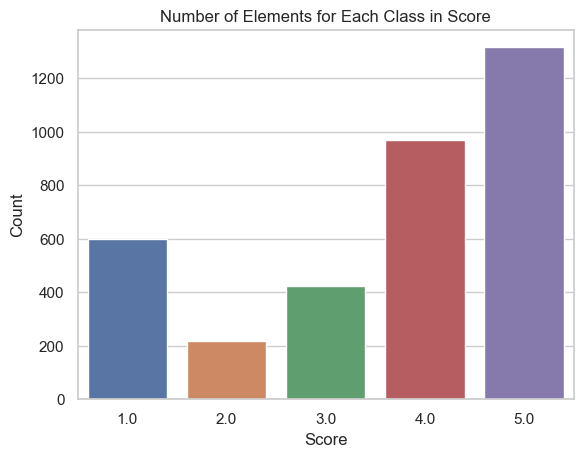

In [113]:
# Show of elements in classes
sns.countplot(x='Score', data=df_reviews)
plt.title('Number of Elements for Each Class in Score')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

Let's then join classes 1-2 and classes 4-5:

In [114]:
def update_scores(dataframe):
    # Update values in the 'Score' column
    dataframe['Score'] = dataframe['Score'].replace({2: 1, 4: 5})
    return dataframe

df_reviews_new = update_scores(df_reviews)

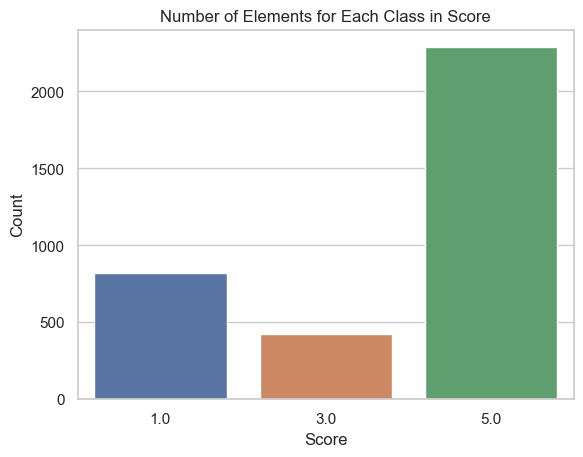

In [115]:
# Show of elements in classes
sns.countplot(x='Score', data=df_reviews)
plt.title('Number of Elements for Each Class in Score')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

No we want to drop reviews from classes 1 and 5 to match number of samples in class 3:

In [116]:
def balance_dataset(dataframe):
    # Separate the dataset based on 'Score'
    class_1 = dataframe[dataframe['Score'] == 1]
    class_3 = dataframe[dataframe['Score'] == 3]
    class_5 = dataframe[dataframe['Score'] == 5]

    # Determine the size of the minority class
    minority_class_size = min(len(class_1), len(class_3), len(class_5))

    # Resample each class to have the same number of samples
    class_1_resampled = resample(class_1, replace=False, n_samples=minority_class_size, random_state=42)
    class_3_resampled = resample(class_3, replace=False, n_samples=minority_class_size, random_state=42)
    class_5_resampled = resample(class_5, replace=False, n_samples=minority_class_size, random_state=42)

    # Concatenate the resampled classes to create a balanced dataset
    balanced_df = pd.concat([class_1_resampled, class_3_resampled, class_5_resampled])

    return balanced_df

balanced_df = balance_dataset(df_reviews_new)

Following graph now shows our balanced dataset:

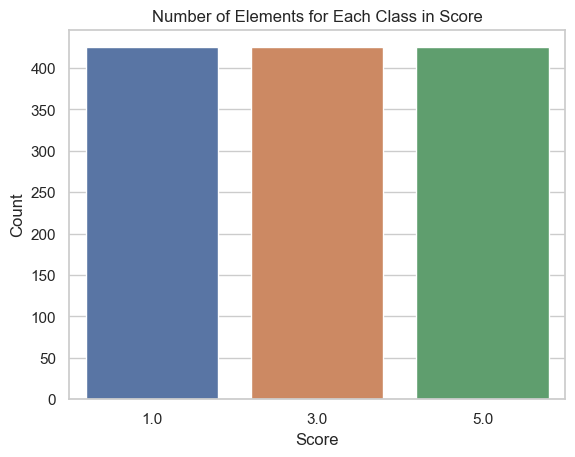

In [117]:
# Show of elements in classes
sns.countplot(x='Score', data=balanced_df)
plt.title('Number of Elements for Each Class in Score')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

Let's now try to retrain the model using the two different vectorization techniques:

In [118]:
# Collect all columns into dataframe named as sentiment_ordering
sentiment_ordering = [1,3,5]

# store all values into column named as "y"
y = df_reviews["Score"]
y = y.apply(lambda x: sentiment_ordering.index(x))

# Instantiate an object cv by calling a method named as CountVectorzer()
cv    = CountVectorizer(max_features = 3000)

# Train the dataset by calling a fit_transform() method
X_fin = cv.fit_transform(cleaned_data).toarray()

# Display the rows and colums
X_fin.shape

# Instantiate an object model by calling a method MultinomialNB()
model = MultinomialNB()

# Split the dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X_fin, y, test_size = 0.3)

# Train the model by calling a method fit()
model.fit(X_train,y_train)

# Call predict() method
y_pred = model.predict(X_test)

# Instantiate a mthod named as Cla
cf = classification_report(y_test, y_pred)

# Display the values of an object cf
print(cf)

              precision    recall  f1-score   support

           0       0.75      0.64      0.69       245
           1       0.31      0.13      0.18       118
           2       0.81      0.93      0.87       696

    accuracy                           0.78      1059
   macro avg       0.63      0.57      0.58      1059
weighted avg       0.74      0.78      0.75      1059



In [119]:
# Create an object 'tf' by calling a method TfidfVectorizer()
tfidf = TfidfVectorizer(max_features = 3000)

# Train the dataset by calling a method fit_tranform() 
X_tfidf = tfidf.fit_transform(cleaned_data).toarray()

# Instantiate an object model by calling a method MultinomialNB()
model_tdidf = MultinomialNB()

# Split the dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.3)

# Train the model by calling a method fit()
model_tdidf.fit(X_train, y_train)

# Call predict() method
y_pred = model_tdidf.predict(X_test)

from sklearn.metrics import classification_report

# Instantiate a mthod named as Cla
cf = classification_report(y_test, y_pred)

# Display the values of an object cf
print(cf)

              precision    recall  f1-score   support

           0       0.80      0.45      0.58       246
           1       1.00      0.01      0.02       127
           2       0.73      0.98      0.84       686

    accuracy                           0.74      1059
   macro avg       0.84      0.48      0.48      1059
weighted avg       0.78      0.74      0.68      1059



When reducing the number of classes, that we can reconduct to negative-neutral-positive, we can see that overall accuracy is increasing.

When comparing the two vectorization methods:
- Method 1 shows a more balanced performance across classes, especially for Class 1 where Method 2 struggles with recall.
- Method 2 achieves perfect precision for Class 1 but at the cost of extremely low recall, indicating that it identifies very few instances of Class 1.

To progress in our study we decide to proceed with a reduced number of classes and method 1 of data vectorization. This is because:
- People travelling multiple countries might have different point of views based on their culter and association of score 2 and 4 might be very differently interpreted, we thus try to reduce this complexity
- Vectorization using CountVectorizer just returned better results in terms of classification reports

In [120]:
# store all values into column named as "y"
y = df_reviews["Score"]
y = y.apply(lambda x: sentiment_ordering.index(x))

# Instantiate an object cv by calling a method named as CountVectorzer()
cv    = CountVectorizer(max_features = 3000)

# Train the dataset by calling a fit_transform() method
X_fin = cv.fit_transform(cleaned_data).toarray()

# Display the rows and colums
X_fin.shape

# Instantiate an object model by calling a method MultinomialNB()
model = MultinomialNB()

# Split the dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X_fin, y, test_size = 0.3)

# Train the model by calling a method fit()
model.fit(X_train,y_train)

# Call predict() method
y_pred = model.predict(X_test)

Starting from our initial dataset review, let's now replace our score column with the score computed by our model.

Reason for this is because we want to try and standardize as much as possible how reviews are classified across countries and different cultures.

In [121]:
# Adding a column with the new calculated score
df_reviews['New Score'] = model.predict(X_fin)

In [122]:
df_reviews

Category       Date                                        Review Text  \
0     France 2023-12-01                          Held up by security thugs   
1     France 2023-11-01                                        Paris metro   
2     France 2023-11-01                                   Robbed by 3 guys   
3     France 2023-11-01  Don’t rely on metro service people. They don’t...   
4     France 2023-10-01                           Do not pay the RATP fine   
..       ...        ...                                                ...   
404  Ireland 2015-06-01                                          Stay away   
405  Ireland 2015-05-01  Travels through Ireland using Public Transport...   
406  Ireland 2015-05-01                                      great service   
407  Ireland 2015-04-01                        Dreadfully run organisation   
408  Ireland 2015-02-01                                Dangerous Disregard   

     Score  Year  New Score  
0      1.0  2023          0  
1      5.0  2023          2  
2      1.0  2023          0  
3      1.0  2023          0  
4      1.0  2023          0  
..     ...   ...        ...  
404    1.0  2015          2  
405    5.0  2015          2  
406    5.0  2015          2  
407    1.0  2015          0  
408    1.0  2015          0  

[3530 rows x 6 columns]

And save the dataframe for dashboarding purposes:

In [123]:
# Saving the dataframe for dashboarding
df_reviews.to_csv("..\Data\df_reviews_dashboard.csv", index=False)

As previously stated, we want to get for each year and for each country, an average sentiment score:

In [124]:
# Calculation of average sentiment score by category and year
df_reviews = df_reviews.groupby(['Category', 'Year'], as_index=False)['New Score'].mean()

In [125]:
df_reviews.head()

Category  Year  New Score
0   France  2012   1.727273
1   France  2013   1.666667
2   France  2014   1.614583
3   France  2015   1.772000
4   France  2016   1.687500

Now for each country we must make sure that we have a sentiment score only for years from 2016 to 2021 available.

In some cases it happens that, for some countries, sentiment score is available for years outside of 2016-2021 and missing for the timeframw 2016-2021 we are interested in.

What we want to do is, for a given country, to compute the average sentiment for all years available. If we are then missing the sentiment for years between 2016 and 2021, we then fill that with the computed average.

Let's now code this:

In [126]:
# Creation of a dataframe containing countries and years from 2013 to 2023 
all_combinations_2013_2023 = pd.DataFrame([(category, year) for category in df_reviews['Category'].unique() for year in range(2013, 2024)],
                                 columns=['Category', 'Year'])

In [127]:
all_combinations_2013_2023

Category  Year
0           France  2013
1           France  2014
2           France  2015
3           France  2016
4           France  2017
..             ...   ...
94  United Kingdom  2019
95  United Kingdom  2020
96  United Kingdom  2021
97  United Kingdom  2022
98  United Kingdom  2023

[99 rows x 2 columns]

In [128]:
# Merge of combinations 2013-2023 with computed averages reviews
all_combinations_2013_2023 = pd.merge(all_combinations_2013_2023, df_reviews, on=['Category', 'Year'], how='left')

In [129]:
all_combinations_2013_2023

Category  Year  New Score
0           France  2013   1.666667
1           France  2014   1.614583
2           France  2015   1.772000
3           France  2016   1.687500
4           France  2017   1.651376
..             ...   ...        ...
94  United Kingdom  2019   1.500000
95  United Kingdom  2020   1.200000
96  United Kingdom  2021   1.600000
97  United Kingdom  2022   0.200000
98  United Kingdom  2023   0.916667

[99 rows x 3 columns]

In [130]:
# Filling of missing years with computed averages
category_avg = df_reviews.groupby('Category')['New Score'].mean()
all_combinations_2013_2023['New Score'] = all_combinations_2013_2023['New Score'].fillna(all_combinations_2013_2023['Category'].map(category_avg))

In [131]:
all_combinations_2013_2023

Category  Year  New Score
0           France  2013   1.666667
1           France  2014   1.614583
2           France  2015   1.772000
3           France  2016   1.687500
4           France  2017   1.651376
..             ...   ...        ...
94  United Kingdom  2019   1.500000
95  United Kingdom  2020   1.200000
96  United Kingdom  2021   1.600000
97  United Kingdom  2022   0.200000
98  United Kingdom  2023   0.916667

[99 rows x 3 columns]

In [132]:
# Check if null rows are present
all_combinations_2013_2023.isnull().sum()

Category     0
Year         0
New Score    0
dtype: int64

And we now restrict the dataset only to years 2016-2021:

In [133]:
# Creation of a dataframe containing countries and years from 2016 to 2021 
all_combinations_2016_2021 = pd.DataFrame([(category, year) for category in df_reviews['Category'].unique() for year in range(2016, 2022)],
                                 columns=['Category', 'Year'])

In [134]:
all_combinations_2016_2021

Category  Year
0           France  2016
1           France  2017
2           France  2018
3           France  2019
4           France  2020
5           France  2021
6          Ireland  2016
7          Ireland  2017
8          Ireland  2018
9          Ireland  2019
10         Ireland  2020
11         Ireland  2021
12          Latvia  2016
13          Latvia  2017
14          Latvia  2018
15          Latvia  2019
16          Latvia  2020
17          Latvia  2021
18           Malta  2016
19           Malta  2017
20           Malta  2018
21           Malta  2019
22           Malta  2020
23           Malta  2021
24          Norway  2016
25          Norway  2017
26          Norway  2018
27          Norway  2019
28          Norway  2020
29          Norway  2021
30          Poland  2016
31          Poland  2017
32          Poland  2018
33          Poland  2019
34          Poland  2020
35          Poland  2021
36        Slovenia  2016
37        Slovenia  2017
38        Slovenia  2018
39        Slovenia  2019
40        Slovenia  2020
41        Slovenia  2021
42           Spain  2016
43           Spain  2017
44           Spain  2018
45           Spain  2019
46           Spain  2020
47           Spain  2021
48  United Kingdom  2016
49  United Kingdom  2017
50  United Kingdom  2018
51  United Kingdom  2019
52  United Kingdom  2020
53  United Kingdom  2021

In [135]:
# Merge of combinations 2016-2021 with computed averages reviews
df_reviews = pd.merge(all_combinations_2016_2021, all_combinations_2013_2023, on=['Category', 'Year'], how='left')

We now create, simplify column naming and take a look at the df that will be used for ML modeling:

In [136]:
# Creation of ml dataframe
df_ml = pd.merge(df_reviews,df.loc[df["Category"].isin(df_reviews.Category.unique())], on=["Category", "Year"], how="right").rename(
    columns={"Category": 'Country', "New Score": "Sentiment", "Passenger Car Traffic": "PCT",
             "Bus and Motor Coach Traffic": "BMCT", "Total Van, Pickup, Lorry and Road Tractor Traffic": "OT"})

In [137]:
df_ml.head()

Country  Year  Sentiment       PCT      BMCT        OT
0  France  2016   1.687500  0.890882  0.011774  0.210606
1  France  2017   1.651376  0.888624  0.011644  0.213811
2  France  2018   1.468880  0.884750  0.011835  0.219108
3  France  2019   1.385321  0.882530  0.011833  0.222198
4  France  2020   1.470588  0.868407  0.009158  0.243108

##### ●	You should train and test for Supervised Learning and other appropriate metrics for unsupervised/ semi-supervised machine learning models that you have chosen. Use cross validation to provide authenticity of the modelling outcomes. You can apply dimensionality reduction methods to prepare the dataset based on your machine learning modelling requirements.
[0 - 30]


For the purpose of building our forecasting model, the followings will be used:
- Linear Regression
- LSTM Neural Network

The reason why we want to experiment with those two models is because they very much differ in their complexity.

Linear Regression is a simple and computationally efficient algorithm. It is easy to implement and understand, making it a good choice for cases where complex interactions between features are not a major concern.

LSTMs are designed to work with sequences of data. They have memory cells that can store and retrieve information over long periods, allowing them to handle sequences of data and capture trends over time.

For each of those two models hyperparameter tuning will occur using GridSearch techniques.

Let's start the modelling of the linear regression model:

##### Machine learning - Linear Regression

In [138]:
# Let's create a copy of the dataframe
df_ml_lr = df_ml.copy()

And define X, y and prepare our data:

In [139]:
# Split data into features and target variables
X = df_ml_lr[['Country', 'Year']]
y = df_ml_lr[['Sentiment', 'PCT', 'BMCT', 'OT']]

# Define the preprocessor with a pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Country'])
    ],
    remainder='passthrough'
)

# Split data into training and testing sets
X_train = X.loc[X["Year"] != 2021]
y_train = y.loc[X["Year"] != 2021]

X_test = X.loc[X["Year"] == 2021]
y_test = y.loc[X["Year"] == 2021]

In the previous section two major tasks happened.

The first one is reagarding the application of OneHotEncoder to convert country names into numerical numbers. This was necessary to not loose important informations during the training of the model.

The second one is about splitting the dataset between test and training. As we want to keep an 80%-20% split, we keep years from 2016 to 2020 as training data and year 2021 as test data.

Now that the data is ready, we can proceed with the modelling. We use a pipeline to make sure that preprocessing (categorization of countries) happens before the modelling:

In [140]:
# Define the pipeline with the preprocessor and the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.02136548490910061


MSE results seems to be already quite good. 
If we look at the LinearRegression function in sklearn, we can see that we can mainly change the following parameters:
- fit_intercept -> Needed to assume if the linear models passes through the origin
- n_jobs -> Used to define how the jobs are splitted with available compute

We don't expect major performance increases given the nature of the model but let's see if we can improve using grid search:

In [141]:
# Define the preprocessor with a pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Country'])
    ],
    remainder='passthrough'
)

# Define the pipeline with the preprocessor and the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__n_jobs': [-3, -2, -1, 0, 1, 2, 3],
    'regressor__fit_intercept': [True, False]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

# Split data into training and testing sets
X_train = X.loc[X["Year"] != 2021]
y_train = y.loc[X["Year"] != 2021]

X_test = X.loc[X["Year"] == 2021]
y_test = y.loc[X["Year"] == 2021]

# Perform GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the testing set
predictions = best_model.predict(X_test)

# Evaluate the best model
mse = mean_squared_error(y_test, predictions)
print(f'Best Model Mean Squared Error: {mse}')

# Print the best hyperparameters found by GridSearchCV
print('Best Hyperparameters:', grid_search.best_params_)


Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Model Mean Squared Error: 0.023844407326255576
Best Hyperparameters: {'regressor__fit_intercept': False, 'regressor__n_jobs': -3}


As expected, the MSE is quite similar to the previous run.

##### NN using LSTM

Let's see if we can now get better results using neural networks.

In [142]:
# Create a copy of the dataframe
df_ml_nn = df_ml.copy()

The first neural network we want to build is the easiest one, the dense neural network.

Some preprocessing is needed again to encode the name of the countries and create a split between test and training.

In this case years are not ranging anymore from 2016 to 2021 but instead from 0 to 5:

In [143]:
# Preprocessing
label_encoder = LabelEncoder()
df_ml_nn['Country'] = label_encoder.fit_transform(df_ml_nn['Country'])

df_ml_nn['Year'] = df_ml_nn['Year'] - df_ml_nn['Year'].min()

# Define features and target variables
X = df_ml_nn[['Country', 'Year']]
y = df_ml_nn[['Sentiment', 'PCT', 'BMCT', 'OT']]

# Train-test split
X_train = X.loc[X["Year"] != 5]
y_train = y.loc[X["Year"] != 5]

X_test = X.loc[X["Year"] == 5]
y_test = y.loc[X["Year"] == 5]

And we can now build and train our neural network:



Epoch 1/50

3/3 [==============================] - 1s 100ms/step - loss: 1.5698 - val_loss: 1.7898
Epoch 2/50
3/3 [==============================] - 0s 21ms/step - loss: 1.2219 - val_loss: 1.1986
Epoch 3/50
3/3 [==============================] - 0s 24ms/step - loss: 0.9436 - val_loss: 0.7979
Epoch 4/50
3/3 [==============================] - 0s 26ms/step - loss: 0.7347 - val_loss: 0.5046
Epoch 5/50
3/3 [==============================] - 0s 22ms/step - loss: 0.5748 - val_loss: 0.3034
Epoch 6/50
3/3 [==============================] - 0s 22ms/step - loss: 0.4427 - val_loss: 0.1905
Epoch 7/50
3/3 [==============================] - 0s 22ms/step - loss: 0.3508 - val_loss: 0.1469
Epoch 8/50
3/3 [==============================] - 0s 24ms/step - loss: 0.2849 - val_loss: 0.1602
Epoch 9/50
3/3 [==============================] - 0s 24ms/step - loss: 0.2404 - val_loss: 0.2073
Epoch 10/50
3/3 [==============================] - 0s 24ms/step - loss: 0.2129 - val_loss: 0.2720
Epoch 11/50
3/3 [========

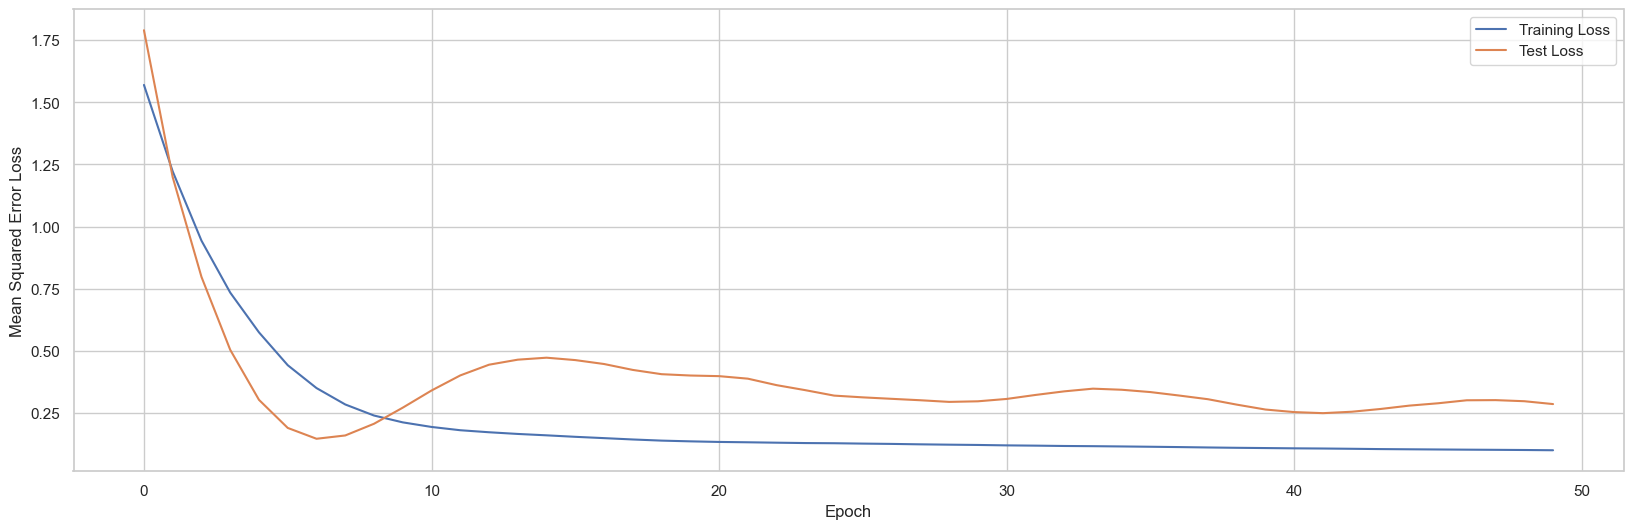

1/1 [==============================] - 0s 46ms/step - loss: 0.2218
Mean Squared Error on Test Data: 0.22175346314907074


In [147]:
# Build the Neural Network
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model and get the history
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# Plot the training and test losses
plt.figure(figsize=(20, 6))  # Set the size of the figure
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')  # Change to 'Test Loss'
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss}')

Even if there is no sign of overfitting or underfitting from the plotted graph, the MSE is quite high - about 10x the MSE produced by the linear regression model.

This is a sign that a neural network might be too complex to solve our forecasting problem. Let's see if an LSTM would produce better results than a DNN:

Epoch 1/50
3/3 [==============================] - 2s 151ms/step - loss: 0.7847 - val_loss: 0.7342
Epoch 2/50
3/3 [==============================] - 0s 20ms/step - loss: 0.7460 - val_loss: 0.6645
Epoch 3/50
3/3 [==============================] - 0s 20ms/step - loss: 0.7077 - val_loss: 0.5934
Epoch 4/50
3/3 [==============================] - 0s 21ms/step - loss: 0.6674 - val_loss: 0.5224
Epoch 5/50
3/3 [==============================] - 0s 22ms/step - loss: 0.6271 - val_loss: 0.4520
Epoch 6/50
3/3 [==============================] - 0s 20ms/step - loss: 0.5852 - val_loss: 0.3834
Epoch 7/50
3/3 [==============================] - 0s 23ms/step - loss: 0.5434 - val_loss: 0.3174
Epoch 8/50
3/3 [==============================] - 0s 19ms/step - loss: 0.5026 - val_loss: 0.2550
Epoch 9/50
3/3 [==============================] - 0s 20ms/step - loss: 0.4587 - val_loss: 0.1982
Epoch 10/50
3/3 [==============================] - 0s 21ms/step - loss: 0.4176 - val_loss: 0.1463
Epoch 11/50
3/3 [===========

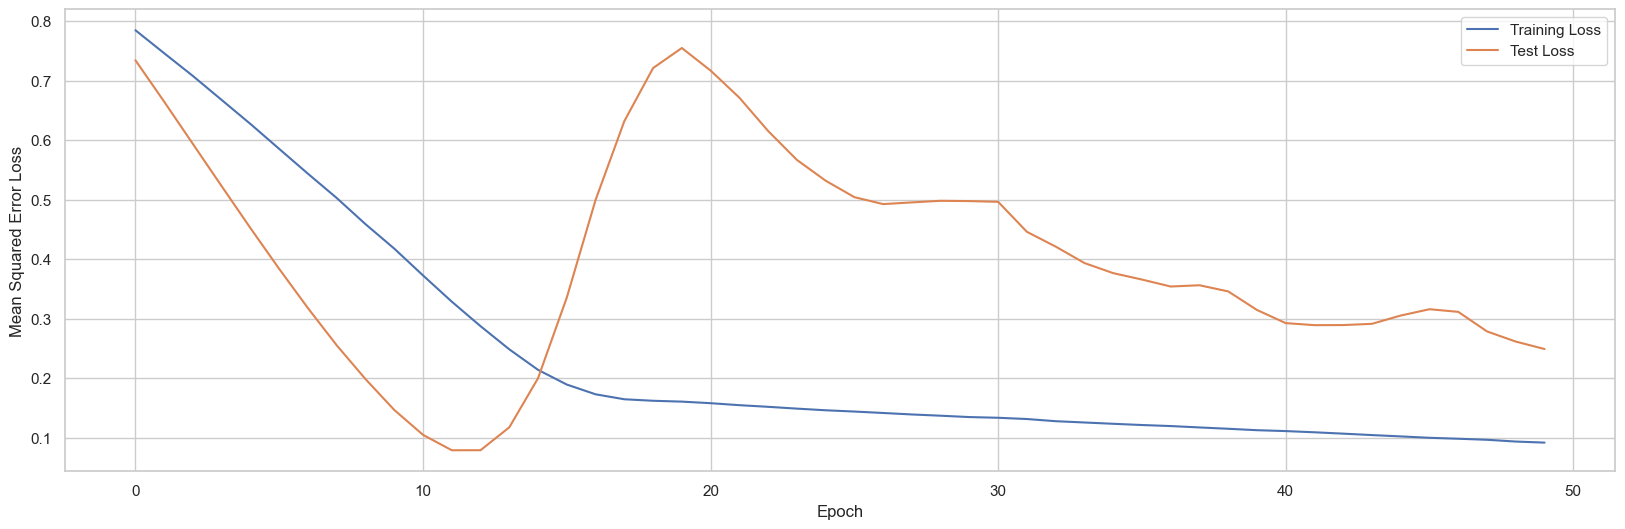

1/1 [==============================] - 0s 38ms/step - loss: 0.1480
Mean Squared Error on Test Data: 0.14801478385925293


In [148]:
# Preprocessing
label_encoder = LabelEncoder()
df_ml_nn['Country'] = label_encoder.fit_transform(df_ml_nn['Country'])

df_ml_nn['Year'] = df_ml_nn['Year'] - df_ml_nn['Year'].min()

# Define features and target variables
X = df_ml_nn[['Country', 'Year']]
y = df_ml_nn[['Sentiment', 'PCT', 'BMCT', 'OT']]

# Train-test split
X_train = X.loc[X["Year"] != 5]
y_train = y.loc[X["Year"] != 5]

X_test = X.loc[X["Year"] == 5]
y_test = y.loc[X["Year"] == 5]

# Build the Neural Network
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1), activation="relu"))
model.add(Dense(4, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model and get the history
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# Plot the training and test losses
plt.figure(figsize=(20, 6))  # Set the size of the figure
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')  # Change to 'Test Loss'
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss}')

Even though it's quite clear that more epoches would have been needed to get better results, we can immediatelly see that MSE is reducing, meaning that LSTM is giving better results than DNN.

Let's see what happens if we apply gridsearch:

In [149]:
# Preprocessing
label_encoder = LabelEncoder()
df_ml_nn['Country'] = label_encoder.fit_transform(df_ml_nn['Country'])

df_ml_nn['Year'] = df_ml_nn['Year'] - df_ml_nn['Year'].min()

# Define features and target variables
X = df_ml_nn[['Country', 'Year']]
y = df_ml_nn[['Sentiment', 'PCT', 'BMCT', 'OT']]

# Train-test split
X_train = X.loc[X["Year"] != 5]
y_train = y.loc[X["Year"] != 5]

X_test = X.loc[X["Year"] == 5]
y_test = y.loc[X["Year"] == 5]

# Function to create model
def create_model(neurons_layer1=64, optimizer='adam', activation_layer1='relu'):
    model = Sequential()
    model.add(LSTM(neurons_layer1, input_shape=(X_train.shape[1], 1), activation=activation_layer1))
    model.add(Dense(4, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Create KerasRegressor
regressor = KerasRegressor(build_fn=create_model, epochs=50, verbose=1)

# Parameter grid for GridSearchCV
param_grid = {
    'neurons_layer1': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [8, 16, 32],
    'activation_layer1': ['relu', 'sigmoid', 'tanh']
}

# Mean squared error scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# GridSearchCV
start_time_gridsearch = time.time()
grid = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3, scoring=mse_scorer, verbose=1)
grid_result = grid.fit(X_train, y_train)
end_time_gridsearch = time.time()

# Display best parameters
print("Best parameters found: ", grid_result.best_params_)

# Evaluate the best model
best_model = grid_result.best_estimator_
start_time_evaluation = time.time()
loss = best_model.score(X_test, y_test)
end_time_evaluation = time.time()
print(f'Mean Squared Error on Test Data: {loss}')

# Print timing information
print(f'Time taken for GridSearchCV: {end_time_gridsearch - start_time_gridsearch} seconds')
print(f'Time taken for model evaluation: {end_time_evaluation - start_time_evaluation} seconds')

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Epoch 1/50
4/4 [==============================] - 1s 3ms/step - loss: 0.7164
Epoch 2/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6509
Epoch 3/50
4/4 [==============================] - 0s 4ms/step - loss: 0.5895
Epoch 4/50
4/4 [==============================] - 0s 4ms/step - loss: 0.5319
Epoch 5/50
4/4 [==============================] - 0s 3ms/step - loss: 0.4793
Epoch 6/50
4/4 [==============================] - 0s 11ms/step - loss: 0.4284
Epoch 7/50
4/4 [==============================] - 0s 5ms/step - loss: 0.3847
Epoch 8/50
4/4 [==============================] - 0s 3ms/step - loss: 0.3409
Epoch 9/50
4/4 [==============================] - 0s 3ms/step - loss: 0.3035
Epoch 10/50
4/4 [==============================] - 0s 3ms/step - loss: 0.2698
Epoch 11/50
4/4 [==============================] - 0s 3ms/step - loss: 0.2403
Epoch 12/50
4/4 [==============================] - 0s 3ms/step - loss: 0.2162
Epoch 13/5

4/4 [==============================] - 0s 3ms/step - loss: 0.6218
Epoch 5/50
4/4 [==============================] - 0s 3ms/step - loss: 0.5857
Epoch 6/50
4/4 [==============================] - 0s 3ms/step - loss: 0.5488
Epoch 7/50
4/4 [==============================] - 0s 4ms/step - loss: 0.5119
Epoch 8/50
4/4 [==============================] - 0s 3ms/step - loss: 0.4768
Epoch 9/50
4/4 [==============================] - 0s 4ms/step - loss: 0.4401
Epoch 10/50
4/4 [==============================] - 0s 3ms/step - loss: 0.4016
Epoch 11/50
4/4 [==============================] - 0s 4ms/step - loss: 0.3688
Epoch 12/50
4/4 [==============================] - 0s 3ms/step - loss: 0.3338
Epoch 13/50
4/4 [==============================] - 0s 3ms/step - loss: 0.2991
Epoch 14/50
4/4 [==============================] - 0s 3ms/step - loss: 0.2677
Epoch 15/50
4/4 [==============================] - 0s 4ms/step - loss: 0.2387
Epoch 16/50
4/4 [==============================] - 0s 3ms/step - loss: 0.2143
Epo

4/4 [==============================] - 0s 4ms/step - loss: 0.2764
Epoch 9/50
4/4 [==============================] - 0s 4ms/step - loss: 0.2484
Epoch 10/50
4/4 [==============================] - 0s 3ms/step - loss: 0.2236
Epoch 11/50
4/4 [==============================] - 0s 4ms/step - loss: 0.2030
Epoch 12/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1885
Epoch 13/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1782
Epoch 14/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1708
Epoch 15/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1654
Epoch 16/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1610
Epoch 17/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1591
Epoch 18/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1551
Epoch 19/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1524
Epoch 20/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1494

2/2 [==============================] - 0s 3ms/step
Epoch 1/50
4/4 [==============================] - 1s 4ms/step - loss: 0.8436
Epoch 2/50
4/4 [==============================] - 0s 4ms/step - loss: 0.7761
Epoch 3/50
4/4 [==============================] - 0s 4ms/step - loss: 0.7118
Epoch 4/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6496
Epoch 5/50
4/4 [==============================] - 0s 4ms/step - loss: 0.5848
Epoch 6/50
4/4 [==============================] - 0s 4ms/step - loss: 0.5189
Epoch 7/50
4/4 [==============================] - 0s 4ms/step - loss: 0.4519
Epoch 8/50
4/4 [==============================] - 0s 4ms/step - loss: 0.3863
Epoch 9/50
4/4 [==============================] - 0s 4ms/step - loss: 0.3191
Epoch 10/50
4/4 [==============================] - 0s 4ms/step - loss: 0.2571
Epoch 11/50
4/4 [==============================] - 0s 5ms/step - loss: 0.2042
Epoch 12/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1656
Epoch 13/50
4/4 [=====

4/4 [==============================] - 0s 3ms/step - loss: 0.7278
Epoch 5/50
4/4 [==============================] - 0s 3ms/step - loss: 0.6843
Epoch 6/50
4/4 [==============================] - 0s 5ms/step - loss: 0.6409
Epoch 7/50
4/4 [==============================] - 0s 3ms/step - loss: 0.5986
Epoch 8/50
4/4 [==============================] - 0s 3ms/step - loss: 0.5502
Epoch 9/50
4/4 [==============================] - 0s 3ms/step - loss: 0.5046
Epoch 10/50
4/4 [==============================] - 0s 3ms/step - loss: 0.4523
Epoch 11/50
4/4 [==============================] - 0s 3ms/step - loss: 0.3977
Epoch 12/50
4/4 [==============================] - 0s 3ms/step - loss: 0.3438
Epoch 13/50
4/4 [==============================] - 0s 3ms/step - loss: 0.2854
Epoch 14/50
4/4 [==============================] - 0s 3ms/step - loss: 0.2314
Epoch 15/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1817
Epoch 16/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1507
Epo

4/4 [==============================] - 0s 3ms/step - loss: 0.1929
Epoch 9/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1790
Epoch 10/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1712
Epoch 11/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1653
Epoch 12/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1602
Epoch 13/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1574
Epoch 14/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1526
Epoch 15/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1492
Epoch 16/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1462
Epoch 17/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1404
Epoch 18/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1367
Epoch 19/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1326
Epoch 20/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1319

4/4 [==============================] - 0s 4ms/step - loss: 0.1339
Epoch 13/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1254
Epoch 14/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1254
Epoch 15/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1231
Epoch 16/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1201
Epoch 17/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1160
Epoch 18/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1120
Epoch 19/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1093
Epoch 20/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1075
Epoch 21/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1051
Epoch 22/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1021
Epoch 23/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0989
Epoch 24/50
4/4 [==============================] - 0s 4ms/step - loss: 0.096

4/4 [==============================] - 0s 4ms/step - loss: 0.1252
Epoch 17/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1197
Epoch 18/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1166
Epoch 19/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1140
Epoch 20/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1102
Epoch 21/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1062
Epoch 22/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1025
Epoch 23/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0990
Epoch 24/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0961
Epoch 25/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0923
Epoch 26/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0881
Epoch 27/50
4/4 [==============================] - 0s 6ms/step - loss: 0.0841
Epoch 28/50
4/4 [==============================] - 0s 4ms/step - loss: 0.081

4/4 [==============================] - 0s 5ms/step - loss: 0.1137
Epoch 21/50
4/4 [==============================] - 0s 6ms/step - loss: 0.1102
Epoch 22/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1081
Epoch 23/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1018
Epoch 24/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0997
Epoch 25/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0973
Epoch 26/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0920
Epoch 27/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0896
Epoch 28/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0857
Epoch 29/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0826
Epoch 30/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0800
Epoch 31/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0780
Epoch 32/50
4/4 [==============================] - 0s 5ms/step - loss: 0.074

2/2 [==============================] - 0s 7ms/step - loss: 0.3534
Epoch 25/50
2/2 [==============================] - 0s 7ms/step - loss: 0.3294
Epoch 26/50
2/2 [==============================] - 0s 5ms/step - loss: 0.3061
Epoch 27/50
2/2 [==============================] - 0s 6ms/step - loss: 0.2823
Epoch 28/50
2/2 [==============================] - 0s 6ms/step - loss: 0.2596
Epoch 29/50
2/2 [==============================] - 0s 6ms/step - loss: 0.2391
Epoch 30/50
2/2 [==============================] - 0s 6ms/step - loss: 0.2202
Epoch 31/50
2/2 [==============================] - 0s 7ms/step - loss: 0.2015
Epoch 32/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1865
Epoch 33/50
2/2 [==============================] - 0s 7ms/step - loss: 0.1723
Epoch 34/50
2/2 [==============================] - 0s 7ms/step - loss: 0.1630
Epoch 35/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1551
Epoch 36/50
2/2 [==============================] - 0s 7ms/step - loss: 0.149

2/2 [==============================] - 0s 5ms/step - loss: 0.4363
Epoch 29/50
2/2 [==============================] - 0s 5ms/step - loss: 0.4186
Epoch 30/50
2/2 [==============================] - 0s 7ms/step - loss: 0.4021
Epoch 31/50
2/2 [==============================] - 0s 6ms/step - loss: 0.3828
Epoch 32/50
2/2 [==============================] - 0s 9ms/step - loss: 0.3647
Epoch 33/50
2/2 [==============================] - 0s 6ms/step - loss: 0.3460
Epoch 34/50
2/2 [==============================] - 0s 8ms/step - loss: 0.3288
Epoch 35/50
2/2 [==============================] - 0s 7ms/step - loss: 0.3100
Epoch 36/50
2/2 [==============================] - 0s 8ms/step - loss: 0.2899
Epoch 37/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2732
Epoch 38/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2552
Epoch 39/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2387
Epoch 40/50
2/2 [==============================] - 0s 6ms/step - loss: 0.221

2/2 [==============================] - 0s 5ms/step - loss: 0.1400
Epoch 33/50
2/2 [==============================] - 0s 4ms/step - loss: 0.1381
Epoch 34/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1366
Epoch 35/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1350
Epoch 36/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1341
Epoch 37/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1314
Epoch 38/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1300
Epoch 39/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1278
Epoch 40/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1270
Epoch 41/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1244
Epoch 42/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1273
Epoch 43/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1213
Epoch 44/50
2/2 [==============================] - 0s 6ms/step - loss: 0.119

2/2 [==============================] - 0s 6ms/step - loss: 0.1231
Epoch 37/50
2/2 [==============================] - 0s 4ms/step - loss: 0.1215
Epoch 38/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1196
Epoch 39/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1183
Epoch 40/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1174
Epoch 41/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1159
Epoch 42/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1148
Epoch 43/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1133
Epoch 44/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1124
Epoch 45/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1110
Epoch 46/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1099
Epoch 47/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1086
Epoch 48/50
2/2 [==============================] - 0s 5ms/step - loss: 0.107

2/2 [==============================] - 0s 6ms/step - loss: 0.1374
Epoch 41/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1348
Epoch 42/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1318
Epoch 43/50
2/2 [==============================] - 0s 7ms/step - loss: 0.1301
Epoch 44/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1278
Epoch 45/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1266
Epoch 46/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1248
Epoch 47/50
2/2 [==============================] - 0s 4ms/step - loss: 0.1233
Epoch 48/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1219
Epoch 49/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1206
Epoch 50/50
1/1 [==============================] - 0s 198ms/step
Epoch 1/50
2/2 [==============================] - 1s 5ms/step - loss: 0.8373
Epoch 2/50
2/2 [==============================] - 0s 5ms/step - loss: 0.7350
Epoch 3/50
2/

2/2 [==============================] - 0s 7ms/step - loss: 0.1290
Epoch 45/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1254
Epoch 46/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1240
Epoch 47/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1218
Epoch 48/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1204
Epoch 49/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1182
Epoch 50/50
1/1 [==============================] - 0s 183ms/step
Epoch 1/50
2/2 [==============================] - 2s 5ms/step - loss: 0.7774
Epoch 2/50
2/2 [==============================] - 0s 4ms/step - loss: 0.7085
Epoch 3/50
2/2 [==============================] - 0s 5ms/step - loss: 0.6619
Epoch 4/50
2/2 [==============================] - 0s 4ms/step - loss: 0.6240
Epoch 5/50
2/2 [==============================] - 0s 4ms/step - loss: 0.5898
Epoch 6/50
2/2 [==============================] - 0s 6ms/step - loss: 0.5575
Epoch 7/50
2/2 [=

2/2 [==============================] - 0s 7ms/step - loss: 0.0989
Epoch 49/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0974
Epoch 50/50
1/1 [==============================] - 0s 210ms/step
Epoch 1/50
2/2 [==============================] - 1s 5ms/step - loss: 0.8084
Epoch 2/50
2/2 [==============================] - 0s 6ms/step - loss: 0.7583
Epoch 3/50
2/2 [==============================] - 0s 5ms/step - loss: 0.7151
Epoch 4/50
2/2 [==============================] - 0s 6ms/step - loss: 0.6696
Epoch 5/50
2/2 [==============================] - 0s 6ms/step - loss: 0.6302
Epoch 6/50
2/2 [==============================] - 0s 6ms/step - loss: 0.5892
Epoch 7/50
2/2 [==============================] - 0s 7ms/step - loss: 0.5520
Epoch 8/50
2/2 [==============================] - 0s 6ms/step - loss: 0.5130
Epoch 9/50
2/2 [==============================] - 0s 6ms/step - loss: 0.4760
Epoch 10/50
2/2 [==============================] - 0s 5ms/step - loss: 0.4363
Epoch 11/50
2/2 [===

2/2 [==============================] - 1s 7ms/step - loss: 0.7477
Epoch 2/50
2/2 [==============================] - 0s 4ms/step - loss: 0.6015
Epoch 3/50
2/2 [==============================] - 0s 5ms/step - loss: 0.4957
Epoch 4/50
2/2 [==============================] - 0s 5ms/step - loss: 0.4069
Epoch 5/50
2/2 [==============================] - 0s 5ms/step - loss: 0.3318
Epoch 6/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2705
Epoch 7/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2218
Epoch 8/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1864
Epoch 9/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1633
Epoch 10/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1504
Epoch 11/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1451
Epoch 12/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1395
Epoch 13/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1372
Epoch 

2/2 [==============================] - 0s 5ms/step - loss: 0.5726
Epoch 6/50
2/2 [==============================] - 0s 6ms/step - loss: 0.5303
Epoch 7/50
2/2 [==============================] - 0s 5ms/step - loss: 0.4906
Epoch 8/50
2/2 [==============================] - 0s 5ms/step - loss: 0.4524
Epoch 9/50
2/2 [==============================] - 0s 6ms/step - loss: 0.4156
Epoch 10/50
2/2 [==============================] - 0s 5ms/step - loss: 0.3798
Epoch 11/50
2/2 [==============================] - 0s 5ms/step - loss: 0.3449
Epoch 12/50
2/2 [==============================] - 0s 6ms/step - loss: 0.3125
Epoch 13/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2818
Epoch 14/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2531
Epoch 15/50
2/2 [==============================] - 0s 6ms/step - loss: 0.2271
Epoch 16/50
2/2 [==============================] - 0s 6ms/step - loss: 0.2037
Epoch 17/50
2/2 [==============================] - 0s 4ms/step - loss: 0.1846
Ep

1/1 [==============================] - 0s 7ms/step - loss: 0.5147
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 0.5048
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 0.4950
Epoch 12/50
1/1 [==============================] - 0s 5ms/step - loss: 0.4853
Epoch 13/50
1/1 [==============================] - 0s 7ms/step - loss: 0.4756
Epoch 14/50
1/1 [==============================] - 0s 6ms/step - loss: 0.4659
Epoch 15/50
1/1 [==============================] - 0s 6ms/step - loss: 0.4562
Epoch 16/50
1/1 [==============================] - 0s 7ms/step - loss: 0.4465
Epoch 17/50
1/1 [==============================] - 0s 5ms/step - loss: 0.4369
Epoch 18/50
1/1 [==============================] - 0s 7ms/step - loss: 0.4274
Epoch 19/50
1/1 [==============================] - 0s 6ms/step - loss: 0.4179
Epoch 20/50
1/1 [==============================] - 0s 7ms/step - loss: 0.4085
Epoch 21/50
1/1 [==============================] - 0s 6ms/step - loss: 0.399

1/1 [==============================] - 0s 6ms/step - loss: 0.5727
Epoch 14/50
1/1 [==============================] - 0s 6ms/step - loss: 0.5551
Epoch 15/50
1/1 [==============================] - 0s 6ms/step - loss: 0.5378
Epoch 16/50
1/1 [==============================] - 0s 6ms/step - loss: 0.5206
Epoch 17/50
1/1 [==============================] - 0s 7ms/step - loss: 0.5034
Epoch 18/50
1/1 [==============================] - 0s 5ms/step - loss: 0.4863
Epoch 19/50
1/1 [==============================] - 0s 7ms/step - loss: 0.4693
Epoch 20/50
1/1 [==============================] - 0s 6ms/step - loss: 0.4525
Epoch 21/50
1/1 [==============================] - 0s 6ms/step - loss: 0.4360
Epoch 22/50
1/1 [==============================] - 0s 6ms/step - loss: 0.4196
Epoch 23/50
1/1 [==============================] - 0s 5ms/step - loss: 0.4034
Epoch 24/50
1/1 [==============================] - 0s 6ms/step - loss: 0.3873
Epoch 25/50
1/1 [==============================] - 0s 5ms/step - loss: 0.371

1/1 [==============================] - 0s 6ms/step - loss: 0.7005
Epoch 18/50
1/1 [==============================] - 0s 6ms/step - loss: 0.6919
Epoch 19/50
1/1 [==============================] - 0s 6ms/step - loss: 0.6834
Epoch 20/50
1/1 [==============================] - 0s 6ms/step - loss: 0.6748
Epoch 21/50
1/1 [==============================] - 0s 5ms/step - loss: 0.6661
Epoch 22/50
1/1 [==============================] - 0s 6ms/step - loss: 0.6571
Epoch 23/50
1/1 [==============================] - 0s 6ms/step - loss: 0.6481
Epoch 24/50
1/1 [==============================] - 0s 6ms/step - loss: 0.6389
Epoch 25/50
1/1 [==============================] - 0s 6ms/step - loss: 0.6295
Epoch 26/50
1/1 [==============================] - 0s 6ms/step - loss: 0.6203
Epoch 27/50
1/1 [==============================] - 0s 6ms/step - loss: 0.6111
Epoch 28/50
1/1 [==============================] - 0s 6ms/step - loss: 0.6020
Epoch 29/50
1/1 [==============================] - 0s 7ms/step - loss: 0.592

1/1 [==============================] - 0s 6ms/step - loss: 0.4860
Epoch 22/50
1/1 [==============================] - 0s 6ms/step - loss: 0.4699
Epoch 23/50
1/1 [==============================] - 0s 6ms/step - loss: 0.4540
Epoch 24/50
1/1 [==============================] - 0s 7ms/step - loss: 0.4382
Epoch 25/50
1/1 [==============================] - 0s 6ms/step - loss: 0.4225
Epoch 26/50
1/1 [==============================] - 0s 7ms/step - loss: 0.4069
Epoch 27/50
1/1 [==============================] - 0s 7ms/step - loss: 0.3915
Epoch 28/50
1/1 [==============================] - 0s 8ms/step - loss: 0.3762
Epoch 29/50
1/1 [==============================] - 0s 8ms/step - loss: 0.3611
Epoch 30/50
1/1 [==============================] - 0s 6ms/step - loss: 0.3463
Epoch 31/50
1/1 [==============================] - 0s 6ms/step - loss: 0.3317
Epoch 32/50
1/1 [==============================] - 0s 6ms/step - loss: 0.3173
Epoch 33/50
1/1 [==============================] - 0s 8ms/step - loss: 0.303

1/1 [==============================] - 0s 8ms/step - loss: 0.2217
Epoch 26/50
1/1 [==============================] - 0s 6ms/step - loss: 0.2084
Epoch 27/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1963
Epoch 28/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1853
Epoch 29/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1754
Epoch 30/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1666
Epoch 31/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1590
Epoch 32/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1524
Epoch 33/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1467
Epoch 34/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1421
Epoch 35/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1382
Epoch 36/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1350
Epoch 37/50
1/1 [==============================] - 0s 8ms/step - loss: 0.132

1/1 [==============================] - 0s 8ms/step - loss: 0.2777
Epoch 30/50
1/1 [==============================] - 0s 7ms/step - loss: 0.2663
Epoch 31/50
1/1 [==============================] - 0s 7ms/step - loss: 0.2553
Epoch 32/50
1/1 [==============================] - 0s 7ms/step - loss: 0.2449
Epoch 33/50
1/1 [==============================] - 0s 7ms/step - loss: 0.2348
Epoch 34/50
1/1 [==============================] - 0s 8ms/step - loss: 0.2253
Epoch 35/50
1/1 [==============================] - 0s 7ms/step - loss: 0.2163
Epoch 36/50
1/1 [==============================] - 0s 7ms/step - loss: 0.2078
Epoch 37/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1999
Epoch 38/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1925
Epoch 39/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1857
Epoch 40/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1795
Epoch 41/50
1/1 [==============================] - 0s 8ms/step - loss: 0.173

1/1 [==============================] - 0s 7ms/step - loss: 0.1829
Epoch 34/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1829
Epoch 35/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1826
Epoch 36/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1818
Epoch 37/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1803
Epoch 38/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1781
Epoch 39/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1755
Epoch 40/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1726
Epoch 41/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1695
Epoch 42/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1665
Epoch 43/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1637
Epoch 44/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1610
Epoch 45/50
1/1 [==============================] - 0s 8ms/step - loss: 0.158

1/1 [==============================] - 0s 7ms/step - loss: 0.1334
Epoch 38/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1322
Epoch 39/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1311
Epoch 40/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1300
Epoch 41/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1288
Epoch 42/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1276
Epoch 43/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1264
Epoch 44/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1252
Epoch 45/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1239
Epoch 46/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1226
Epoch 47/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1213
Epoch 48/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1201
Epoch 49/50
1/1 [==============================] - 0s 11ms/step - loss: 0.11

1/1 [==============================] - 0s 10ms/step - loss: 0.1402
Epoch 42/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1383
Epoch 43/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1366
Epoch 44/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1351
Epoch 45/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1338
Epoch 46/50
1/1 [==============================] - 0s 10ms/step - loss: 0.1326
Epoch 47/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1314
Epoch 48/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1303
Epoch 49/50
1/1 [==============================] - 0s 13ms/step - loss: 0.1292
Epoch 50/50
1/1 [==============================] - 0s 192ms/step
Epoch 1/50
4/4 [==============================] - 1s 3ms/step - loss: 0.7223
Epoch 2/50
4/4 [==============================] - 0s 3ms/step - loss: 0.6206
Epoch 3/50
4/4 [==============================] - 0s 3ms/step - loss: 0.5251
Epoch 4/50


4/4 [==============================] - 0s 3ms/step - loss: 0.0586
Epoch 46/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0583
Epoch 47/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0582
Epoch 48/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0580
Epoch 49/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0580
Epoch 50/50
2/2 [==============================] - 0s 3ms/step
Epoch 1/50
4/4 [==============================] - 1s 3ms/step - loss: 1.1729
Epoch 2/50
4/4 [==============================] - 0s 4ms/step - loss: 1.0561
Epoch 3/50
4/4 [==============================] - 0s 4ms/step - loss: 0.9497
Epoch 4/50
4/4 [==============================] - 0s 4ms/step - loss: 0.8538
Epoch 5/50
4/4 [==============================] - 0s 4ms/step - loss: 0.7668
Epoch 6/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6897
Epoch 7/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6201
Epoch 8/50
4/4 [====

4/4 [==============================] - 0s 4ms/step - loss: 0.0235
Epoch 50/50
2/2 [==============================] - 0s 4ms/step
Epoch 1/50
4/4 [==============================] - 1s 3ms/step - loss: 0.8728
Epoch 2/50
4/4 [==============================] - 0s 3ms/step - loss: 0.6917
Epoch 3/50
4/4 [==============================] - 0s 3ms/step - loss: 0.5774
Epoch 4/50
4/4 [==============================] - 0s 3ms/step - loss: 0.4891
Epoch 5/50
4/4 [==============================] - 0s 3ms/step - loss: 0.4153
Epoch 6/50
4/4 [==============================] - 0s 3ms/step - loss: 0.3510
Epoch 7/50
4/4 [==============================] - 0s 3ms/step - loss: 0.2970
Epoch 8/50
4/4 [==============================] - 0s 3ms/step - loss: 0.2497
Epoch 9/50
4/4 [==============================] - 0s 3ms/step - loss: 0.2091
Epoch 10/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1748
Epoch 11/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1444
Epoch 12/50
4/4 [=====

4/4 [==============================] - 0s 4ms/step - loss: 0.2789
Epoch 3/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1549
Epoch 4/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0808
Epoch 5/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0395
Epoch 6/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0278
Epoch 7/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0269
Epoch 8/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0318
Epoch 9/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0341
Epoch 10/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0323
Epoch 11/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0276
Epoch 12/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 13/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0241
Epoch 14/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0241
Epoch

4/4 [==============================] - 0s 4ms/step - loss: 0.3326
Epoch 7/50
4/4 [==============================] - 0s 4ms/step - loss: 0.2421
Epoch 8/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1758
Epoch 9/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1325
Epoch 10/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1049
Epoch 11/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0873
Epoch 12/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0799
Epoch 13/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0789
Epoch 14/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0780
Epoch 15/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0783
Epoch 16/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0788
Epoch 17/50
4/4 [==============================] - 0s 6ms/step - loss: 0.0786
Epoch 18/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0781
E

4/4 [==============================] - 0s 3ms/step - loss: 0.0789
Epoch 11/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0681
Epoch 12/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0626
Epoch 13/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0613
Epoch 14/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0597
Epoch 15/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0598
Epoch 16/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0600
Epoch 17/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0610
Epoch 18/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0607
Epoch 19/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0596
Epoch 20/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0612
Epoch 21/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0586
Epoch 22/50
4/4 [==============================] - 0s 4ms/step - loss: 0.058

4/4 [==============================] - 0s 5ms/step - loss: 0.0247
Epoch 15/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0237
Epoch 16/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0236
Epoch 17/50
4/4 [==============================] - 0s 6ms/step - loss: 0.0238
Epoch 18/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0236
Epoch 19/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0234
Epoch 20/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0231
Epoch 21/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0231
Epoch 22/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0230
Epoch 23/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0231
Epoch 24/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0229
Epoch 25/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0227
Epoch 26/50
4/4 [==============================] - 0s 5ms/step - loss: 0.022

4/4 [==============================] - 0s 4ms/step - loss: 0.0723
Epoch 19/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0717
Epoch 20/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0717
Epoch 21/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0720
Epoch 22/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0708
Epoch 23/50
4/4 [==============================] - 0s 6ms/step - loss: 0.0709
Epoch 24/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0710
Epoch 25/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0706
Epoch 26/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0698
Epoch 27/50
4/4 [==============================] - 0s 6ms/step - loss: 0.0703
Epoch 28/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0706
Epoch 29/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0693
Epoch 30/50
4/4 [==============================] - 0s 5ms/step - loss: 0.069

4/4 [==============================] - 0s 4ms/step - loss: 0.0584
Epoch 23/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0573
Epoch 24/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0546
Epoch 25/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0591
Epoch 26/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0558
Epoch 27/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0534
Epoch 28/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0550
Epoch 29/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0554
Epoch 30/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0589
Epoch 31/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0542
Epoch 32/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0573
Epoch 33/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0553
Epoch 34/50
4/4 [==============================] - 0s 4ms/step - loss: 0.057

2/2 [==============================] - 0s 5ms/step - loss: 0.4097
Epoch 27/50
2/2 [==============================] - 0s 6ms/step - loss: 0.3810
Epoch 28/50
2/2 [==============================] - 0s 6ms/step - loss: 0.3548
Epoch 29/50
2/2 [==============================] - 0s 6ms/step - loss: 0.3289
Epoch 30/50
2/2 [==============================] - 0s 5ms/step - loss: 0.3048
Epoch 31/50
2/2 [==============================] - 0s 6ms/step - loss: 0.2818
Epoch 32/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2603
Epoch 33/50
2/2 [==============================] - 0s 4ms/step - loss: 0.2399
Epoch 34/50
2/2 [==============================] - 0s 6ms/step - loss: 0.2211
Epoch 35/50
2/2 [==============================] - 0s 6ms/step - loss: 0.2042
Epoch 36/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1874
Epoch 37/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1721
Epoch 38/50
2/2 [==============================] - 0s 6ms/step - loss: 0.158

2/2 [==============================] - 0s 8ms/step - loss: 0.0890
Epoch 31/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0869
Epoch 32/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0843
Epoch 33/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0826
Epoch 34/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0816
Epoch 35/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0805
Epoch 36/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0796
Epoch 37/50
2/2 [==============================] - 0s 10ms/step - loss: 0.0789
Epoch 38/50
2/2 [==============================] - 0s 10ms/step - loss: 0.0782
Epoch 39/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0778
Epoch 40/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0777
Epoch 41/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0771
Epoch 42/50
2/2 [==============================] - 0s 8ms/step - loss: 

Epoch 34/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0581
Epoch 35/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0586
Epoch 36/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0597
Epoch 37/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0581
Epoch 38/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0579
Epoch 39/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0580
Epoch 40/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0585
Epoch 41/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0575
Epoch 42/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0588
Epoch 43/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0574
Epoch 44/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0574
Epoch 45/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0575
Epoch 46/50
2/2 [==============================] - 0s 5ms/step -

2/2 [==============================] - 0s 10ms/step - loss: 0.0260
Epoch 38/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0258
Epoch 39/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0256
Epoch 40/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0258
Epoch 41/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0258
Epoch 42/50
2/2 [==============================] - 0s 10ms/step - loss: 0.0259
Epoch 43/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0260
Epoch 44/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0260
Epoch 45/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0260
Epoch 46/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0260
Epoch 47/50
2/2 [==============================] - 0s 10ms/step - loss: 0.0260
Epoch 48/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0259
Epoch 49/50
2/2 [==============================] - 0s 11ms/step - loss: 

Epoch 41/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0747
Epoch 42/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0744
Epoch 43/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0743
Epoch 44/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0741
Epoch 45/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0740
Epoch 46/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0739
Epoch 47/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0738
Epoch 48/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0738
Epoch 49/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0738
Epoch 50/50
1/1 [==============================] - 0s 259ms/step
Epoch 1/50
2/2 [==============================] - 1s 6ms/step - loss: 0.9248
Epoch 2/50
2/2 [==============================] - 0s 5ms/step - loss: 0.6965
Epoch 3/50
2/2 [==============================] - 0s 5ms/step - loss: 0.5650
Ep

2/2 [==============================] - 0s 8ms/step - loss: 0.0551
Epoch 45/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0544
Epoch 46/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0546
Epoch 47/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0543
Epoch 48/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0544
Epoch 49/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0596
Epoch 50/50
1/1 [==============================] - 0s 275ms/step
Epoch 1/50
2/2 [==============================] - 1s 5ms/step - loss: 1.0616
Epoch 2/50
2/2 [==============================] - 0s 5ms/step - loss: 0.7652
Epoch 3/50
2/2 [==============================] - 0s 5ms/step - loss: 0.5991
Epoch 4/50
2/2 [==============================] - 0s 5ms/step - loss: 0.4825
Epoch 5/50
2/2 [==============================] - 0s 5ms/step - loss: 0.3938
Epoch 6/50
2/2 [==============================] - 0s 4ms/step - loss: 0.3237
Epoch 7/50
2/2 [

2/2 [==============================] - 0s 7ms/step - loss: 0.0219
Epoch 49/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0219
Epoch 50/50
1/1 [==============================] - 0s 232ms/step
Epoch 1/50
2/2 [==============================] - 1s 6ms/step - loss: 1.2837
Epoch 2/50
2/2 [==============================] - 0s 7ms/step - loss: 0.9608
Epoch 3/50
2/2 [==============================] - 0s 7ms/step - loss: 0.6974
Epoch 4/50
2/2 [==============================] - 0s 7ms/step - loss: 0.4941
Epoch 5/50
2/2 [==============================] - 0s 7ms/step - loss: 0.3332
Epoch 6/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2198
Epoch 7/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1397
Epoch 8/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0934
Epoch 9/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0693
Epoch 10/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0616
Epoch 11/50
2/2 [===

2/2 [==============================] - 1s 5ms/step - loss: 0.8894
Epoch 2/50
2/2 [==============================] - 0s 5ms/step - loss: 0.3931
Epoch 3/50
2/2 [==============================] - 0s 6ms/step - loss: 0.2020
Epoch 4/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1073
Epoch 5/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0611
Epoch 6/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0391
Epoch 7/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0315
Epoch 8/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0263
Epoch 9/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0245
Epoch 10/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0243
Epoch 11/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0239
Epoch 12/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0238
Epoch 13/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0237
Epoch 

2/2 [==============================] - 0s 6ms/step - loss: 0.1295
Epoch 6/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1016
Epoch 7/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0871
Epoch 8/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0809
Epoch 9/50
2/2 [==============================] - 0s 4ms/step - loss: 0.0775
Epoch 10/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0796
Epoch 11/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0757
Epoch 12/50
2/2 [==============================] - 0s 4ms/step - loss: 0.0750
Epoch 13/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0744
Epoch 14/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0778
Epoch 15/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0758
Epoch 16/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0739
Epoch 17/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0738
Ep

Epoch 9/50
1/1 [==============================] - 0s 8ms/step - loss: 0.7124
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 0.6866
Epoch 11/50
1/1 [==============================] - 0s 8ms/step - loss: 0.6616
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 0.6371
Epoch 13/50
1/1 [==============================] - 0s 8ms/step - loss: 0.6134
Epoch 14/50
1/1 [==============================] - 0s 8ms/step - loss: 0.5903
Epoch 15/50
1/1 [==============================] - 0s 7ms/step - loss: 0.5679
Epoch 16/50
1/1 [==============================] - 0s 7ms/step - loss: 0.5461
Epoch 17/50
1/1 [==============================] - 0s 7ms/step - loss: 0.5249
Epoch 18/50
1/1 [==============================] - 0s 7ms/step - loss: 0.5044
Epoch 19/50
1/1 [==============================] - 0s 11ms/step - loss: 0.4845
Epoch 20/50
1/1 [==============================] - 0s 8ms/step - loss: 0.4652
Epoch 21/50
1/1 [==============================] - 0s 8ms/step -

1/1 [==============================] - 0s 12ms/step - loss: 0.4708
Epoch 13/50
1/1 [==============================] - 0s 7ms/step - loss: 0.4493
Epoch 14/50
1/1 [==============================] - 0s 9ms/step - loss: 0.4288
Epoch 15/50
1/1 [==============================] - 0s 7ms/step - loss: 0.4092
Epoch 16/50
1/1 [==============================] - 0s 7ms/step - loss: 0.3905
Epoch 17/50
1/1 [==============================] - 0s 9ms/step - loss: 0.3725
Epoch 18/50
1/1 [==============================] - 0s 7ms/step - loss: 0.3553
Epoch 19/50
1/1 [==============================] - 0s 9ms/step - loss: 0.3387
Epoch 20/50
1/1 [==============================] - 0s 8ms/step - loss: 0.3228
Epoch 21/50
1/1 [==============================] - 0s 9ms/step - loss: 0.3075
Epoch 22/50
1/1 [==============================] - 0s 8ms/step - loss: 0.2927
Epoch 23/50
1/1 [==============================] - 0s 9ms/step - loss: 0.2785
Epoch 24/50
1/1 [==============================] - 0s 8ms/step - loss: 0.26

1/1 [==============================] - 0s 6ms/step - loss: 0.2807
Epoch 16/50
1/1 [==============================] - 0s 6ms/step - loss: 0.2695
Epoch 17/50
1/1 [==============================] - 0s 6ms/step - loss: 0.2589
Epoch 18/50
1/1 [==============================] - 0s 5ms/step - loss: 0.2487
Epoch 19/50
1/1 [==============================] - 0s 7ms/step - loss: 0.2390
Epoch 20/50
1/1 [==============================] - 0s 6ms/step - loss: 0.2297
Epoch 21/50
1/1 [==============================] - 0s 6ms/step - loss: 0.2208
Epoch 22/50
1/1 [==============================] - 0s 6ms/step - loss: 0.2123
Epoch 23/50
1/1 [==============================] - 0s 7ms/step - loss: 0.2042
Epoch 24/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1964
Epoch 25/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1889
Epoch 26/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1818
Epoch 27/50
1/1 [==============================] - 0s 8ms/step - loss: 0.175

1/1 [==============================] - 0s 6ms/step - loss: 0.1873
Epoch 20/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1697
Epoch 21/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1538
Epoch 22/50
1/1 [==============================] - 0s 10ms/step - loss: 0.1395
Epoch 23/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1267
Epoch 24/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1154
Epoch 25/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1055
Epoch 26/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0968
Epoch 27/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0893
Epoch 28/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0829
Epoch 29/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0775
Epoch 30/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0729
Epoch 31/50
1/1 [==============================] - 0s 6ms/step - loss: 0.06

Epoch 23/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0500
Epoch 24/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0456
Epoch 25/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0418
Epoch 26/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0386
Epoch 27/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0360
Epoch 28/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0339
Epoch 29/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0323
Epoch 30/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0309
Epoch 31/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0296
Epoch 32/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0287
Epoch 33/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0280
Epoch 34/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0275
Epoch 35/50
1/1 [==============================] - 0s 9ms/step -

1/1 [==============================] - 0s 8ms/step - loss: 0.0938
Epoch 27/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0897
Epoch 28/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0863
Epoch 29/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0835
Epoch 30/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 31/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0794
Epoch 32/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0779
Epoch 33/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0768
Epoch 34/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0759
Epoch 35/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0752
Epoch 36/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0746
Epoch 37/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0742
Epoch 38/50
1/1 [==============================] - 0s 8ms/step - loss: 0.073

1/1 [==============================] - 0s 36ms/step - loss: 0.0844
Epoch 30/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0799
Epoch 31/50
1/1 [==============================] - 0s 10ms/step - loss: 0.0753
Epoch 32/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0710
Epoch 33/50
1/1 [==============================] - 0s 10ms/step - loss: 0.0671
Epoch 34/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0639
Epoch 35/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0614
Epoch 36/50
1/1 [==============================] - 0s 10ms/step - loss: 0.0596
Epoch 37/50
1/1 [==============================] - 0s 10ms/step - loss: 0.0585
Epoch 38/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0580
Epoch 39/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0579
Epoch 40/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0581
Epoch 41/50
1/1 [==============================] - 0s 10ms/step - lo

1/1 [==============================] - 0s 10ms/step - loss: 0.0237
Epoch 33/50
1/1 [==============================] - 0s 10ms/step - loss: 0.0237
Epoch 34/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0237
Epoch 35/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0236
Epoch 36/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0236
Epoch 37/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0236
Epoch 38/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0236
Epoch 39/50
1/1 [==============================] - 0s 10ms/step - loss: 0.0236
Epoch 40/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0236
Epoch 41/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0235
Epoch 42/50
1/1 [==============================] - 0s 10ms/step - loss: 0.0235
Epoch 43/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0235
Epoch 44/50
1/1 [==============================] - 0s 8ms/step - loss:

1/1 [==============================] - 0s 8ms/step - loss: 0.0727
Epoch 36/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0727
Epoch 37/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0728
Epoch 38/50
1/1 [==============================] - 0s 7ms/step - loss: 0.0728
Epoch 39/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0728
Epoch 40/50
1/1 [==============================] - 0s 19ms/step - loss: 0.0727
Epoch 41/50
1/1 [==============================] - 0s 17ms/step - loss: 0.0727
Epoch 42/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0726
Epoch 43/50
1/1 [==============================] - 0s 8ms/step - loss: 0.0724
Epoch 44/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0722
Epoch 45/50
1/1 [==============================] - 0s 10ms/step - loss: 0.0720
Epoch 46/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0718
Epoch 47/50
1/1 [==============================] - 0s 10ms/step - loss: 0

It is quite evident that MSE has reduced even more but we are still not getting better results than the linear regression model.

Let's retrain our best LSTM model to show the loss graph and use it to compute future values:

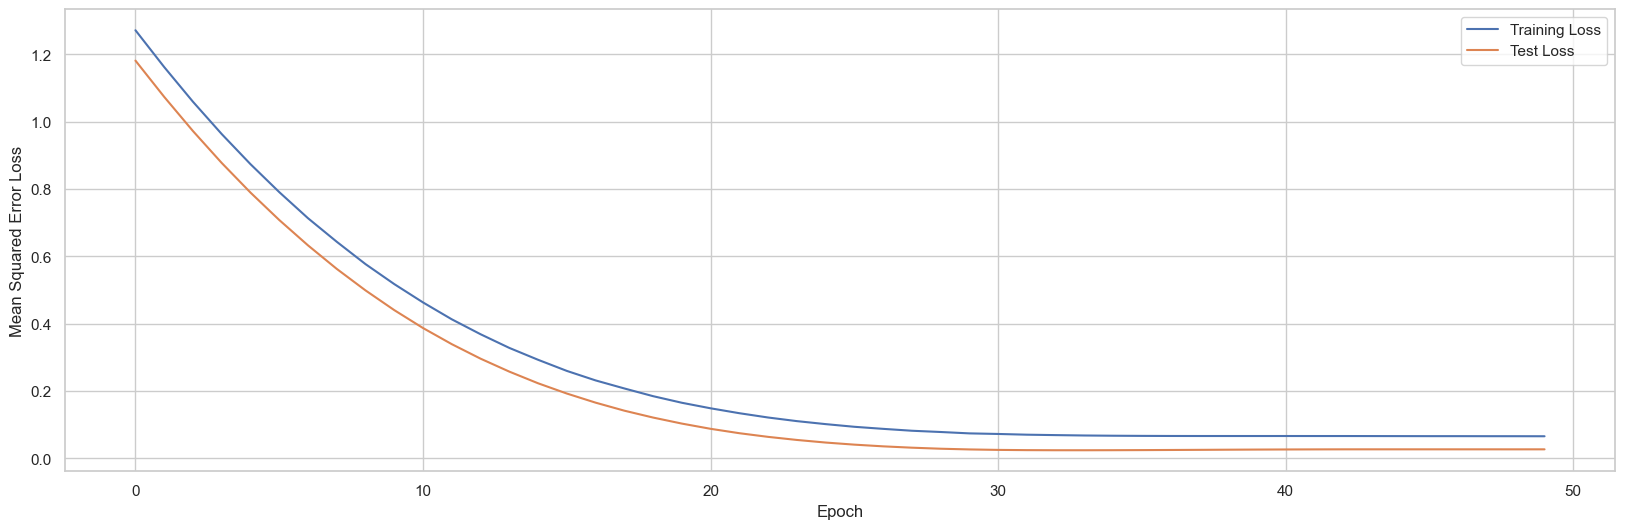

1/1 [==============================] - 0s 28ms/step - loss: 0.0956
Mean Squared Error on Test Data: 0.09559628367424011


In [150]:
# Preprocessing
label_encoder = LabelEncoder()
df_ml_nn['Country'] = label_encoder.fit_transform(df_ml_nn['Country'])

df_ml_nn['Year'] = df_ml_nn['Year'] - df_ml_nn['Year'].min()

# Define features and target variables
X = df_ml_nn[['Country', 'Year']]
X.reset_index(inplace=True, drop=True)
y = df_ml_nn[['Sentiment', 'PCT', 'BMCT', 'OT']]
y.reset_index(inplace=True, drop=True)

# Train-test split
X_train = X.loc[X["Year"] != 5]
X_train.reset_index(inplace=True, drop=True)
y_train = y.loc[X["Year"] != 5]
y_train.reset_index(inplace=True, drop=True)

X_test = X.loc[X["Year"] == 5]
X_test.reset_index(inplace=True, drop=True)
y_test = y.loc[X["Year"] == 5]
y_test.reset_index(inplace=True, drop=True)

# Build the Neural Network
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], 1), activation="sigmoid"))
model.add(Dense(4, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model and get the history
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

# Plot the training and test losses
plt.figure(figsize=(20, 6))  # Set the size of the figure
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')  # Change to 'Test Loss'
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss}')

##### Model comparison

Below code is used to compute values for the different metrics and countries in year 2021 (1 step forecasting).

The idea is to compare actual values with the ones forecasted by the LSTM and the Linear Regression to obtain some visual insights on models performance:

1/1 [==============================] - 0s 174ms/step


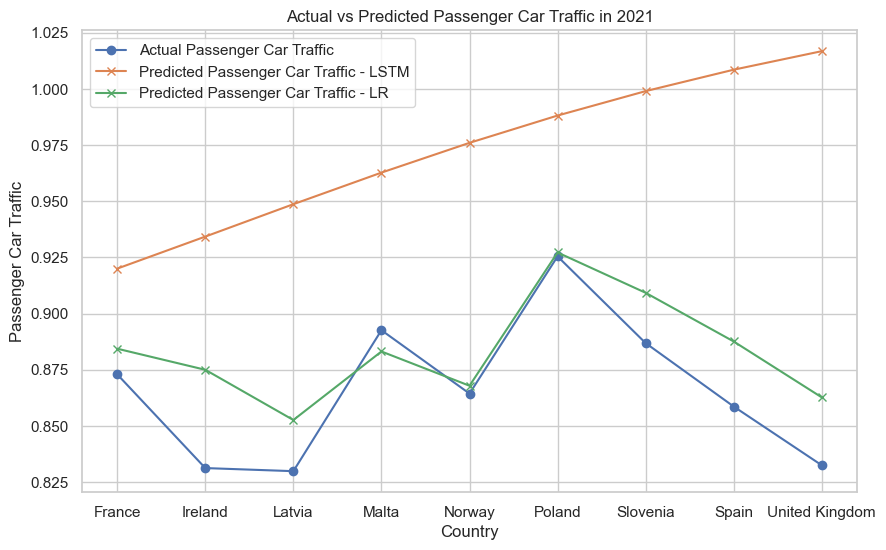

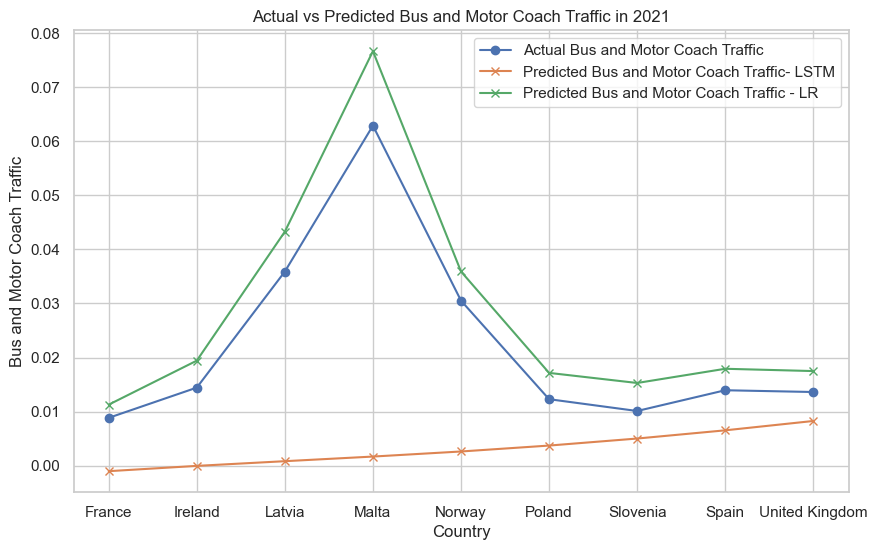

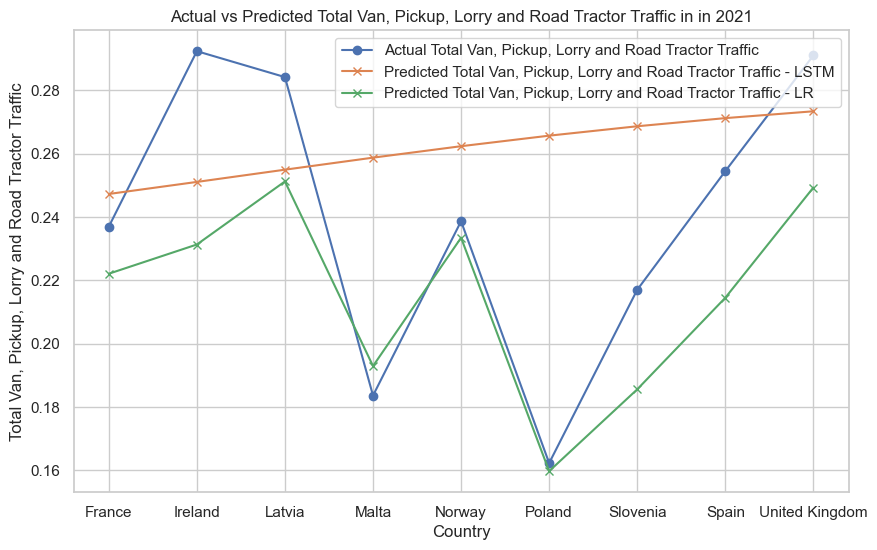

In [151]:
# Predictions on the test set
y_pred = model.predict(X_test)
countries = df_ml.loc[df_ml["Year"]==2021]["Country"].values

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(countries, y_test['PCT'], label='Actual Passenger Car Traffic', marker='o')
plt.plot(countries, y_pred[:, 1], label='Predicted Passenger Car Traffic - LSTM', marker='x')
plt.plot(countries, predictions[:,1], label='Predicted Passenger Car Traffic - LR', marker='x')
plt.xlabel('Country')
plt.ylabel('Passenger Car Traffic')
plt.title('Actual vs Predicted Passenger Car Traffic in 2021')
plt.legend()
plt.show()

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(countries, y_test['BMCT'], label='Actual Bus and Motor Coach Traffic', marker='o')
plt.plot(countries, y_pred[:, 2], label='Predicted Bus and Motor Coach Traffic- LSTM', marker='x')
plt.plot(countries, predictions[:,2], label='Predicted Bus and Motor Coach Traffic - LR', marker='x')
plt.xlabel('Country')
plt.ylabel('Bus and Motor Coach Traffic')
plt.title('Actual vs Predicted Bus and Motor Coach Traffic in 2021')
plt.legend()
plt.show()

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(countries, y_test['OT'], label='Actual Total Van, Pickup, Lorry and Road Tractor Traffic', marker='o')
plt.plot(countries, y_pred[:, 3], label='Predicted Total Van, Pickup, Lorry and Road Tractor Traffic - LSTM', marker='x')
plt.plot(countries, predictions[:,3], label='Predicted Total Van, Pickup, Lorry and Road Tractor Traffic - LR', marker='x')
plt.xlabel('Country')
plt.ylabel('Total Van, Pickup, Lorry and Road Tractor Traffic')
plt.title('Actual vs Predicted Total Van, Pickup, Lorry and Road Tractor Traffic in in 2021')
plt.legend()
plt.show()

Let's also export those results for dashboarding purposes:

In [152]:
# Convert them to DataFrames
df_y_pred = pd.DataFrame(y_pred, columns=['Sentiment', 'PCT', 'BMCT', 'OT'])
df_predictions = pd.DataFrame(predictions, columns=['Sentiment', 'PCT', 'BMCT', 'OT'])

# Save DataFrames to CSV
y_test.to_csv("..\Data\y_test_dashboard.csv", index=False)
df_y_pred.to_csv("..\Data\y_pred_dashboard.csv", index=False)
df_predictions.to_csv("..\Data\predictions_dashboard.csv", index=False)